# CLASSIFICATION PREDICT
# Team EN1 JHB

### Introduction

As the public grows more accepting of climate change as fact, it becomes less accepting of businesses that don't work to reduce their environmental impact. Increasingly, consumers look for products that are sustainably produced or at least have a smaller environmental impact than other comparable products. Companies are also increasingly expected to be socially responsible and take steps to make their operations more environmentally friendly or to donate to environmental charities. This push has been part of the reason that large companies like IKEA, Swiss RE, Apple and Nestle have committed to 100 percent renewable energy

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

### Problem Statement
Develop a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### Benefits
Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

## Outline

In order to meet this objective, the notebook will cover the following sections:



*   Data Preprocessing applied to both the train and test datasets

*   The building of various models 

*   The selection of the best model


# PRE-PROCESSING

### IMPORTING RELAVANT LIBRARIES

In [1]:
import comet_ml
from comet_ml import Experiment

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import string
import re
import spacy

#The Natural Language Toolkit library
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown 
from nltk import bigrams, trigrams

#Machine learning library
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#library for oversampling 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
!pip install comet_ml

##### Setting the API key (saved as environment variable)
experiment = Experiment(api_key='e03Z32Ilv0BBSwULP9xqfZwkO',
                       project_name = "general",workspace="lee-roy")

In [18]:
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nlp = spacy.load('en_core_web_md')
tokenizer = RegexpTokenizer(r'\w+')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


## Define functions to pre-process data

In [5]:
def removing_stopwords(post):
    """
    This function gets all the words in the tweets tokenizes, removes stopwords
    and lemmatizes all the words in a sentence

    """
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(post)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    allwords = [lemmatizer.lemmatize(w) for w in filtered_sentence]
    return allwords


In [6]:
def nouns(post):
    """
    This function gets all the nouns in tweets
    """
    text = word_tokenize(post)
    nouns = set()
    for word, pos in nltk.pos_tag(text):
        if pos in ['NN']:
            nouns.add(word)
    return nouns


In [7]:
def verbs(post):
    """
    This function gets all the verbs in tweets
    """
    text = word_tokenize(post)
    nouns = set()
    for word, pos in nltk.pos_tag(text):
        if pos in ['VB']:
            nouns.add(word)
    return nouns


In [8]:
def tweets_from_tokens(post):
    """
    This function creates clean messages from lists

    """
    str1 = " "
    sentence = str1.join([w for w in post])
    return sentence


In [9]:
def remove_punctuation_numbers(post):
    """
    This function removes all puntuation marks and numbers
    """
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])


In [10]:
def remove_urls(data):
    """
    This function removes url links

    """
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = r''
    data['message'] = data['message'].replace(to_replace=pattern_url, value=subs_url, regex=True)
    return data


In [11]:
def remove_pattern(input_txt, pattern):
    """
    This function removes specified patterns

    """
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt


In [12]:
def length_of_message(data):
    """
    This function gets the length of a tweet

    """
    data['length'] = data['message'].apply(lambda x: len(x))
    return data


In [13]:
def make_bigrams(post):
    """
    Tokenise and get bi-grams from the tweets

    """
    text = word_tokenize(post)
    return list(bigrams(text))


In [14]:
def make_trigrams(post):
    """
    Tokenise and get bi-grams from the tweets

    """
    text = word_tokenize(post)
    return list(trigrams(text))


In [15]:
def metric_evaluation(y_test, predictions):
    cfn_m = confusion_matrix(y_test, predictions)
    c_r = classification_report(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    print(cfn_m)
    print(c_r)
    print(accuracy)


In [39]:
def scored(y_test, predictions):
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average='macro')
    r = recall_score(y_test, predictions, average='macro')
    f = f1_score(y_test, predictions, average='macro')
    return a, p, r, f


## Check for missing tweets

In [11]:
train_df.isnull().sum()


sentiment    0
message      0
tweetid      0
dtype: int64

It can be seen that there are no rows with missing tweets

## Apply pre-processing functions

1) Remove puntuation

2) Make lower case

3) Tokenize

4) Lemmatize

5) Remove stop words 

6) Get verbs and nouns

In [19]:
train = train_df.copy()
train['unclean'] = train['message'].str.lower()
train = remove_urls(train)
train['message'] = np.vectorize(remove_pattern)(train['message'], "@[\w]*")
train['message'] = train['message'].apply(remove_punctuation_numbers)
train['message'] = train['message'].str.lower()
train['POS_nouns'] = train['message'].apply(nouns)
train['POS_verbs'] = train['message'].apply(verbs)
train['clean_tokens'] = train['message'].apply(removing_stopwords)
train['message'] = train['clean_tokens'].apply(tweets_from_tokens)


In [20]:
def convert_bigrams(post):
    """
    This function converts bigrams from tuples
    """
    res = ['_'.join(tups) for tups in post]
    return res


In [21]:
train['bigrams_text_list']  = train['message'].apply(make_bigrams).apply(convert_bigrams)
train['trigrams_text_list']  = train['message'].apply(make_trigrams).apply(convert_bigrams)


In [22]:
train['bigrams_text'] = train['bigrams_text_list'].apply(tweets_from_tokens)
train['trigrams_text'] = train['trigrams_text_list'].apply(tweets_from_tokens)


In [467]:
train


sentiment                                            message  tweetid  \
0              1  polyscimajor epa chief doesnt think carbon dio...   625221   
1              1    like lack evidence anthropogenic global warming   126103   
2              2  rt researcher say three year act climate chang...   698562   
3              1  todayinmaker wired pivotal year war climate ch...   573736   
4              1  rt racist sexist climate change denying bigot ...   466954   
...          ...                                                ...      ...   
15814          1  rt took material global warming lgbt right hea...    22001   
15815          2  rt climate change could breaking millionyearol...    17856   
15816          0  notiven rt nytimesworld trump actually believe...   384248   
15817         -1  rt hey liberal climate change crap hoax tie ag...   819732   
15818          0             rt climate change equation screenshots   806319   

                                                 unclean  \
0      polyscimajor epa chief doesn't think carbon di...   
1      it's not like we lack evidence of anthropogeni...   
2      rt @rawstory: researchers say we have three ye...   
3      #todayinmaker# wired : 2016 was a pivotal year...   
4      rt @soynoviodetodas: it's 2016, and a racist, ...   
...                                                  ...   
15814  rt @ezlusztig: they took down the material on ...   
15815  rt @washingtonpost: how climate change could b...   
15816  notiven: rt: nytimesworld :what does trump act...   
15817  rt @sara8smiles: hey liberals the climate chan...   
15818  rt @chet_cannon: .@kurteichenwald's 'climate c...   

                                               POS_nouns  \
0          {chief, epa, warming, cause, dioxide, carbon}   
1                                    {evidence, warming}   
2                                  {rt, change, climate}   
3             {war, climate, year, change, todayinmaker}   
4               {racist, climate, change, bigot, sexist}   
...                                                  ...   
15814                       {rt, material, health, care}   
15815             {millionyearold, change, relationship}   
15816                  {climate, perry, change, rick, …}   
15817  {climate, rt, crap, hey, change, hoax, byã¢â‚¬â¦}   
15818                 {s, equation, climate, rt, change}   

                  POS_verbs  \
0                    {wait}   
1                        {}   
2                     {act}   
3                        {}   
4                      {rt}   
...                     ...   
15814                    {}   
15815              {rt, be}   
15816  {rt, trump, believe}   
15817              {agenda}   
15818                    {}   

                                            clean_tokens  \
0      [polyscimajor, epa, chief, doesnt, think, carb...   
1      [like, lack, evidence, anthropogenic, global, ...   
2      [rt, researcher, say, three, year, act, climat...   
3      [todayinmaker, wired, pivotal, year, war, clim...   
4      [rt, racist, sexist, climate, change, denying,...   
...                                                  ...   
15814  [rt, took, material, global, warming, lgbt, ri...   
15815  [rt, climate, change, could, breaking, million...   
15816  [notiven, rt, nytimesworld, trump, actually, b...   
15817  [rt, hey, liberal, climate, change, crap, hoax...   
15818       [rt, climate, change, equation, screenshots]   

                                       bigrams_text_list  \
0      [polyscimajor_epa, epa_chief, chief_doesnt, do...   
1      [like_lack, lack_evidence, evidence_anthropoge...   
2      [rt_researcher, researcher_say, say_three, thr...   
3      [todayinmaker_wired, wired_pivotal, pivotal_ye...   
4      [rt_racist, racist_sexist, sexist_climate, cli...   
...                                                  ...   
15814  [rt_took, took_material, material_global, glob...   
15815  [rt_climate, climate_ch

### Apply the same to the hold-out data

In [23]:
test = test_df.copy()
test['unclean'] = test['message'].str.lower()
test = remove_urls(test)
test['message'] = np.vectorize(remove_pattern)(test['message'], "@[\w]*")
test['message'] = test['message'].apply(remove_punctuation_numbers)
test['message'] = test['message'].str.lower()
test['clean_tokens'] = test['message'].apply(removing_stopwords)
test['message'] = test['clean_tokens'].apply(tweets_from_tokens)


In [473]:
test.head()


message  tweetid  \
0  europe looking china make sure alone fighting ...   169760   
1  combine polling staffer climate change woman r...    35326   
2  scary unimpeachable evidence climate change al...   224985   
3  putin got jill trump doesnt believe climate ch...   476263   
4  rt female orgasm cause global warming sarcasti...   872928   

                                             unclean  \
0  europe will now be looking to china to make su...   
1  combine this with the polling of staffers re c...   
2  the scary, unimpeachable evidence that climate...   
3  @karoli @morgfair @osborneink @dailykos \nputi...   
4  rt @fakewillmoore: 'female orgasms cause globa...   

                                        clean_tokens  
0  [europe, looking, china, make, sure, alone, fi...  
1  [combine, polling, staffer, climate, change, w...  
2  [scary, unimpeachable, evidence, climate, chan...  
3  [putin, got, jill, trump, doesnt, believe, cli...  
4  [rt, female, orgasm, cause, global, warming, s...

# EXPLORATORY ANALYSIS

In [496]:
train['sentiment'].unique()


array([ 1,  2,  0, -1], dtype=int64)

There are four unique tweet classes

In [101]:
counts =  list(train['sentiment'].value_counts())


### Plot of Tweets in each Sentiment

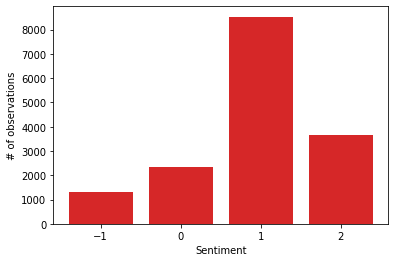

In [23]:
labels = train['sentiment'].unique()
heights = counts
plt.bar(labels, heights, color='tab:red')
plt.xticks(labels)
plt.ylabel("# of observations")
plt.xlabel("Sentiment")
plt.show()


The greatest number of tweets can be seen in the class "1" followed by class "2"

## Extract some of the tweets by sentiment value
# All tweets

To get an idea of the most common words, we take a look at a word cloud and a bar plot depicting the most commonly used words

### Most common words

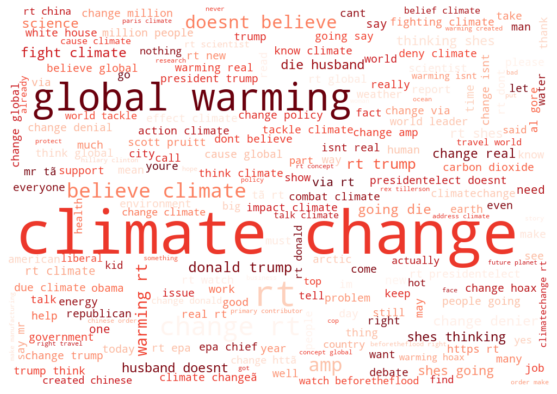

In [497]:
# Plot a word cloud of the most common words
all_words = ' '.join([text for text in train['message']])


def plotwordclouds(text):
    wordcloud = WordCloud(width=1000, height=700, random_state=21,
                          background_color="White",
                          colormap="Reds", max_font_size=110).generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

plotwordclouds(all_words)


In [499]:
def plot_most_frequent(text, title):
    """
    This function plots a bar plot of the words
    """
    mostcommon_small = FreqDist(text).most_common(25)
    x, y = zip(*mostcommon_small)
    plt.figure(figsize=(50, 30))
    plt.margins(0.02)
    plt.bar(x, y, color='tab:red')
    plt.xlabel('Words', fontsize=50)
    plt.ylabel('Frequency of Words', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=90, fontsize=40)
    plt.title(title, fontsize=60)
    plt.show()


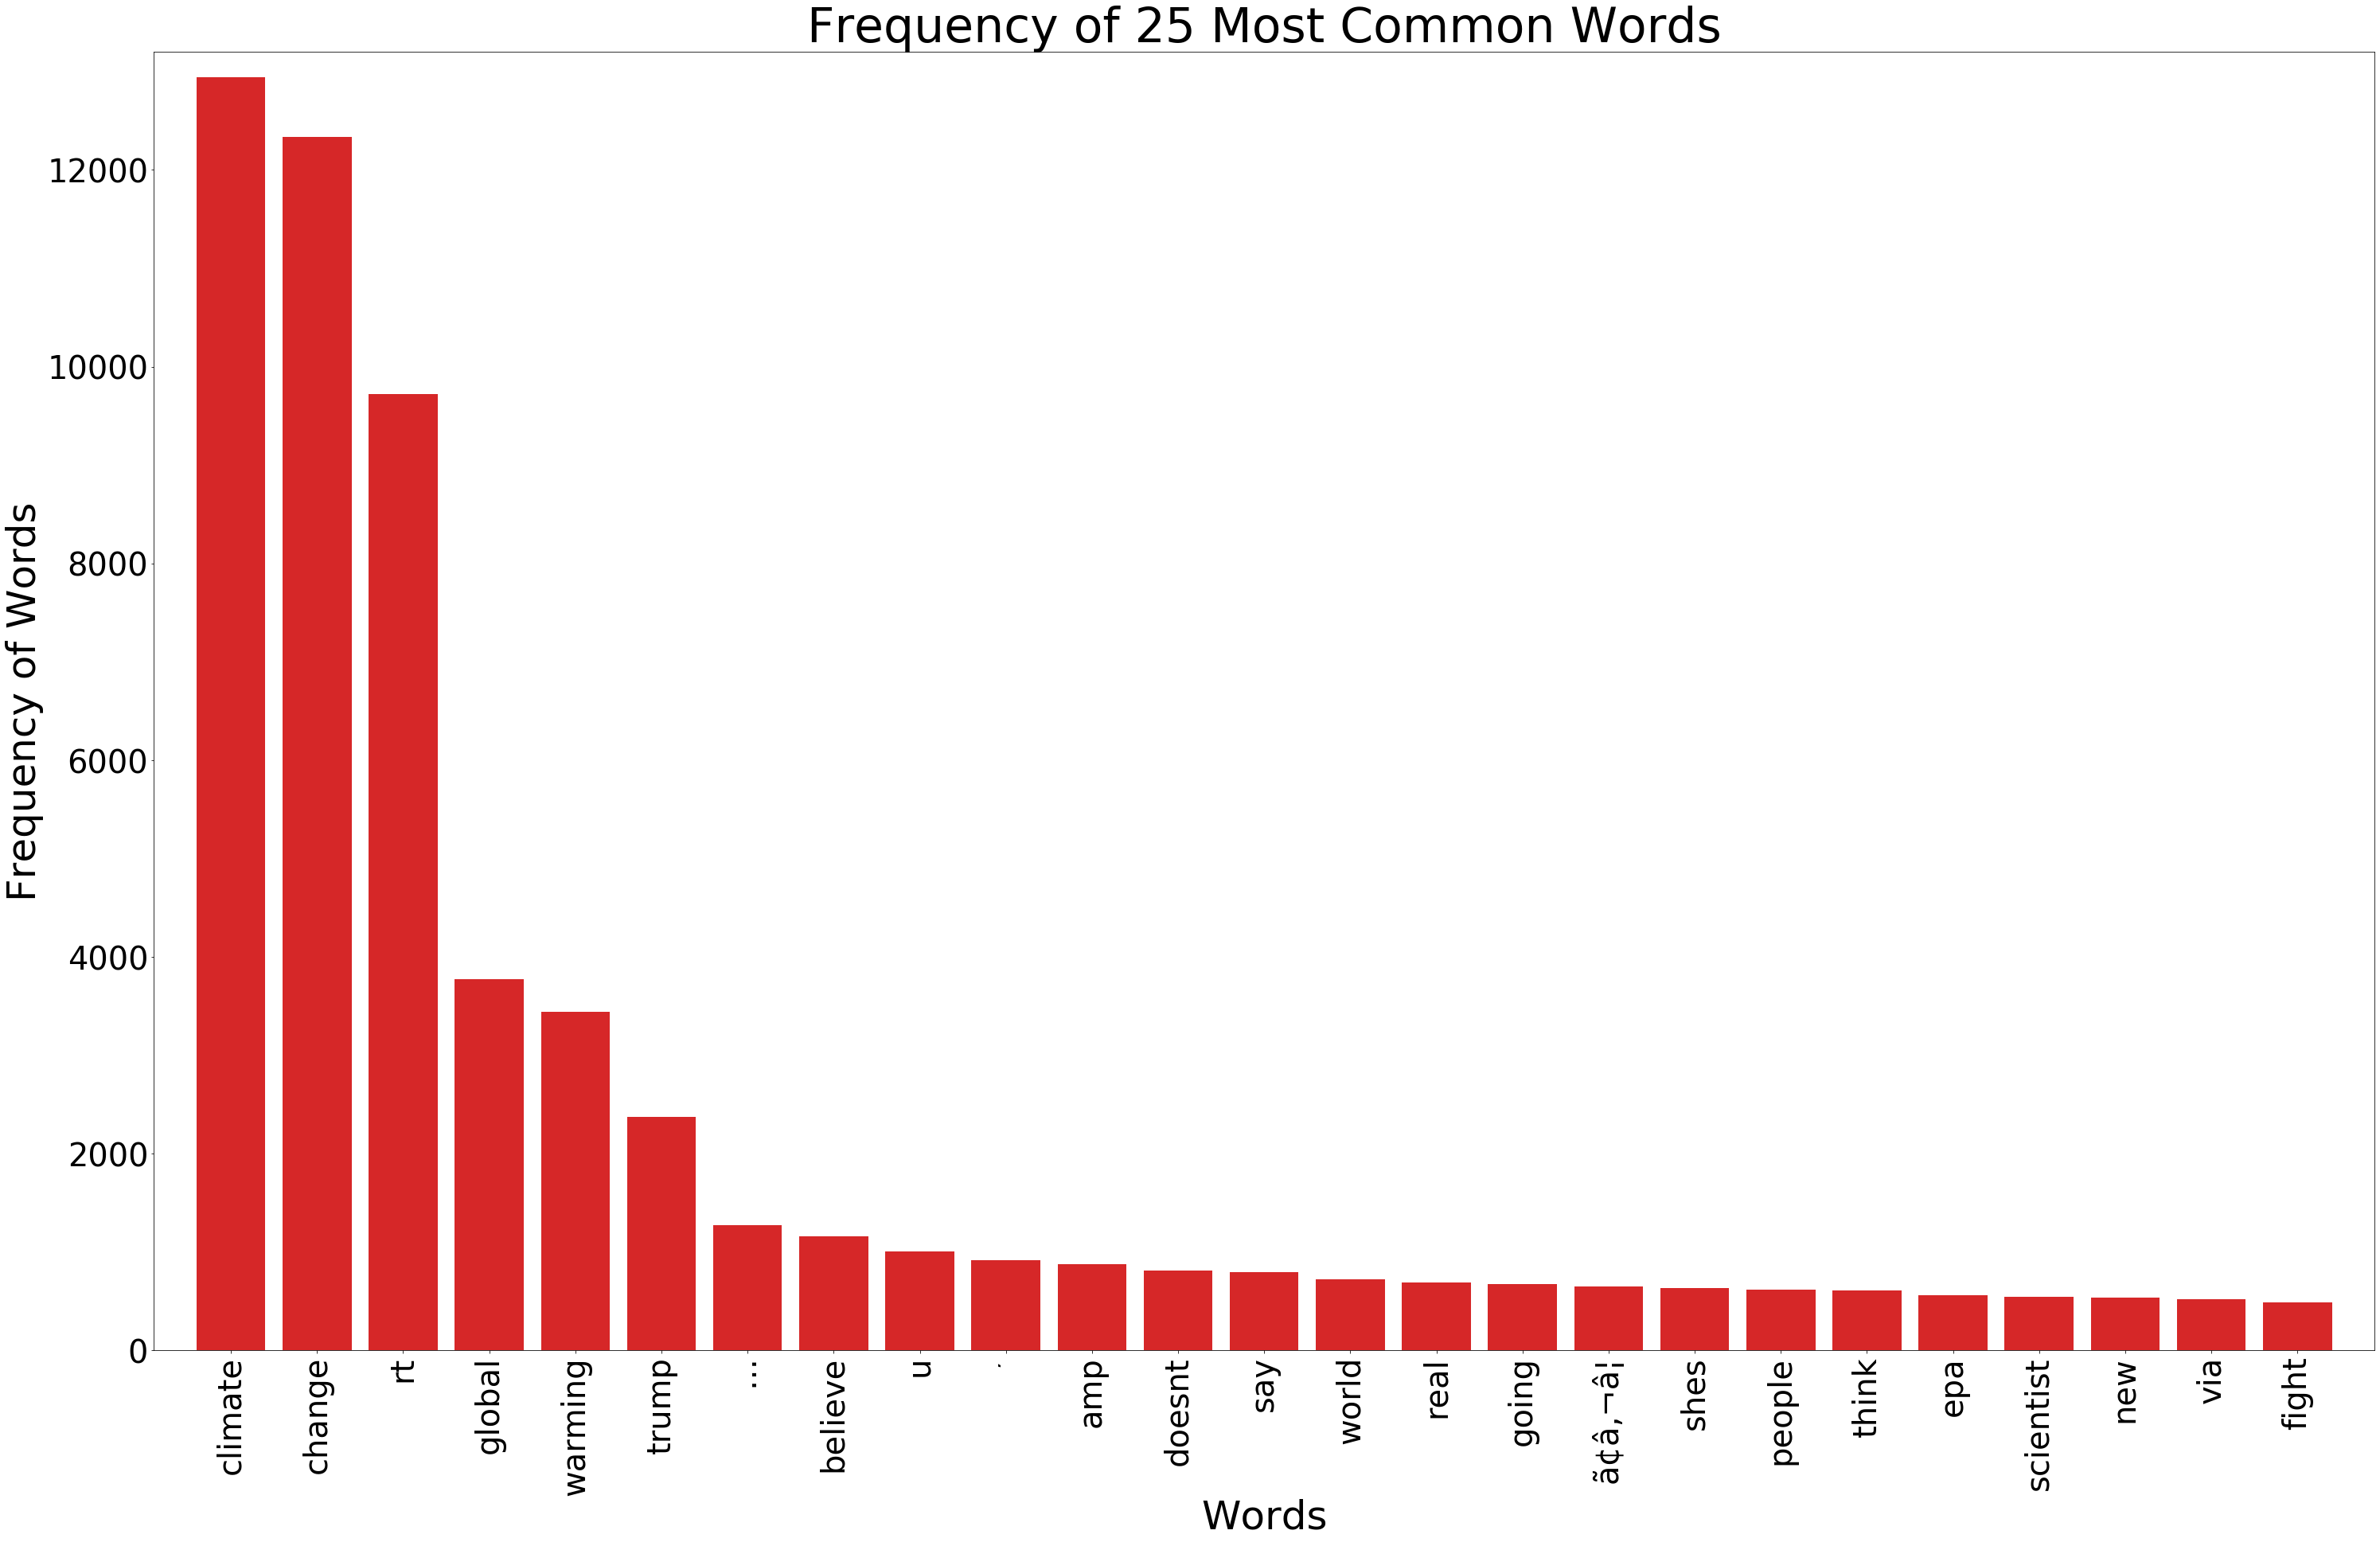

In [346]:
allwords = []
for wordlist in train['clean_tokens']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common Words')


Unsurprisingly, most of the tweets contain information about climate change

Some keys noted

- A huge number of tweets were retweets
- Notice links to Donald Trump

### Visualise the most used nouns

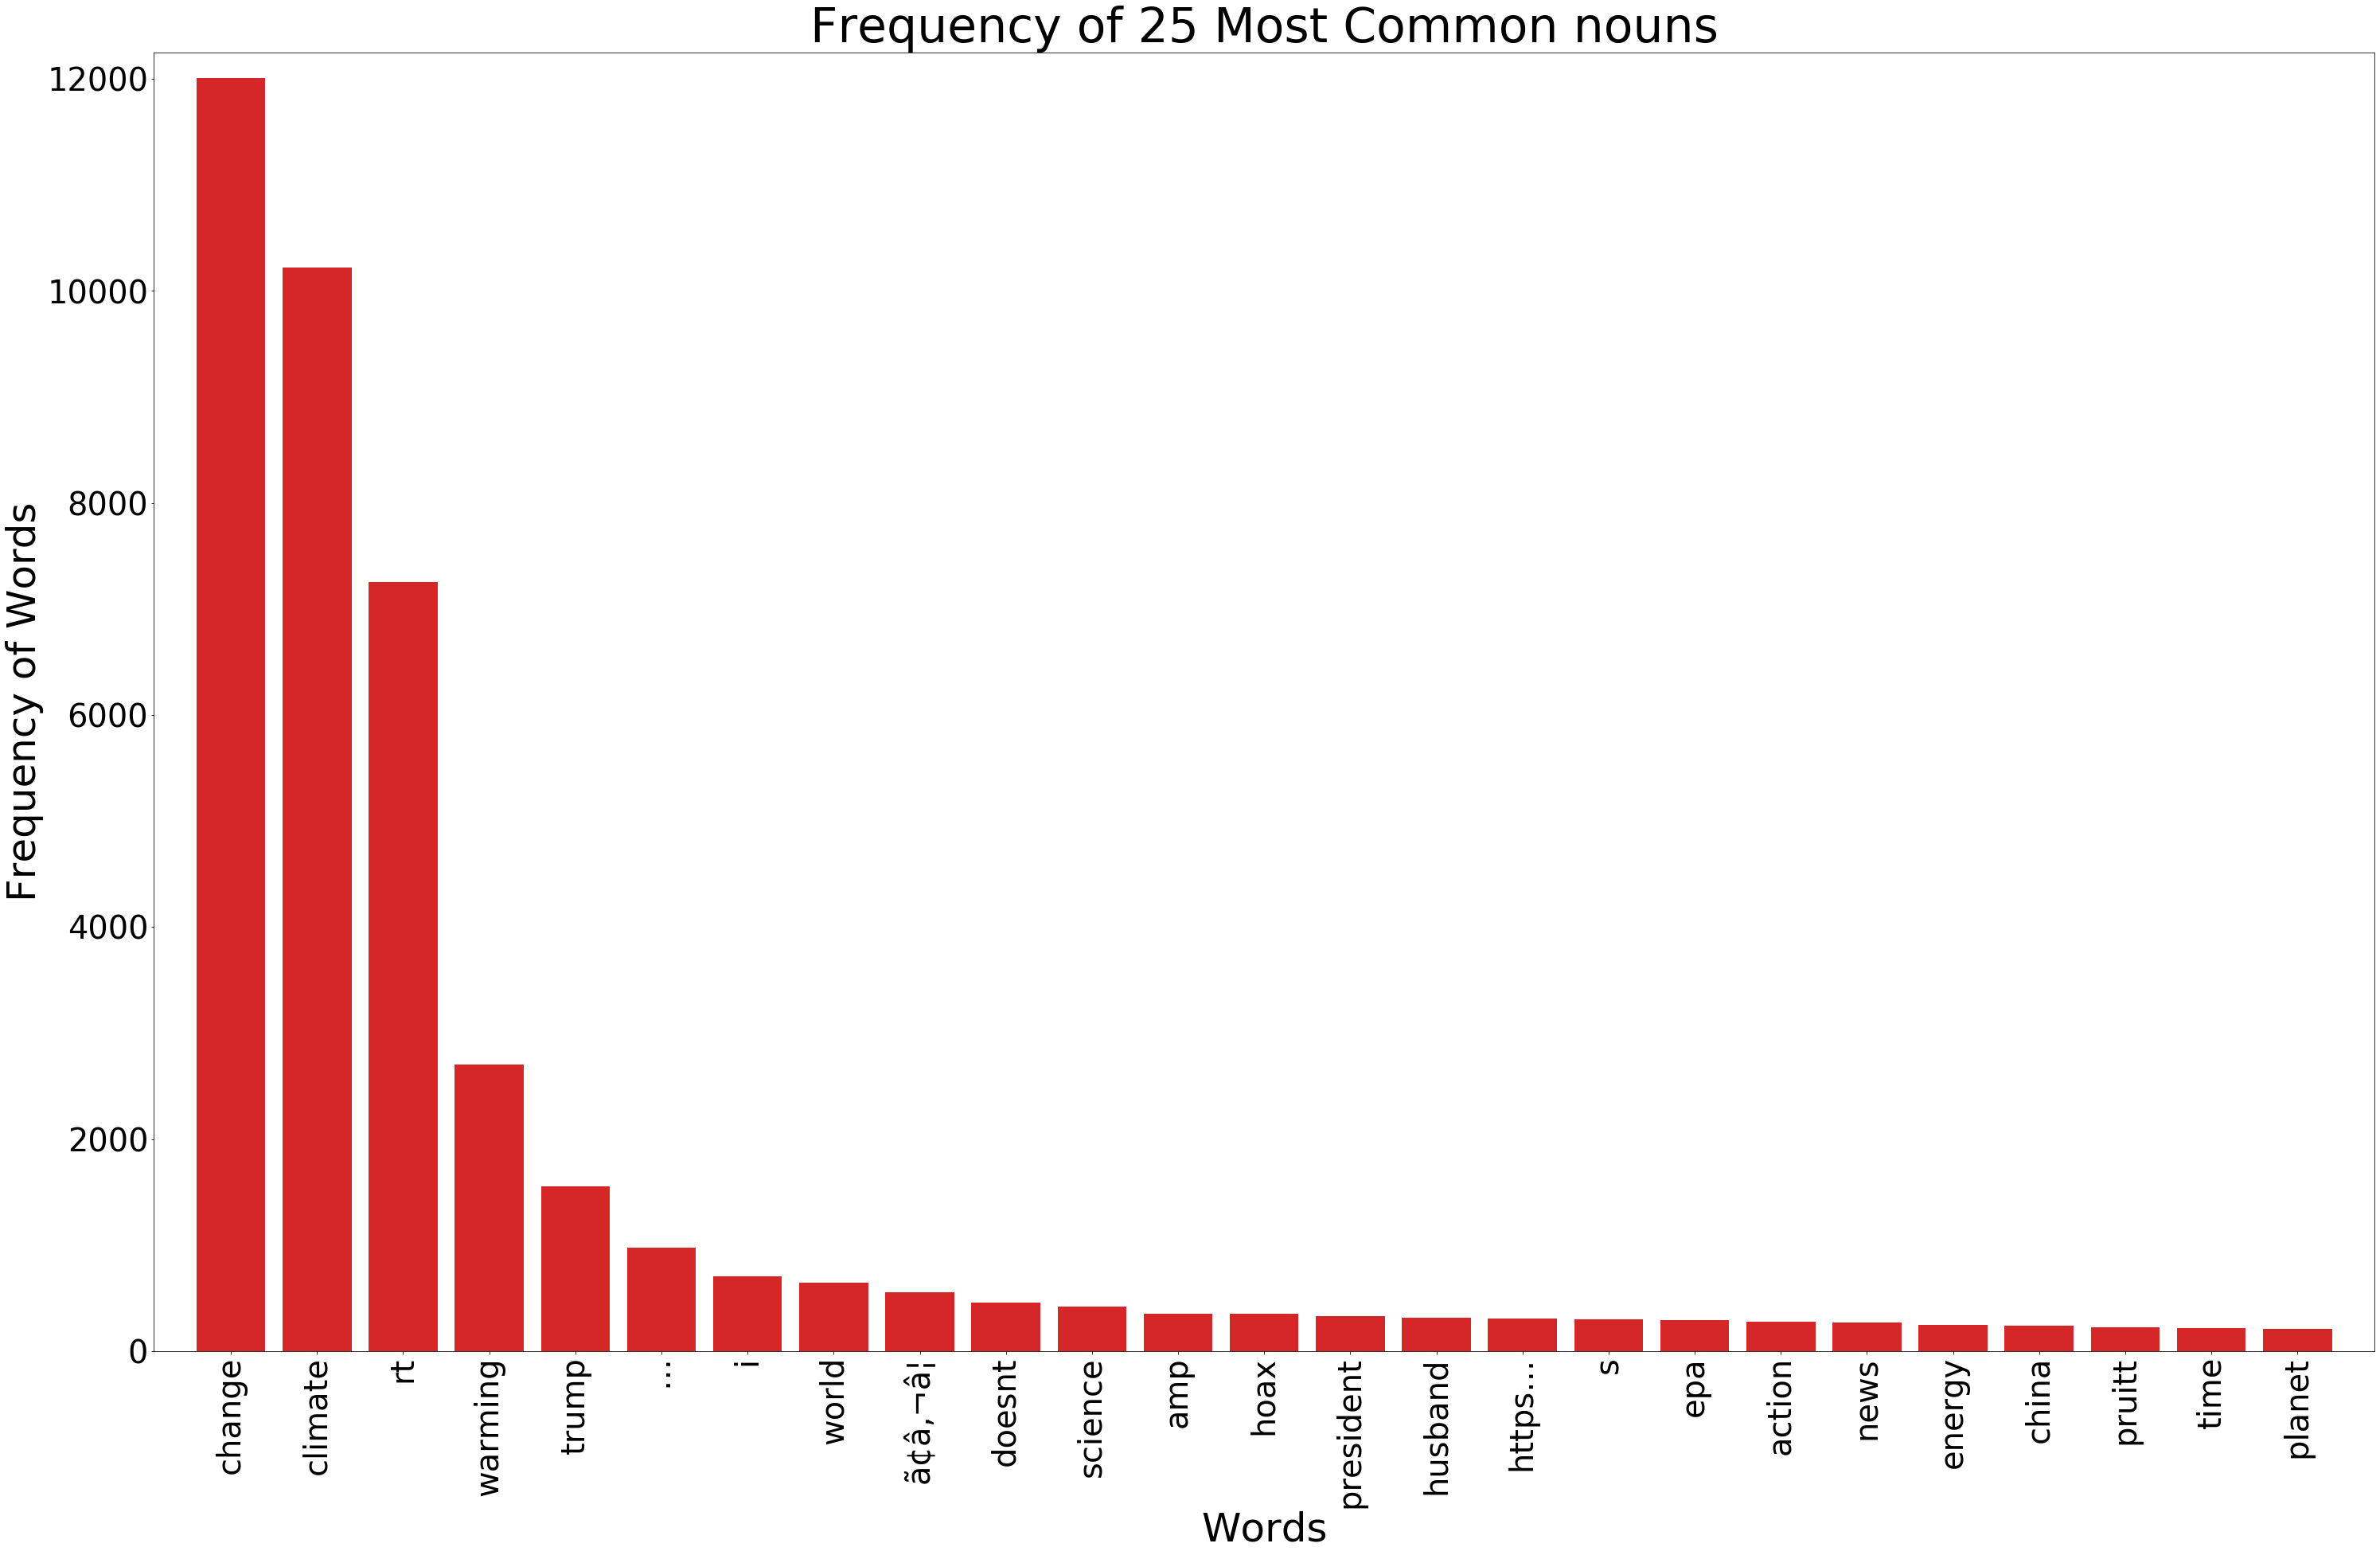

In [347]:
allnouns = []
for wordlist in train['POS_nouns']:
    allnouns += wordlist

plot_most_frequent(allnouns, 'Frequency of 25 Most Common nouns')


We see some words start to surface

- China?
- links to Donald Trump
- hoax 
- Scott Pruitt and EPA (Scott Pruitt is the Environmental Protection Agency(EPA) Administrator)

### Visualise the most used verbs

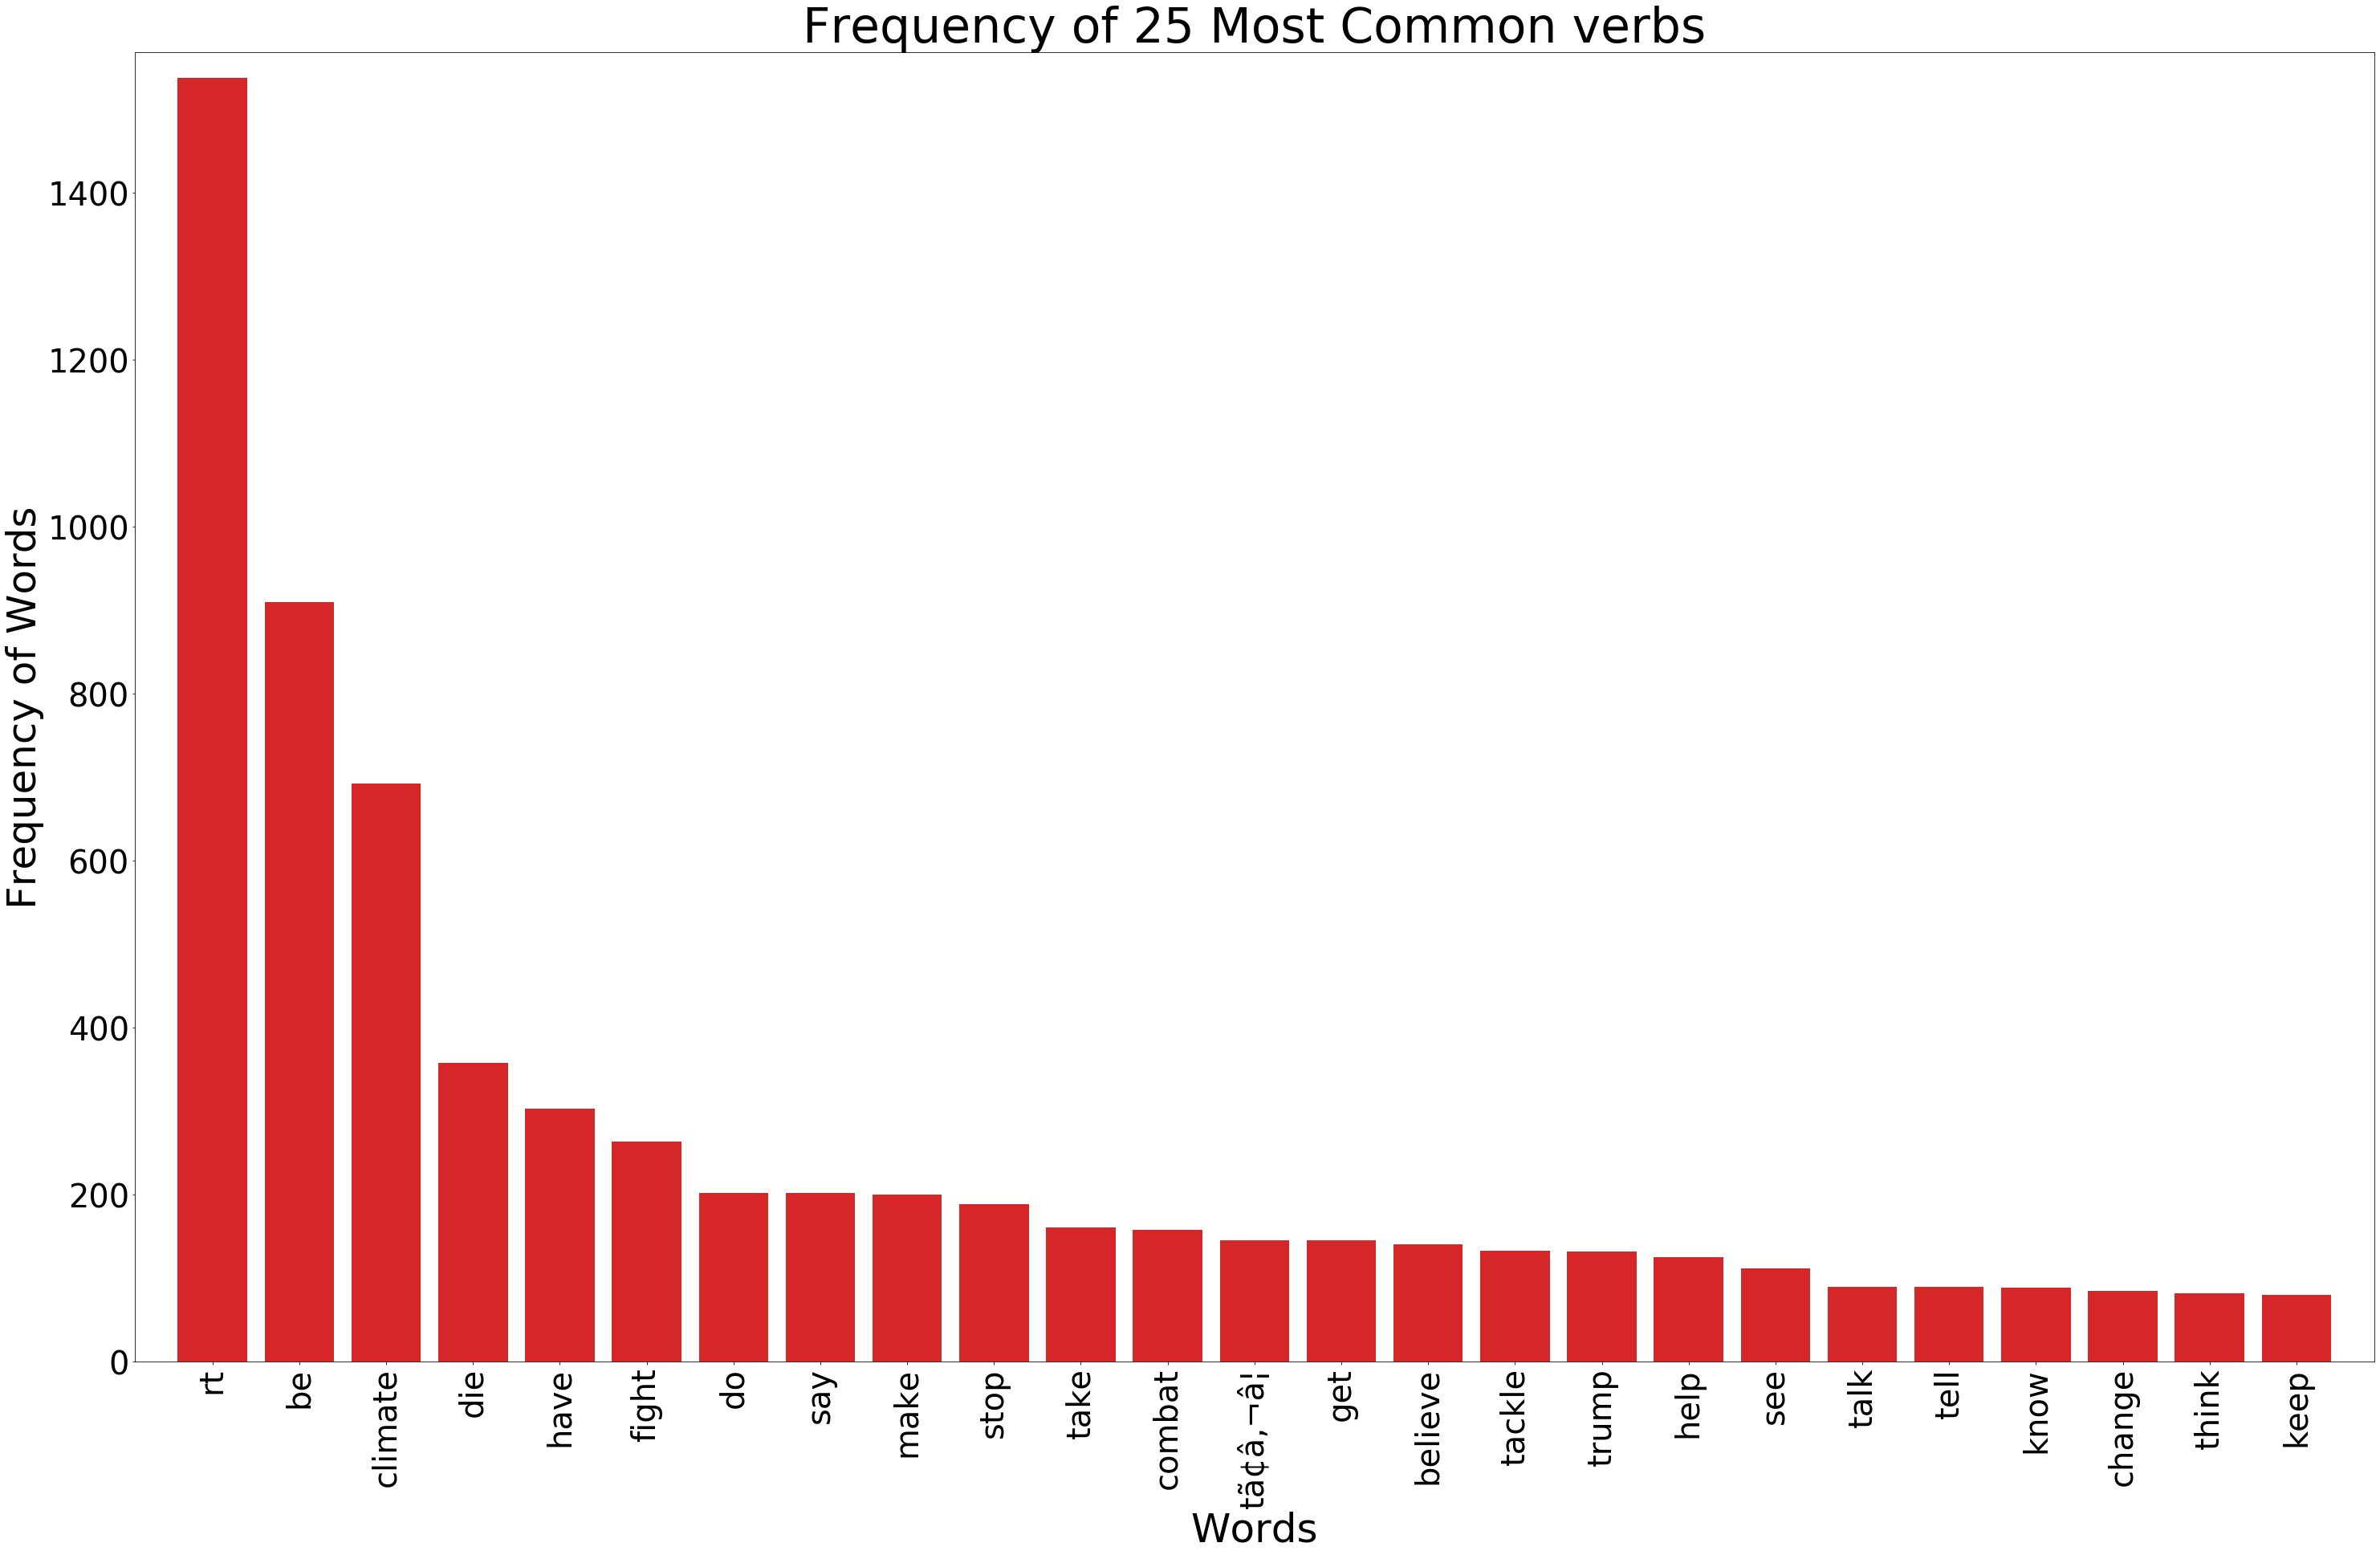

In [501]:
allverbs = []
for wordlist in train['POS_verbs']:
    allverbs += wordlist
plot_most_frequent(allverbs, 'Frequency of 25 Most Common verbs')


Verbs may indicate how insight into how people may want to act, we notice the following key words indicating feelings towards climate change:

- Fight
- stop
- combat
- tackle
- change

### Visualise the most used bi-grams

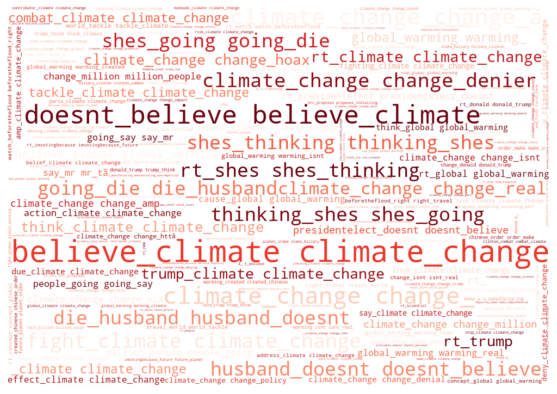

In [349]:
all_bigrams = ' '.join([str(text) for text in train['bigrams_text']])
plotwordclouds(all_bigrams)


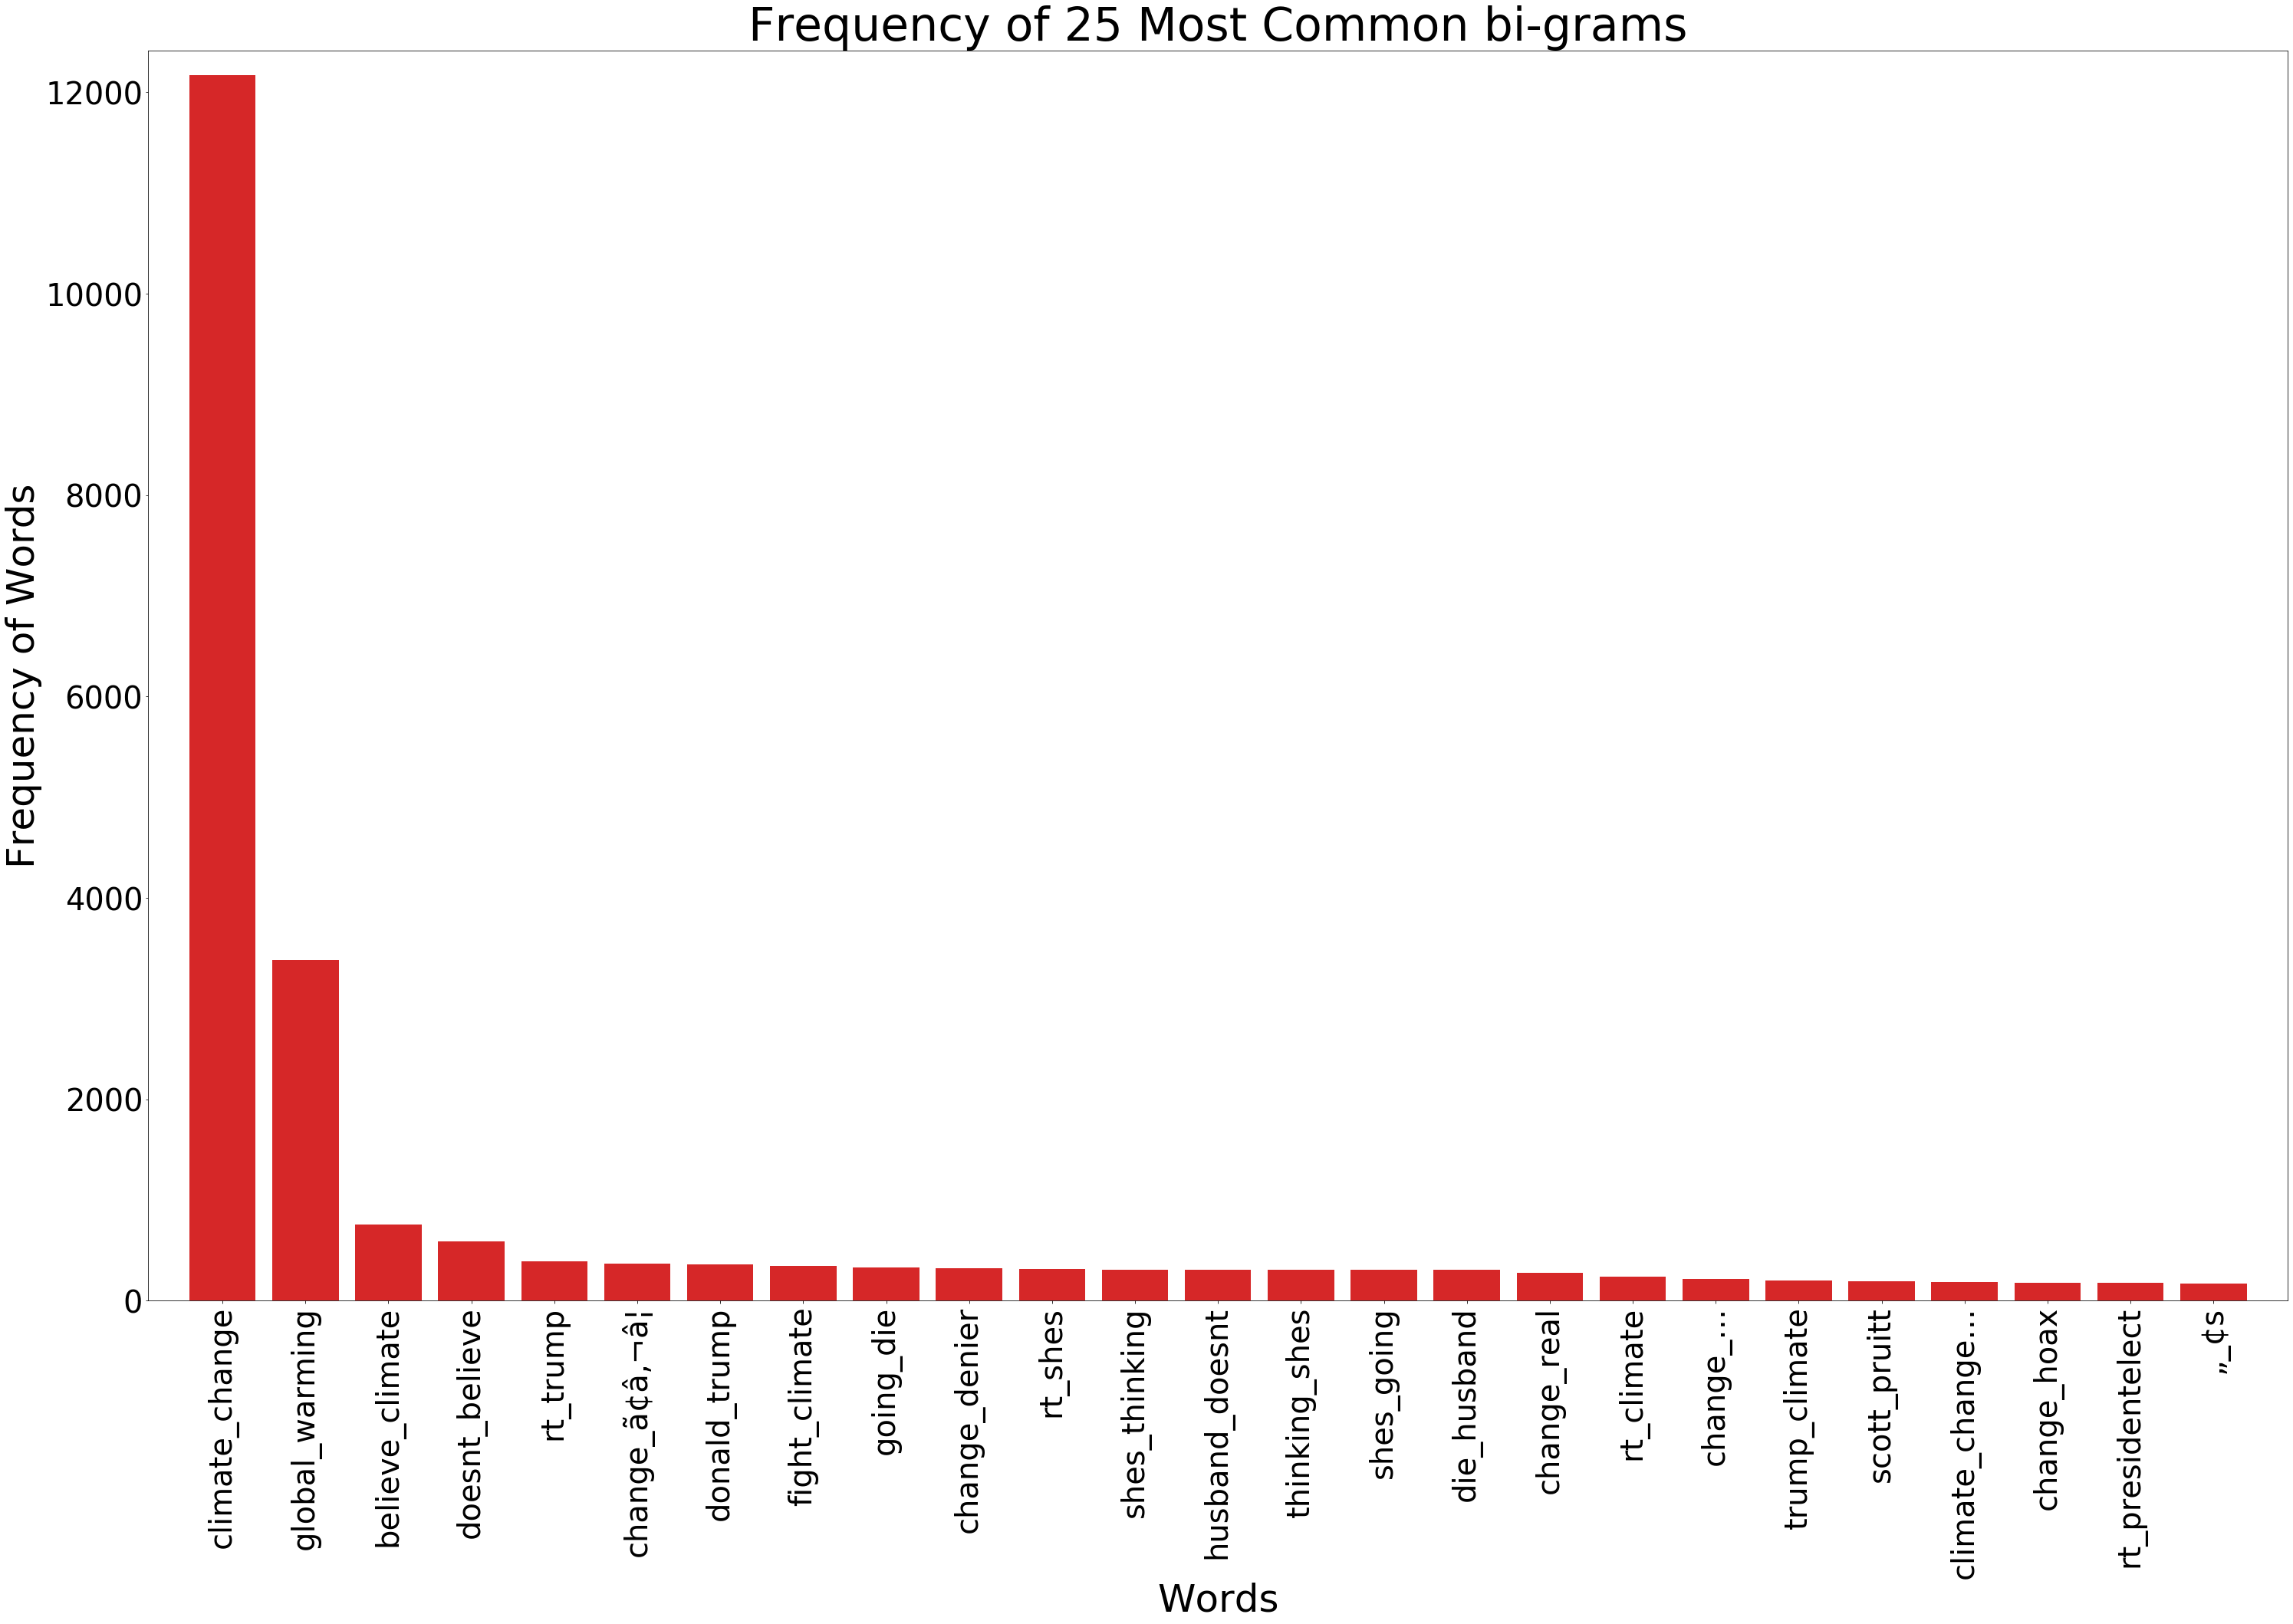

In [350]:
allwords = []
for wordlist in train['bigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common bi-grams')


The biagrams do not reveal much different information from the single words, we  take a look at the trigrams next

### Visualise the most used tri-grams

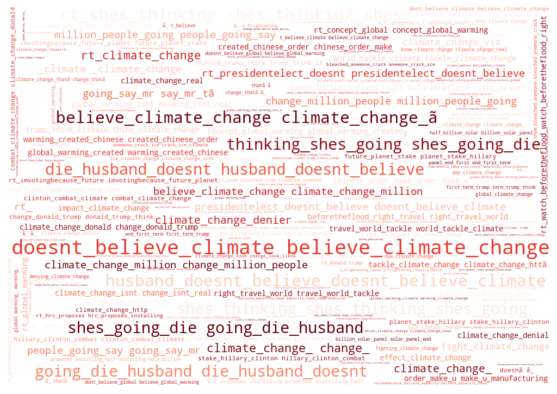

In [507]:
all_bigrams = ' '.join([str(text) for text in train['trigrams_text']])
plotwordclouds(all_bigrams)


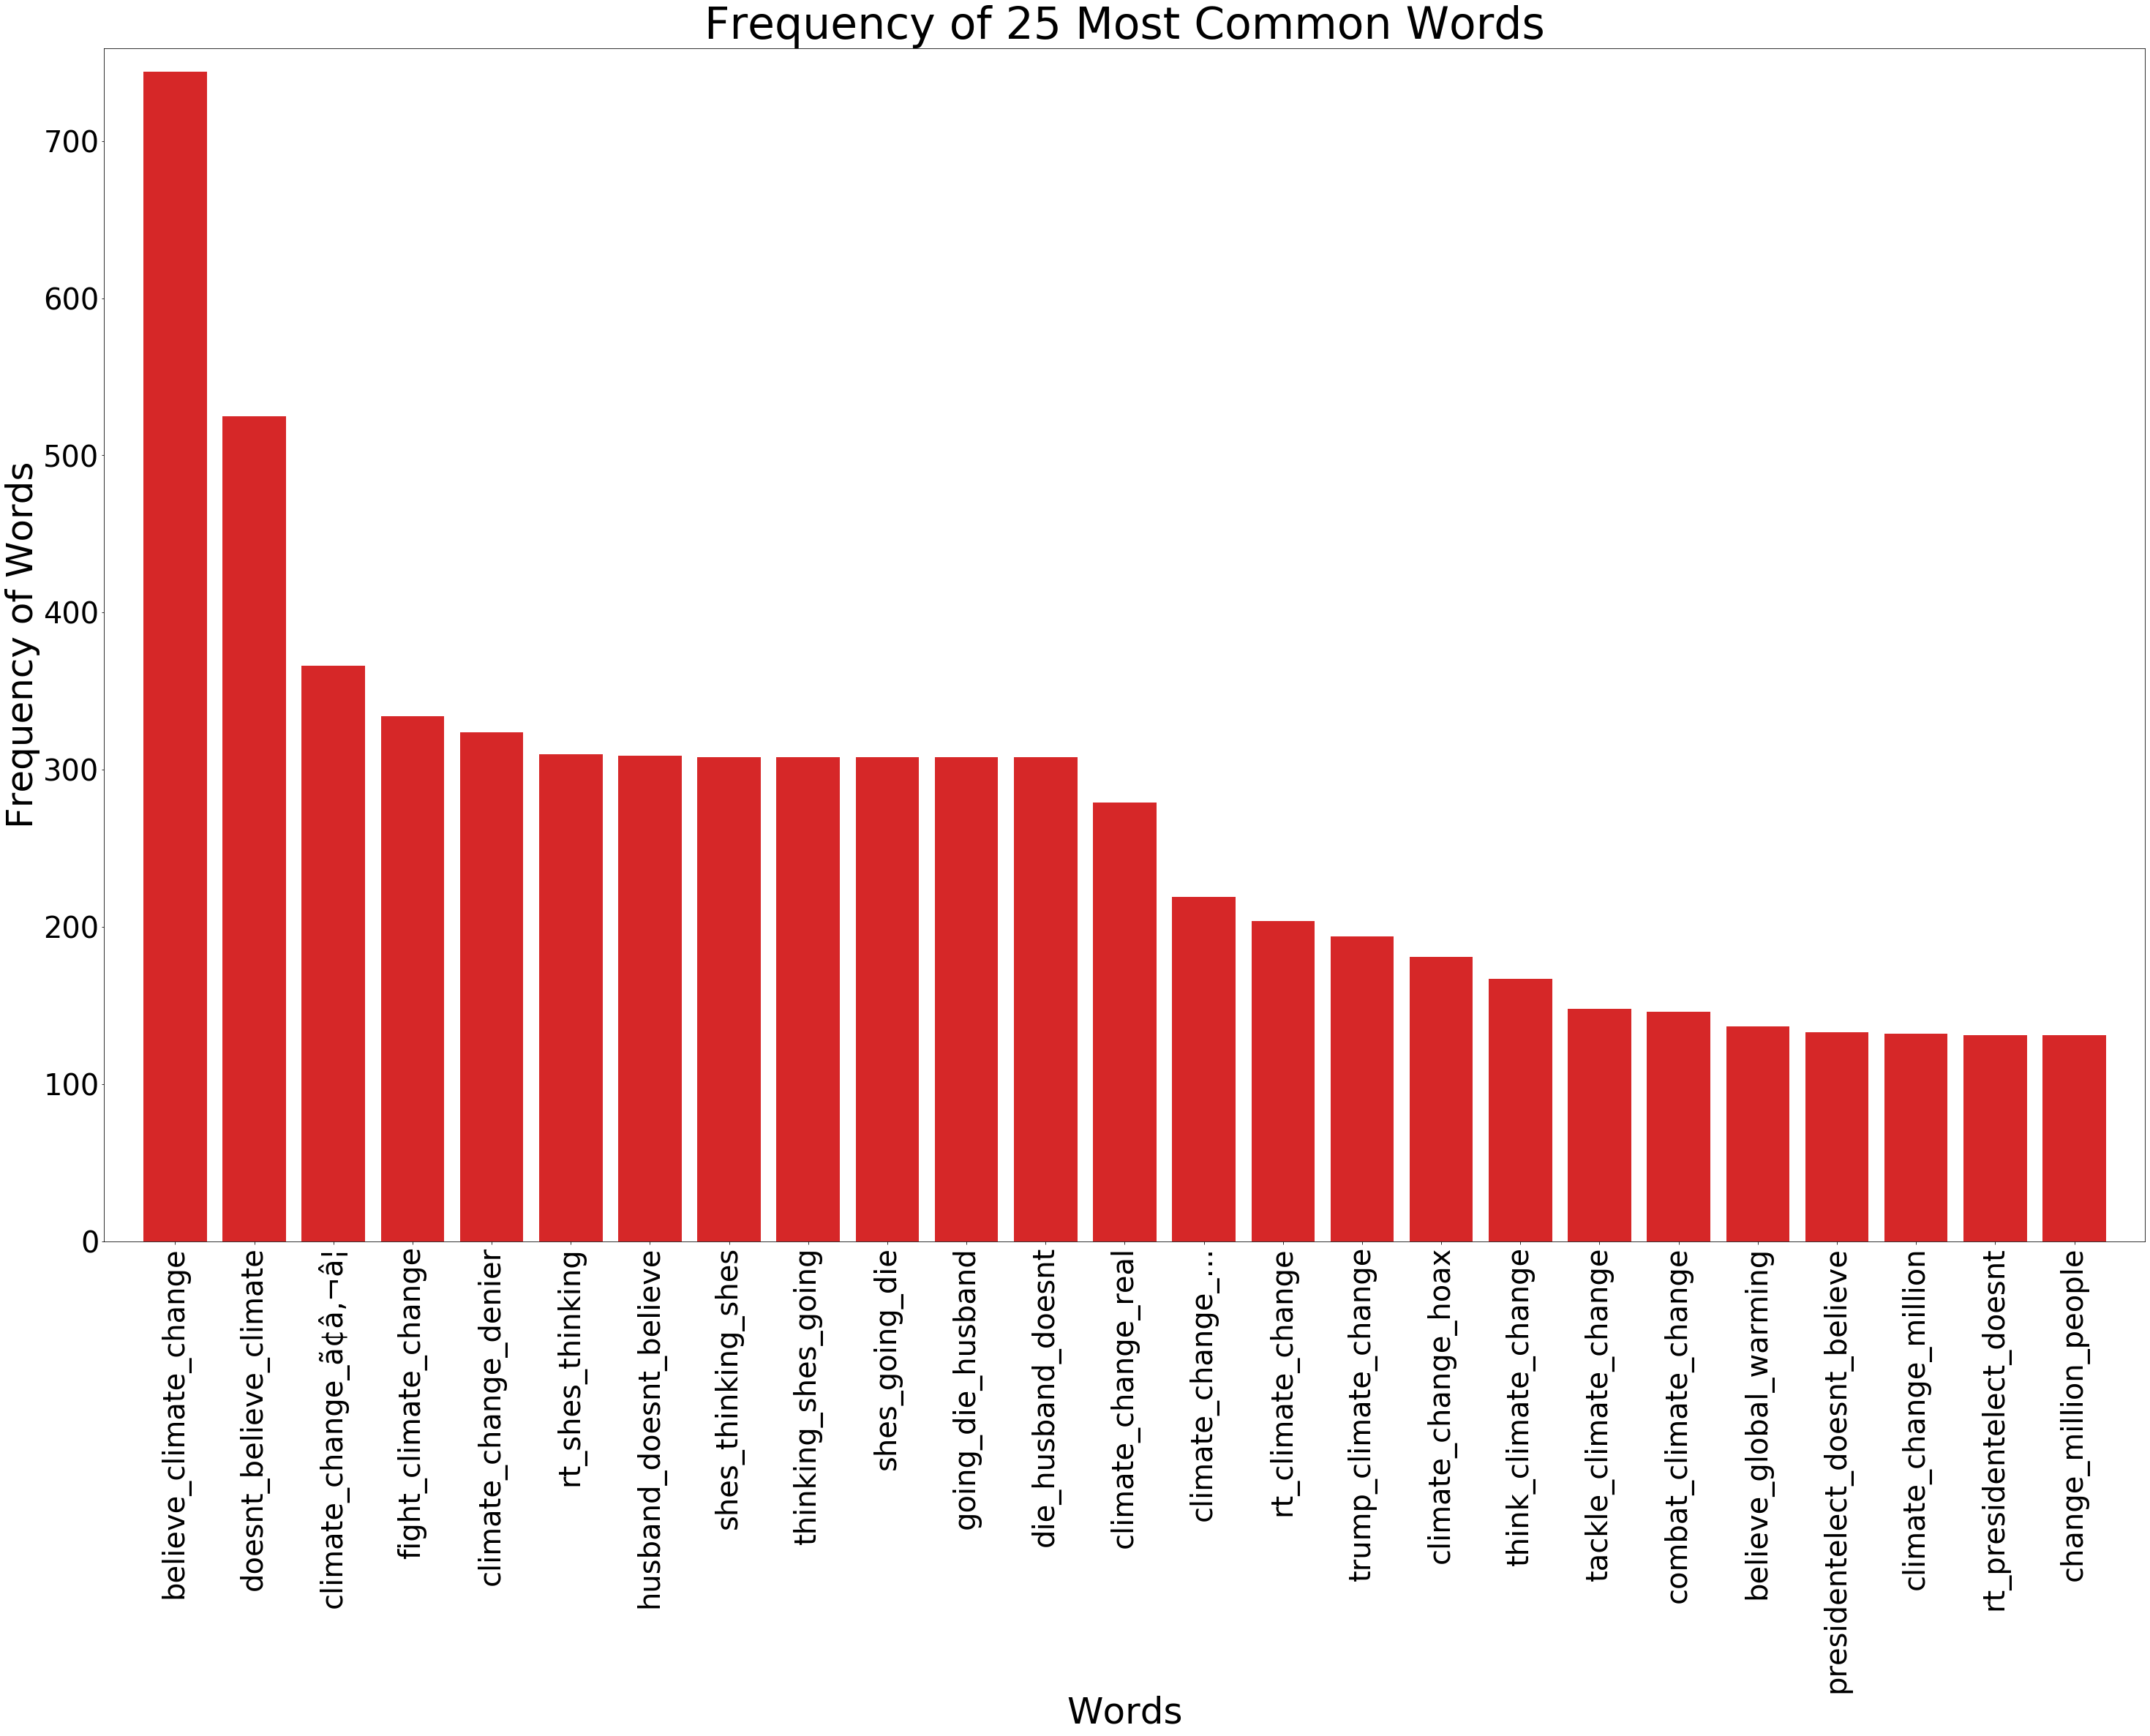

In [508]:
allwords = []
for wordlist in train['trigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords,'Frequency of 25 Most Common Words')


Once again, Donald trump appears in a lot of the tweets

## We take a look at the tweets by the different sentiment classes

## First for tweets in the class "-1" 

In [509]:
for i in range(5):
    print(train[train['sentiment']==-1]['message'].iloc[i] + '\n')


sally kohn ’ latest evidence climate change prof ‘ smart person ’ via need say

carbon tax globalist idea enslave world population whole reason propagating global warming

rt wind close mph area afternoon would blame climate change except happens pr…

lmao 😂 snowflake ❄️ complaining snowflake ❄️ winter global warming 🤦‍♂️

rt one arnold schwarzeneggers vehicle whining climate change hows maidillegal http…



### Most common words


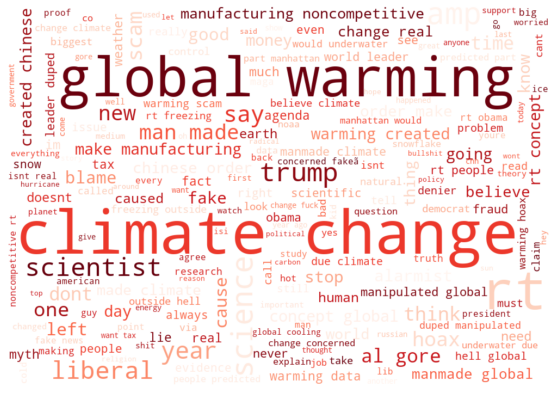

In [510]:
all_words = ' '.join([text for text in train[train['sentiment']==-1]['message']])
plotwordclouds(all_words)


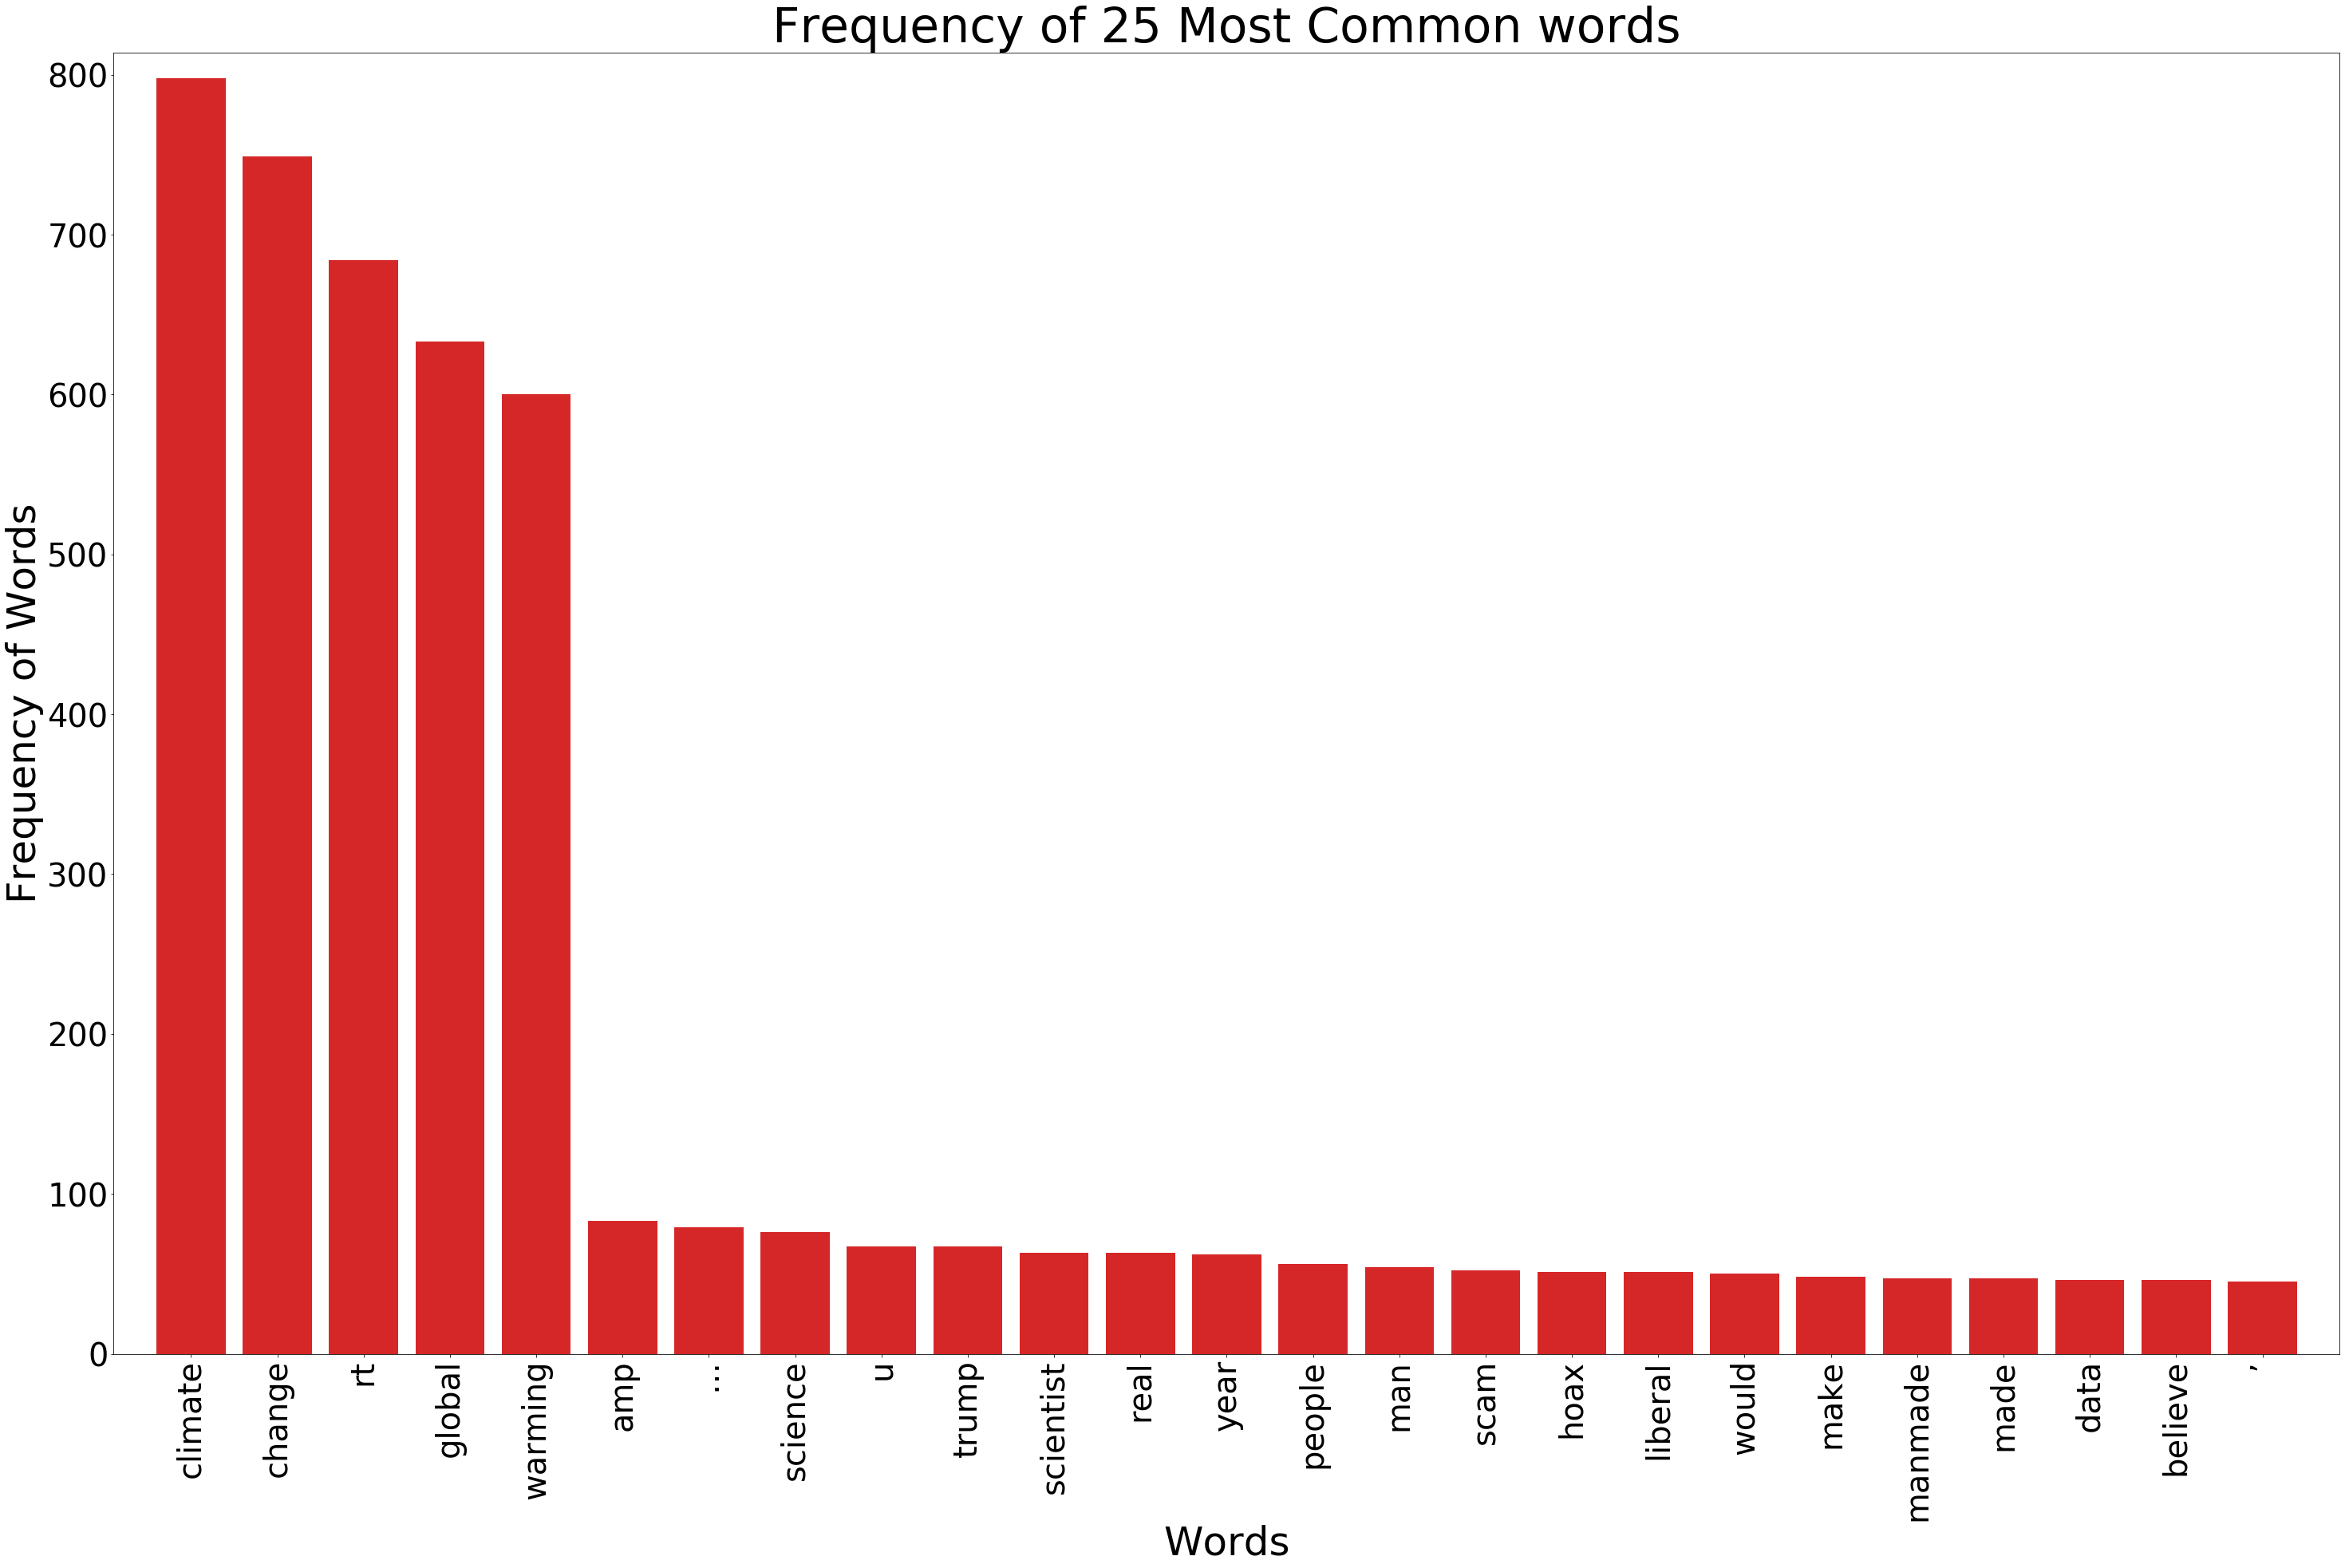

In [532]:
allwords = []
for wordlist in train[train['sentiment'] == -1]['clean_tokens']:
    allwords += wordlist
    train[train['sentiment'] == -1]['clean_tokens']

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Most common nouns 

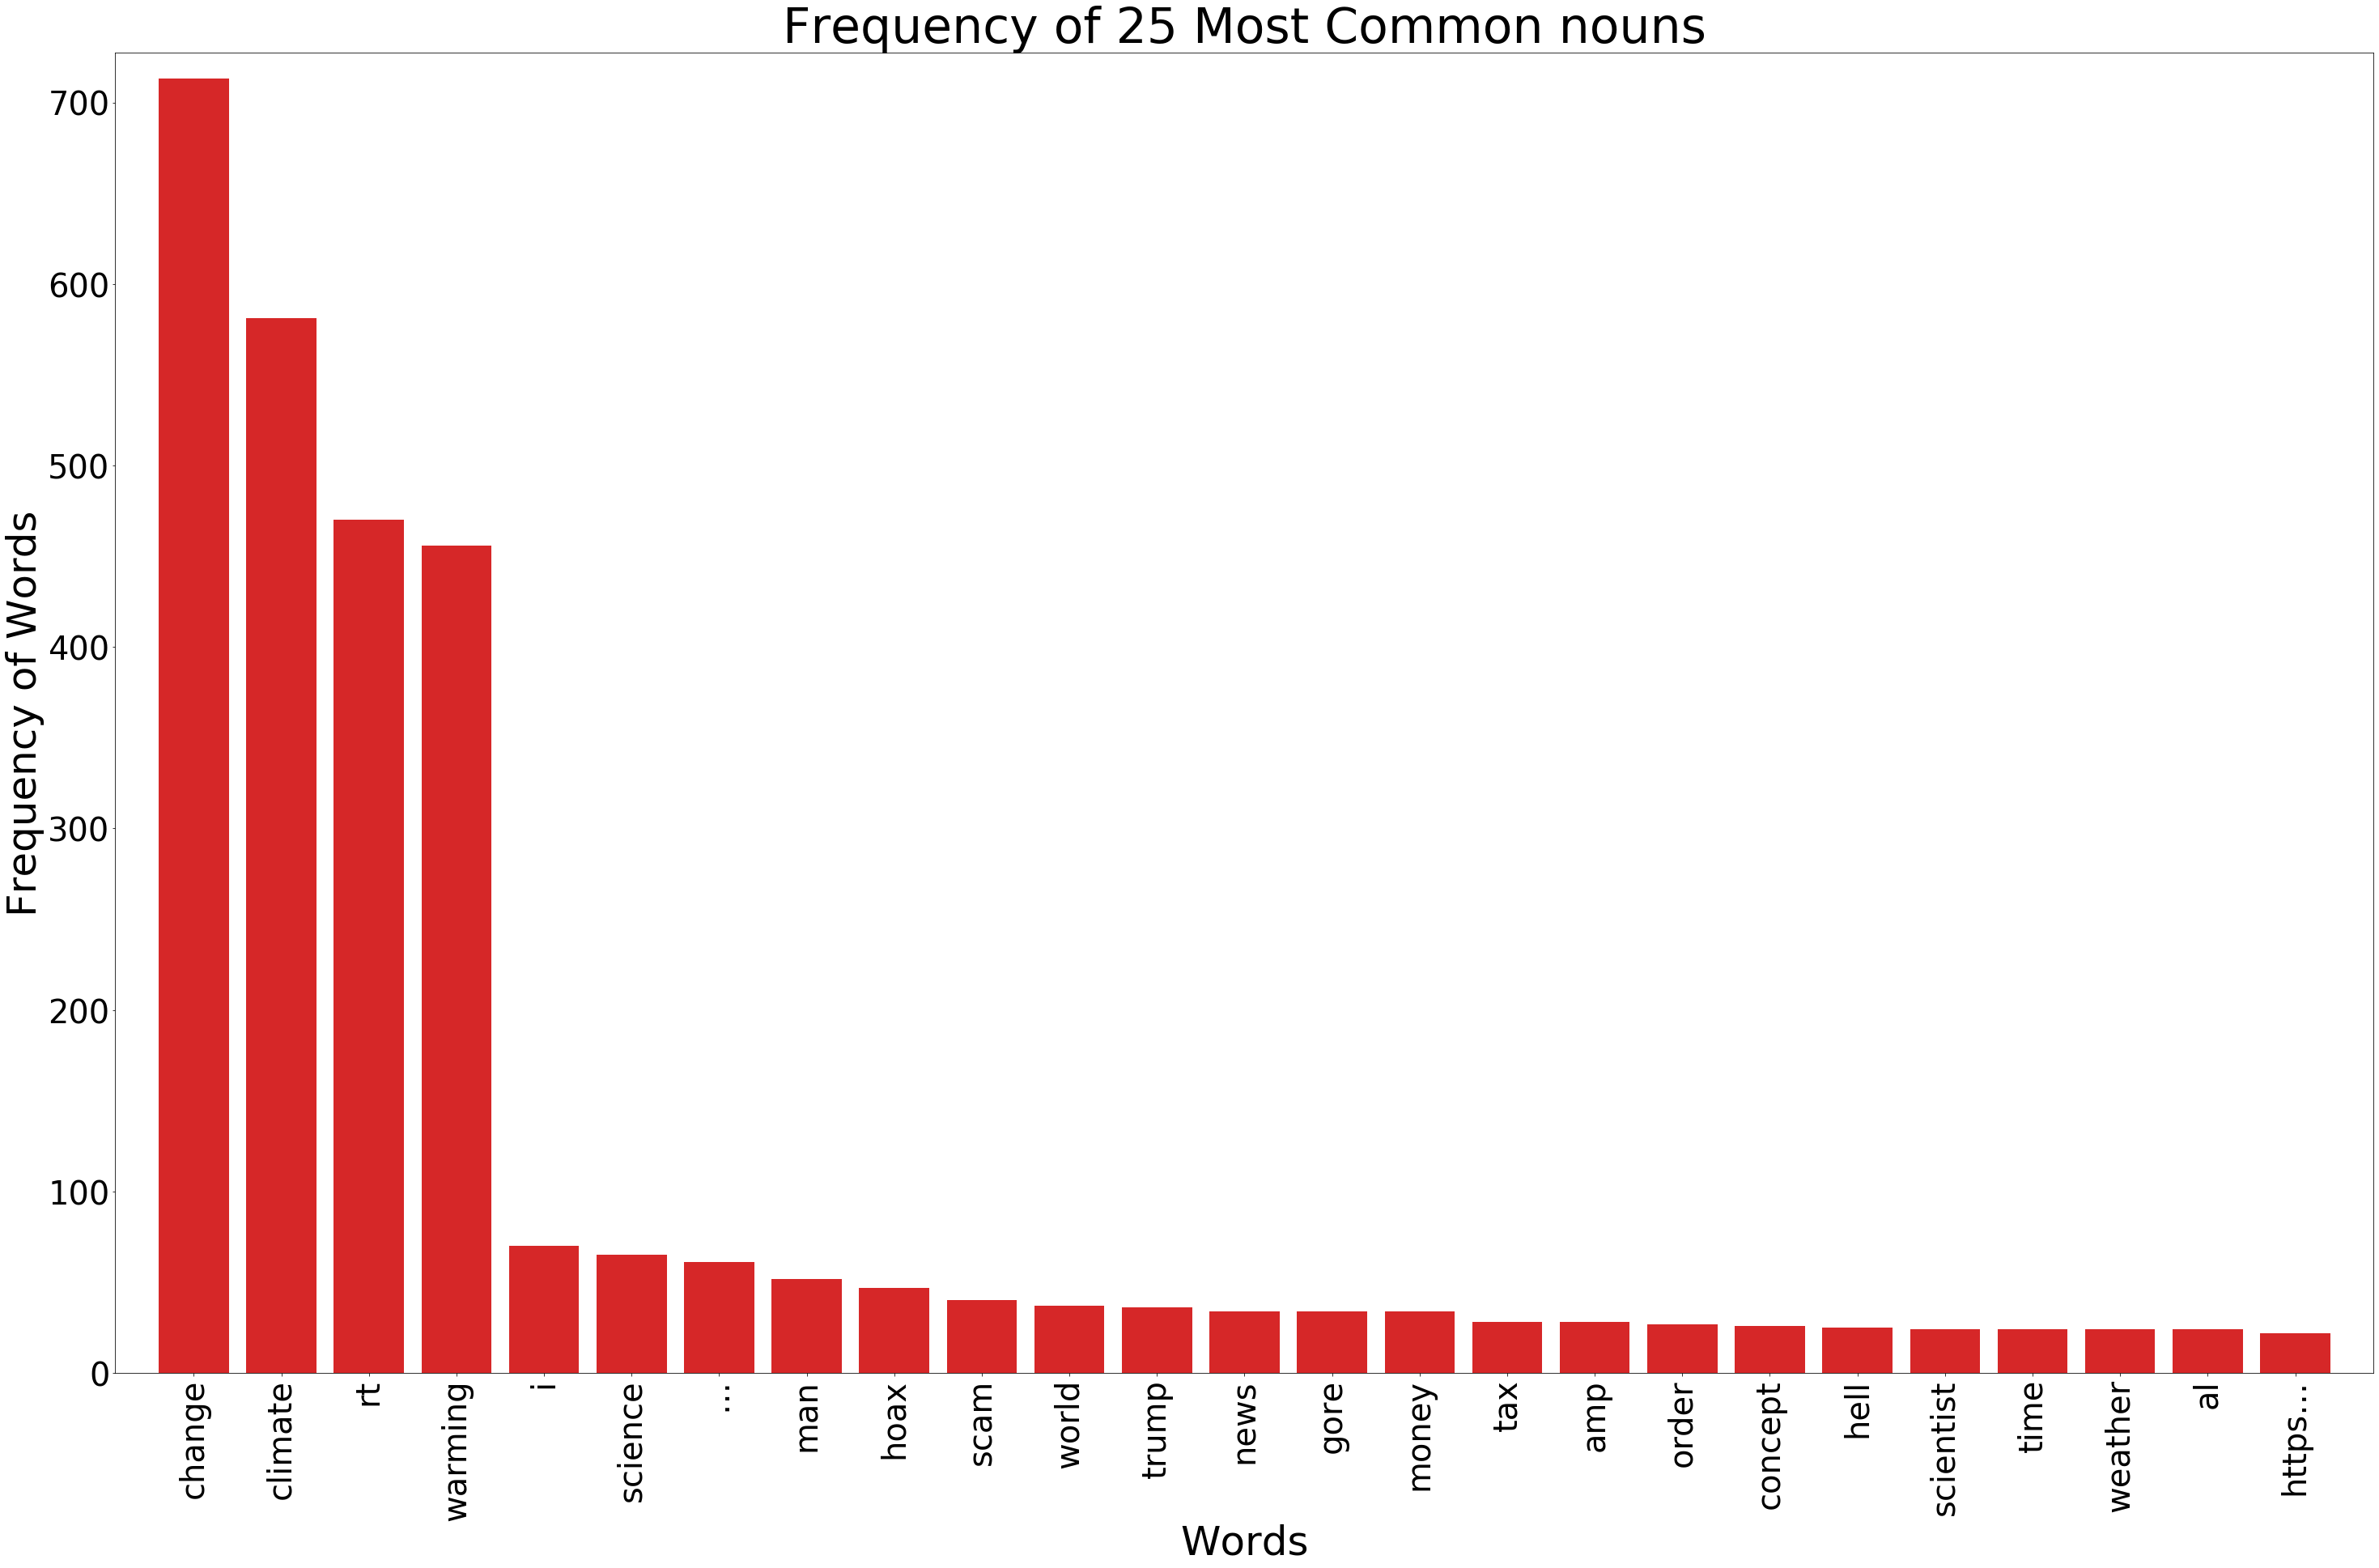

In [534]:
allnouns = []
for wordlist in train[train['sentiment'] == -1]['POS_nouns']:
    allnouns += wordlist

plot_most_frequent(allnouns,'Frequency of 25 Most Common nouns')


### Most common verbs

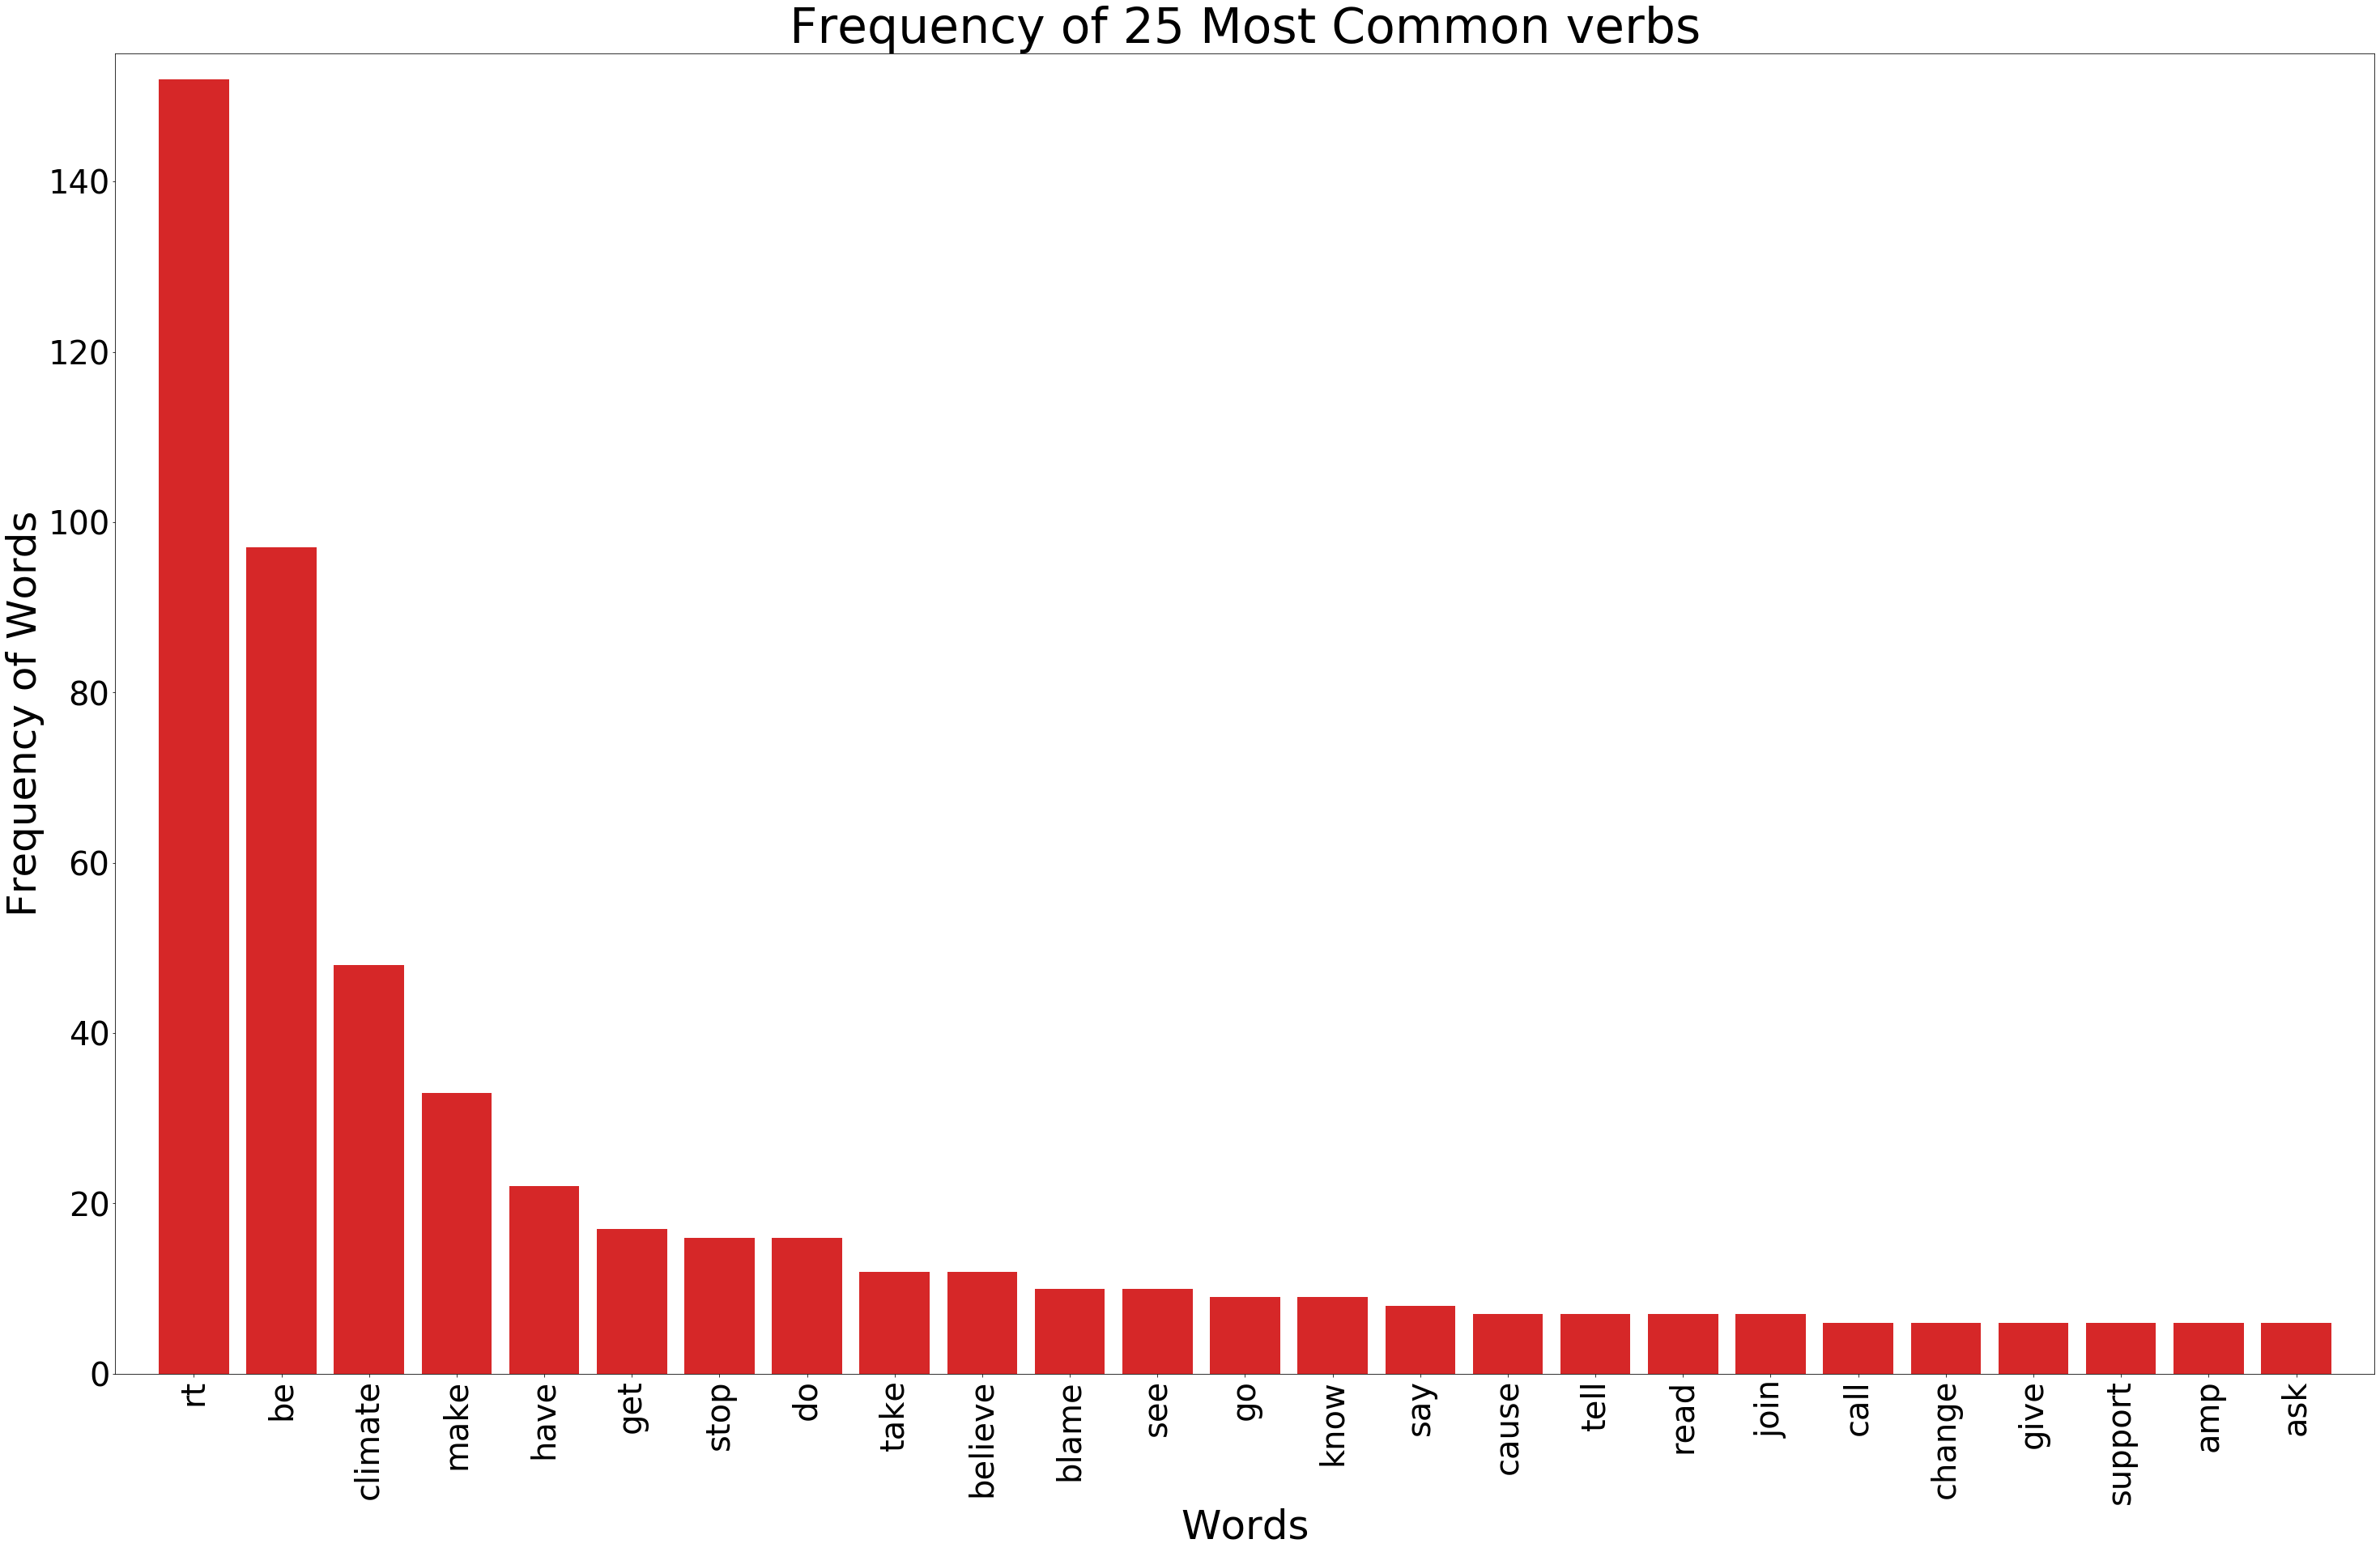

In [533]:
allverbs = []
for wordlist in train[train['sentiment']==-1]['POS_verbs']:
    allverbs += wordlist

plot_most_frequent(allverbs,'Frequency of 25 Most Common verbs')


### Visualising bi-grams

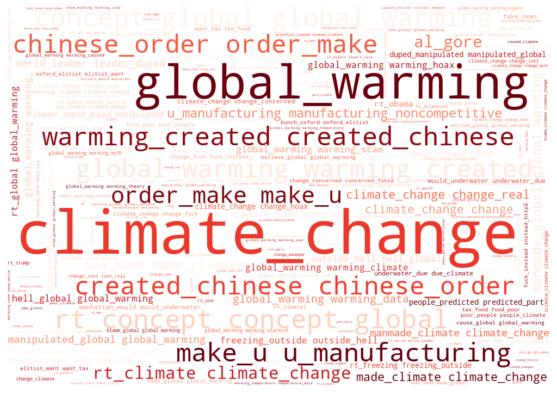

In [357]:
all_words = ' '.join([text for text in train[train['sentiment'] == -1]['bigrams_text']])
plotwordclouds(all_words)


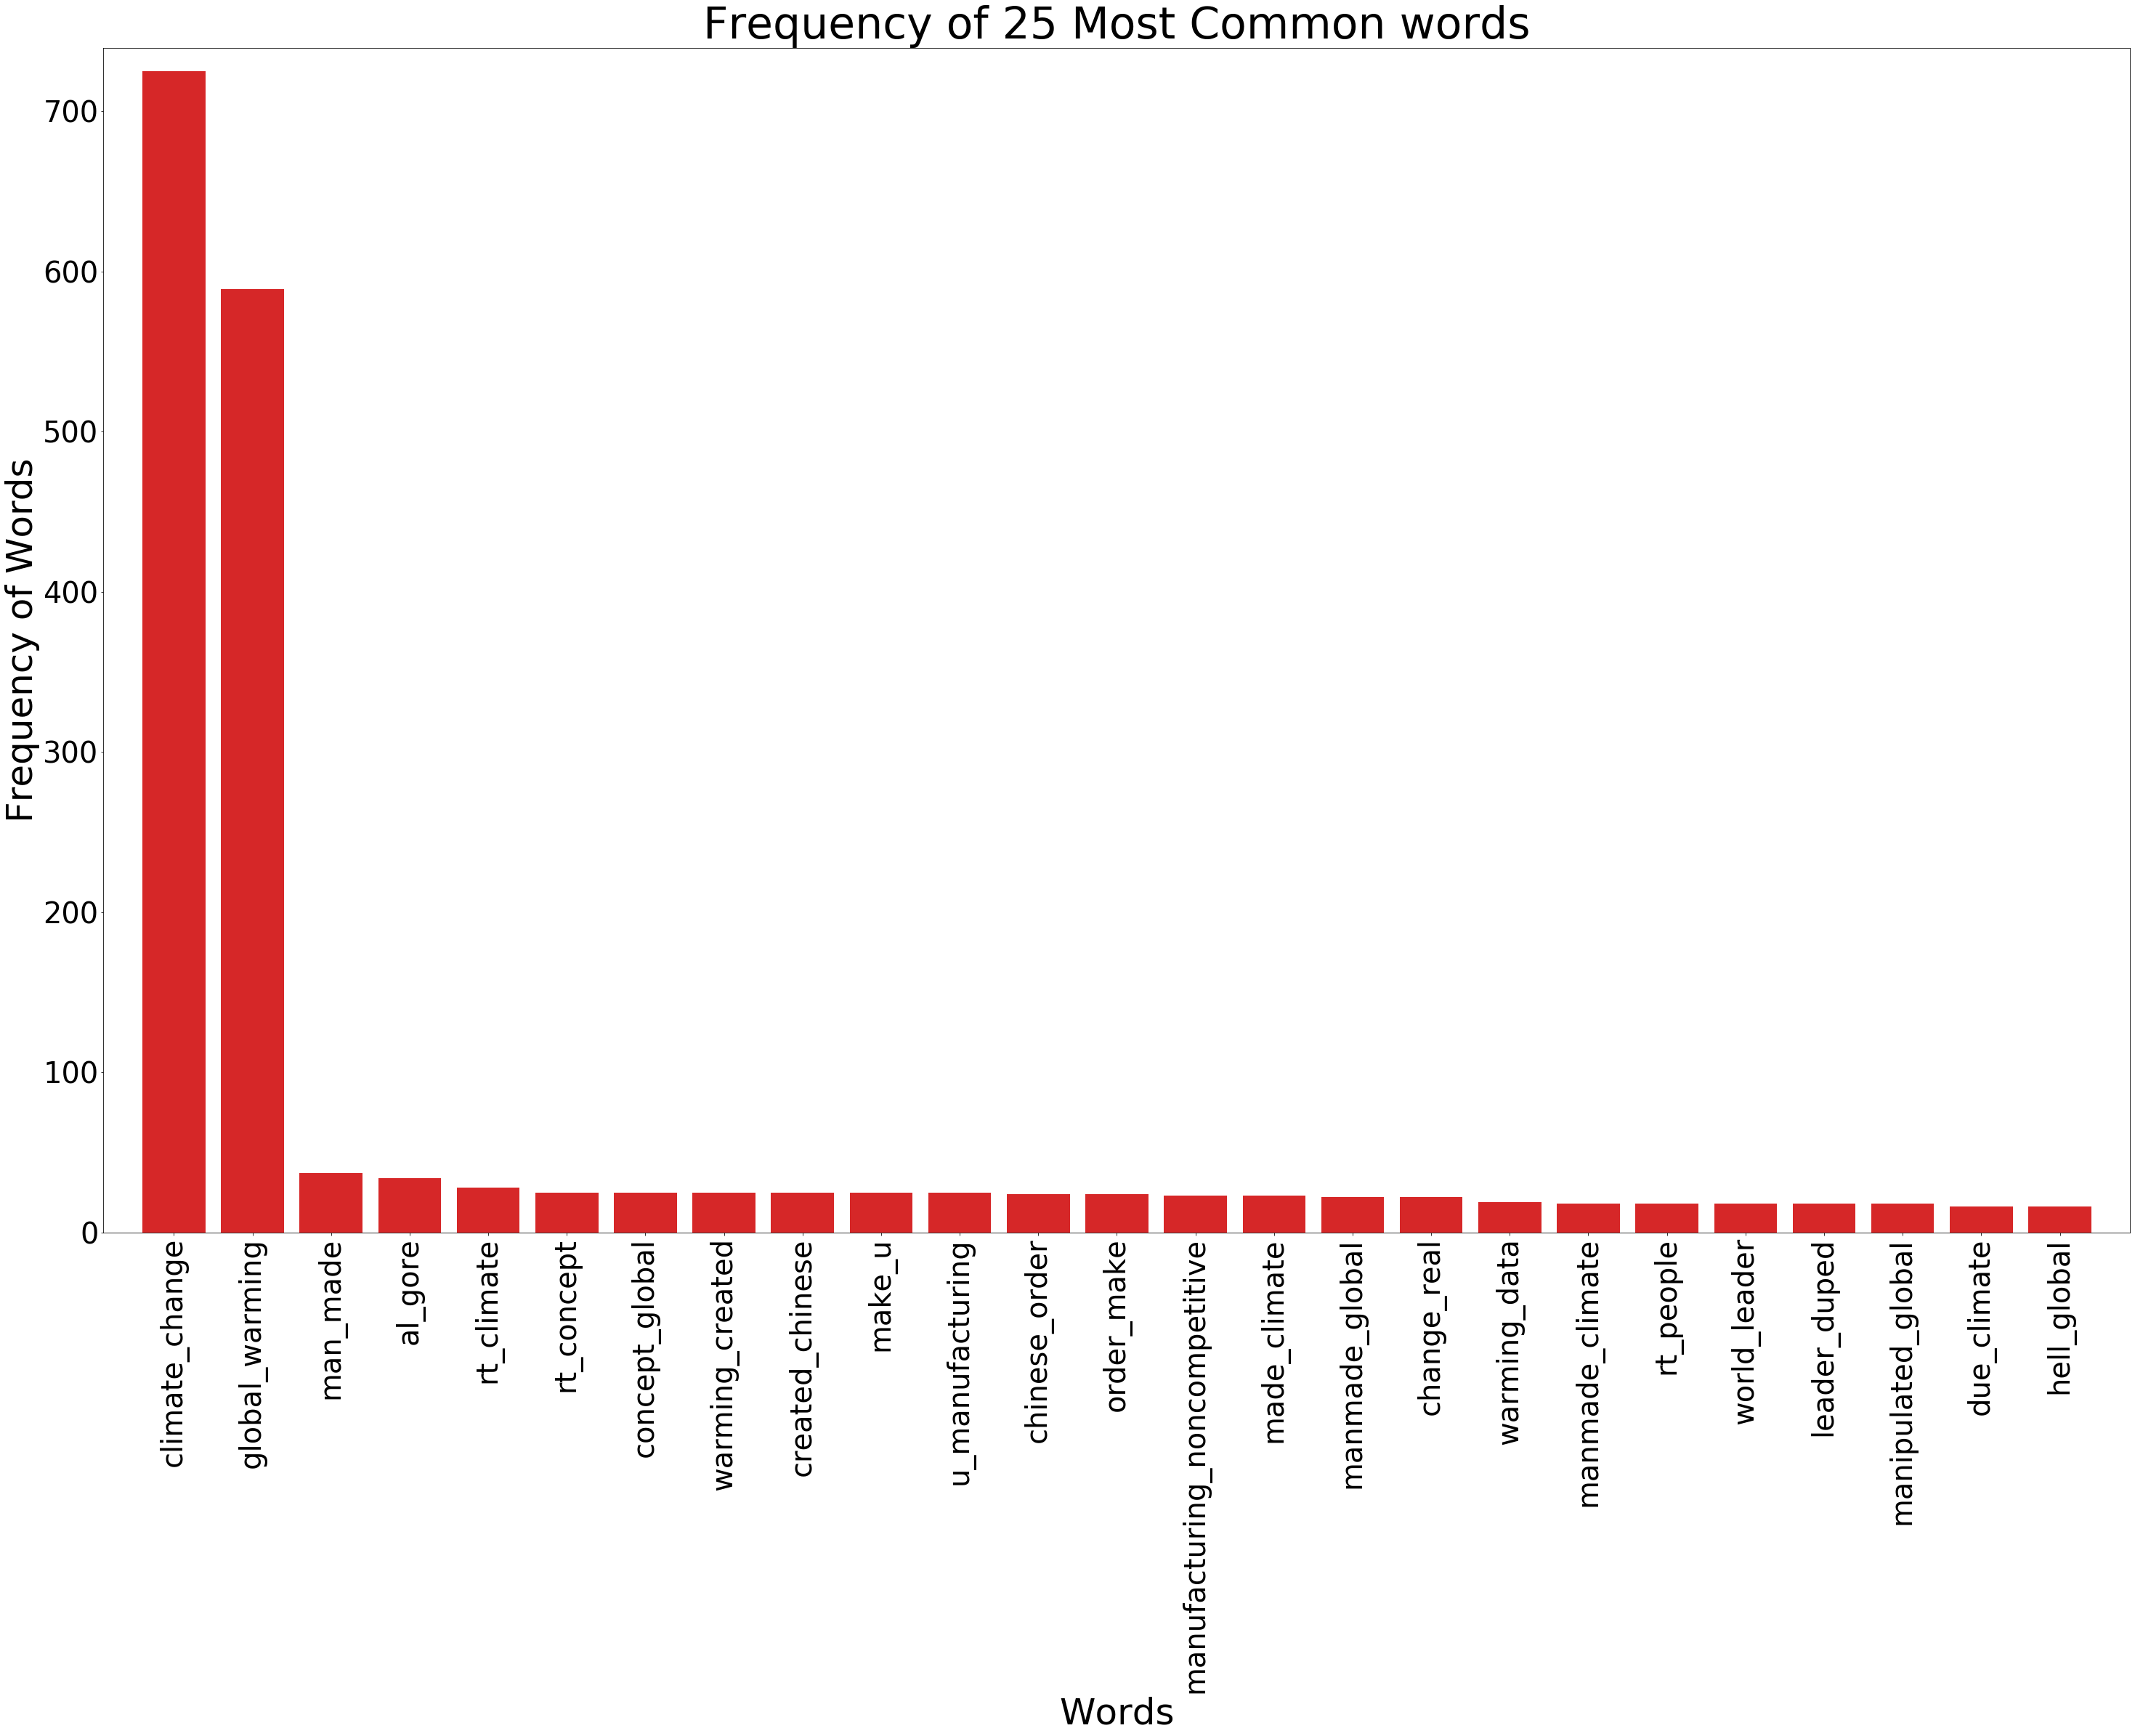

In [358]:
allwords = []
for wordlist in train[train['sentiment'] == -1]['bigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Visualising tri-grams

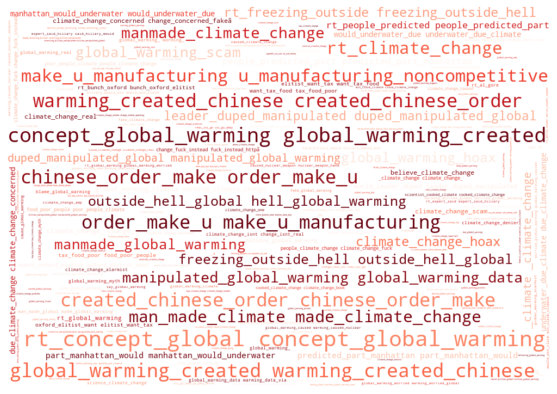

In [359]:
all_words = ' '.join([text for text in train[train['sentiment'] == -1]['trigrams_text']])
plotwordclouds(all_words)


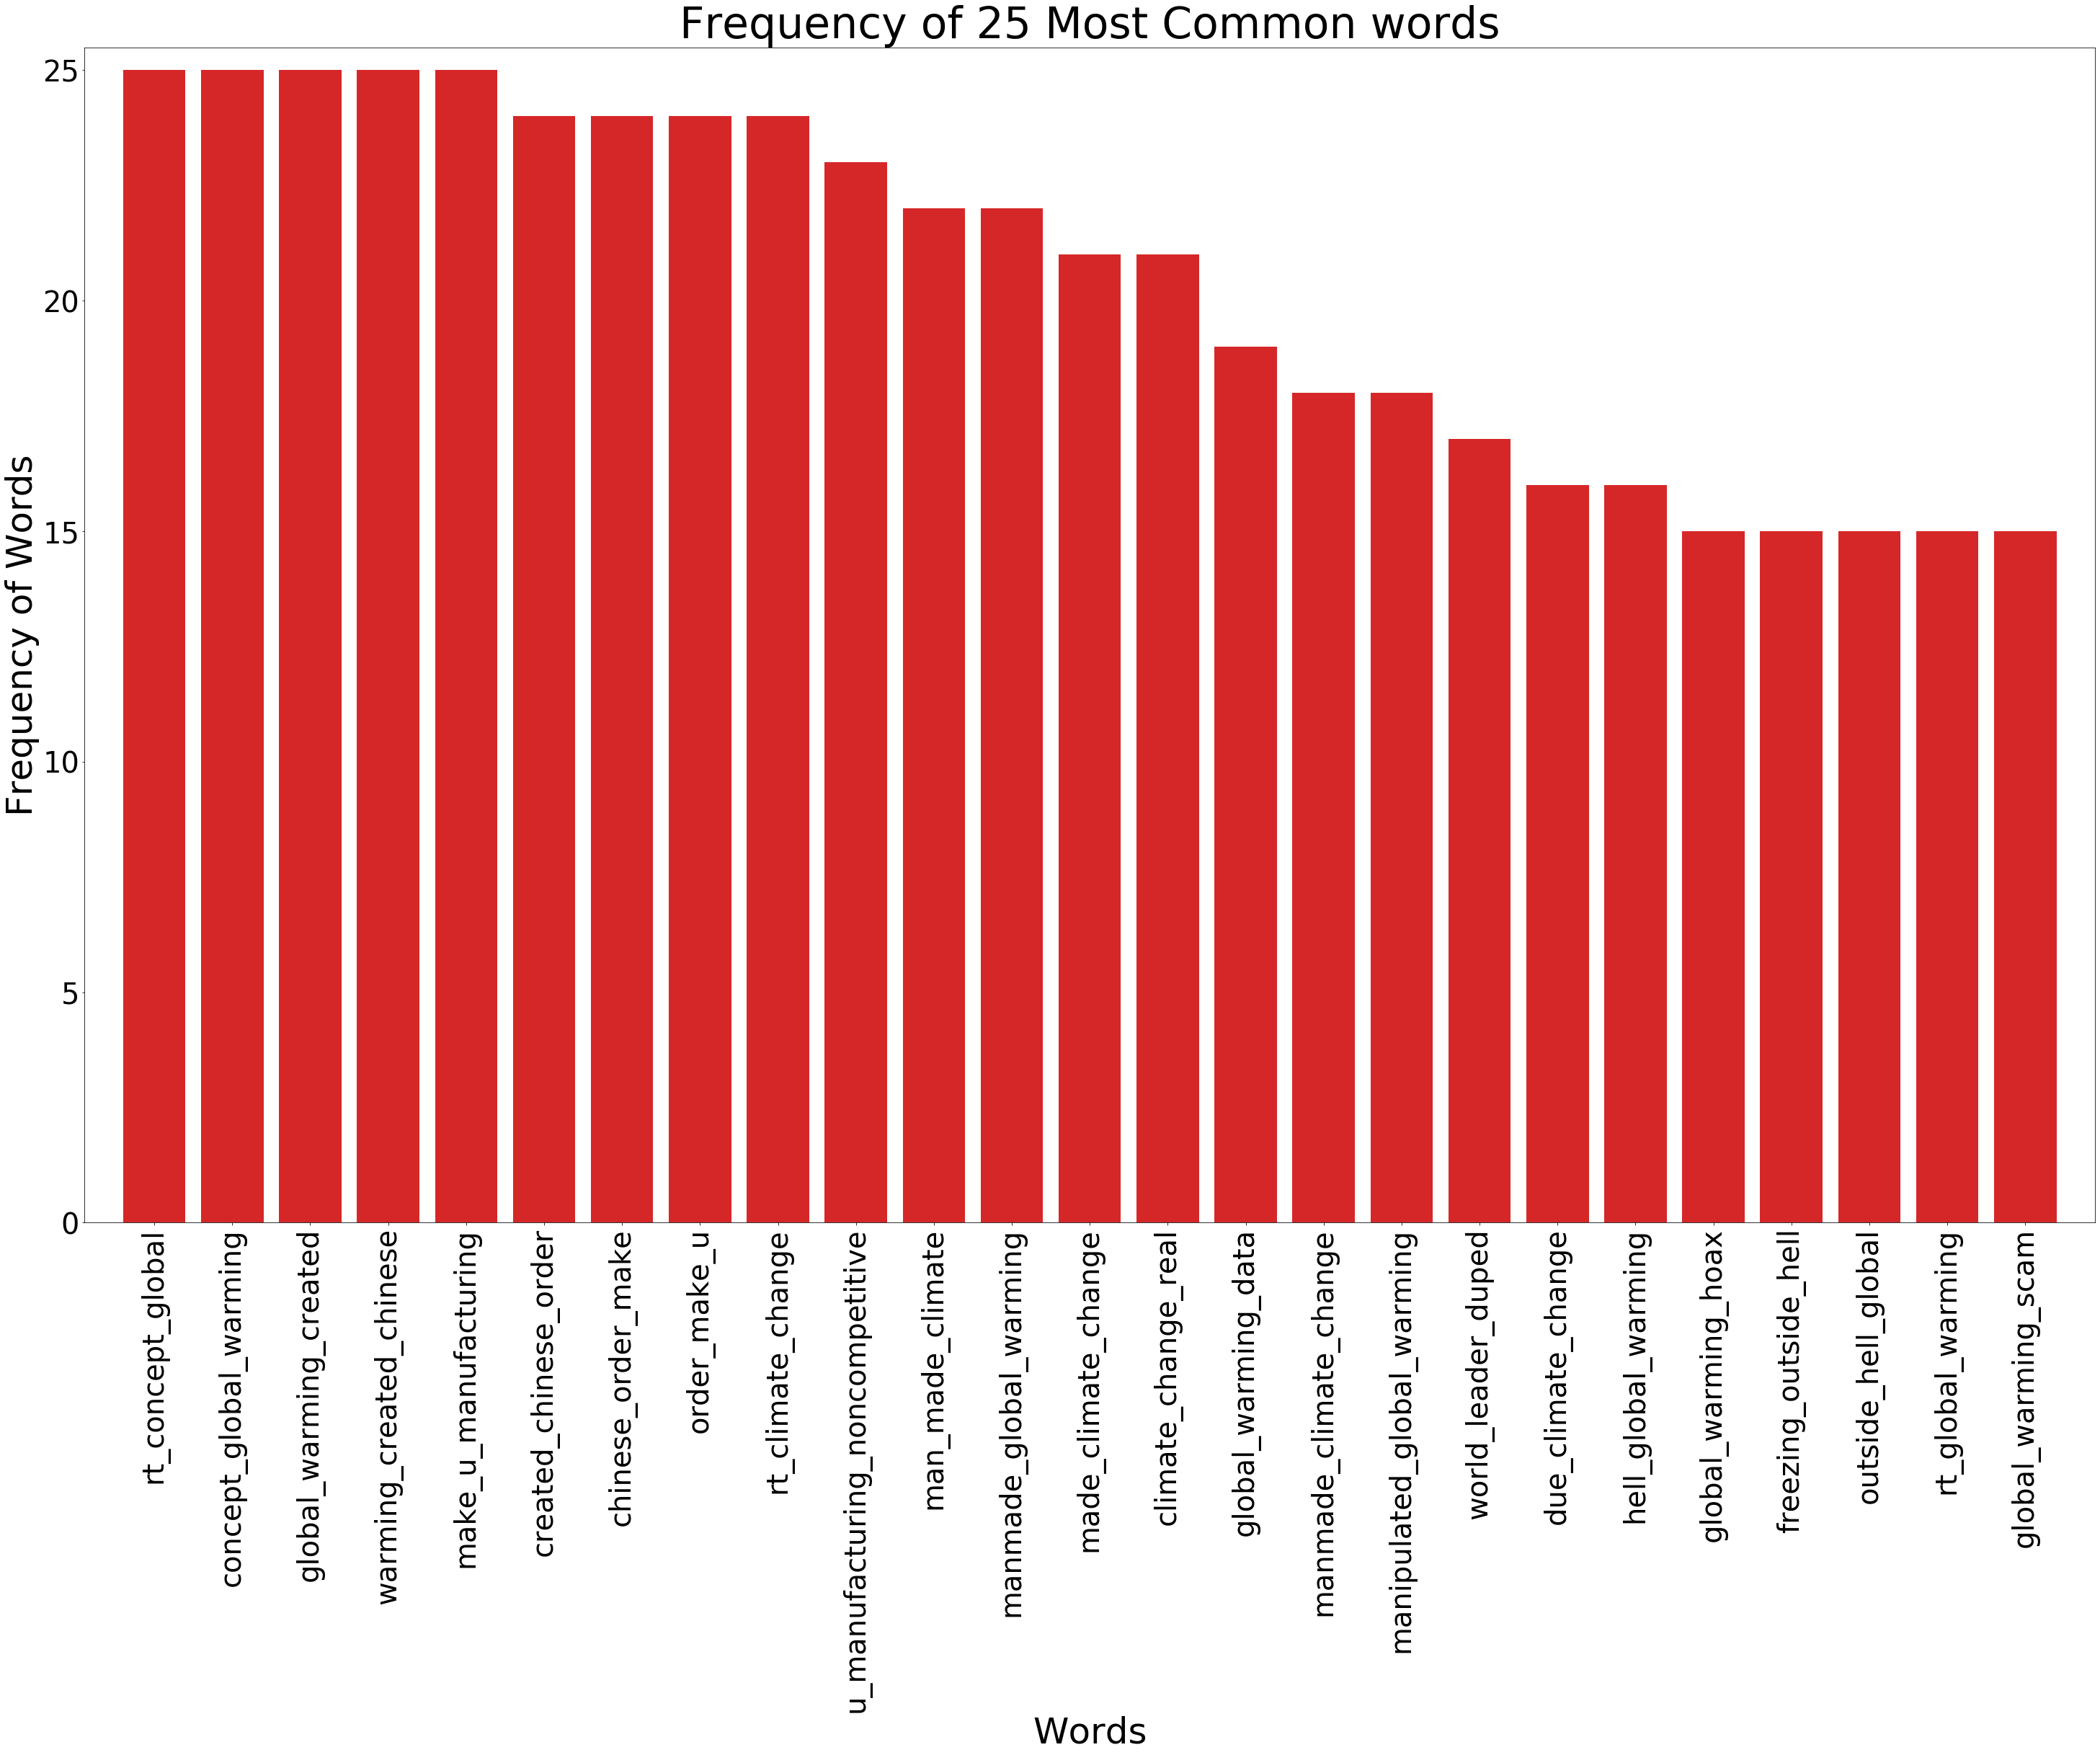

In [360]:
allwords = []
for wordlist in train[train['sentiment'] == -1]['trigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords,'Frequency of 25 Most Common words')


## For tweets in the class "0" 

In [515]:
for i in range(5):
    print(train[train['sentiment'] == 0]['message'].iloc[i] + '\n')


calum tweet abt reunitingish w cast see reply begging come country calum go back rting climate change

also met guy let u truth climate change gay people existing

scientist denounce climate change choice

’ dealt simple issue like climate change energy policy complex issue mal v tone qanda

rt win probability bullshit man saw nba final thats knew global warming isnt real



### Most used words 

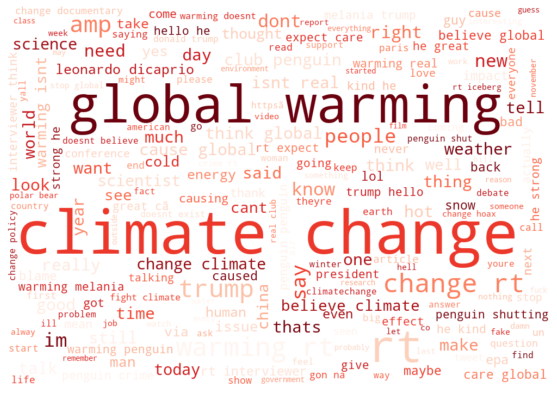

In [516]:
all_words = ' '.join([text for text in train[train['sentiment']==0]['message']])
plotwordclouds(all_words)

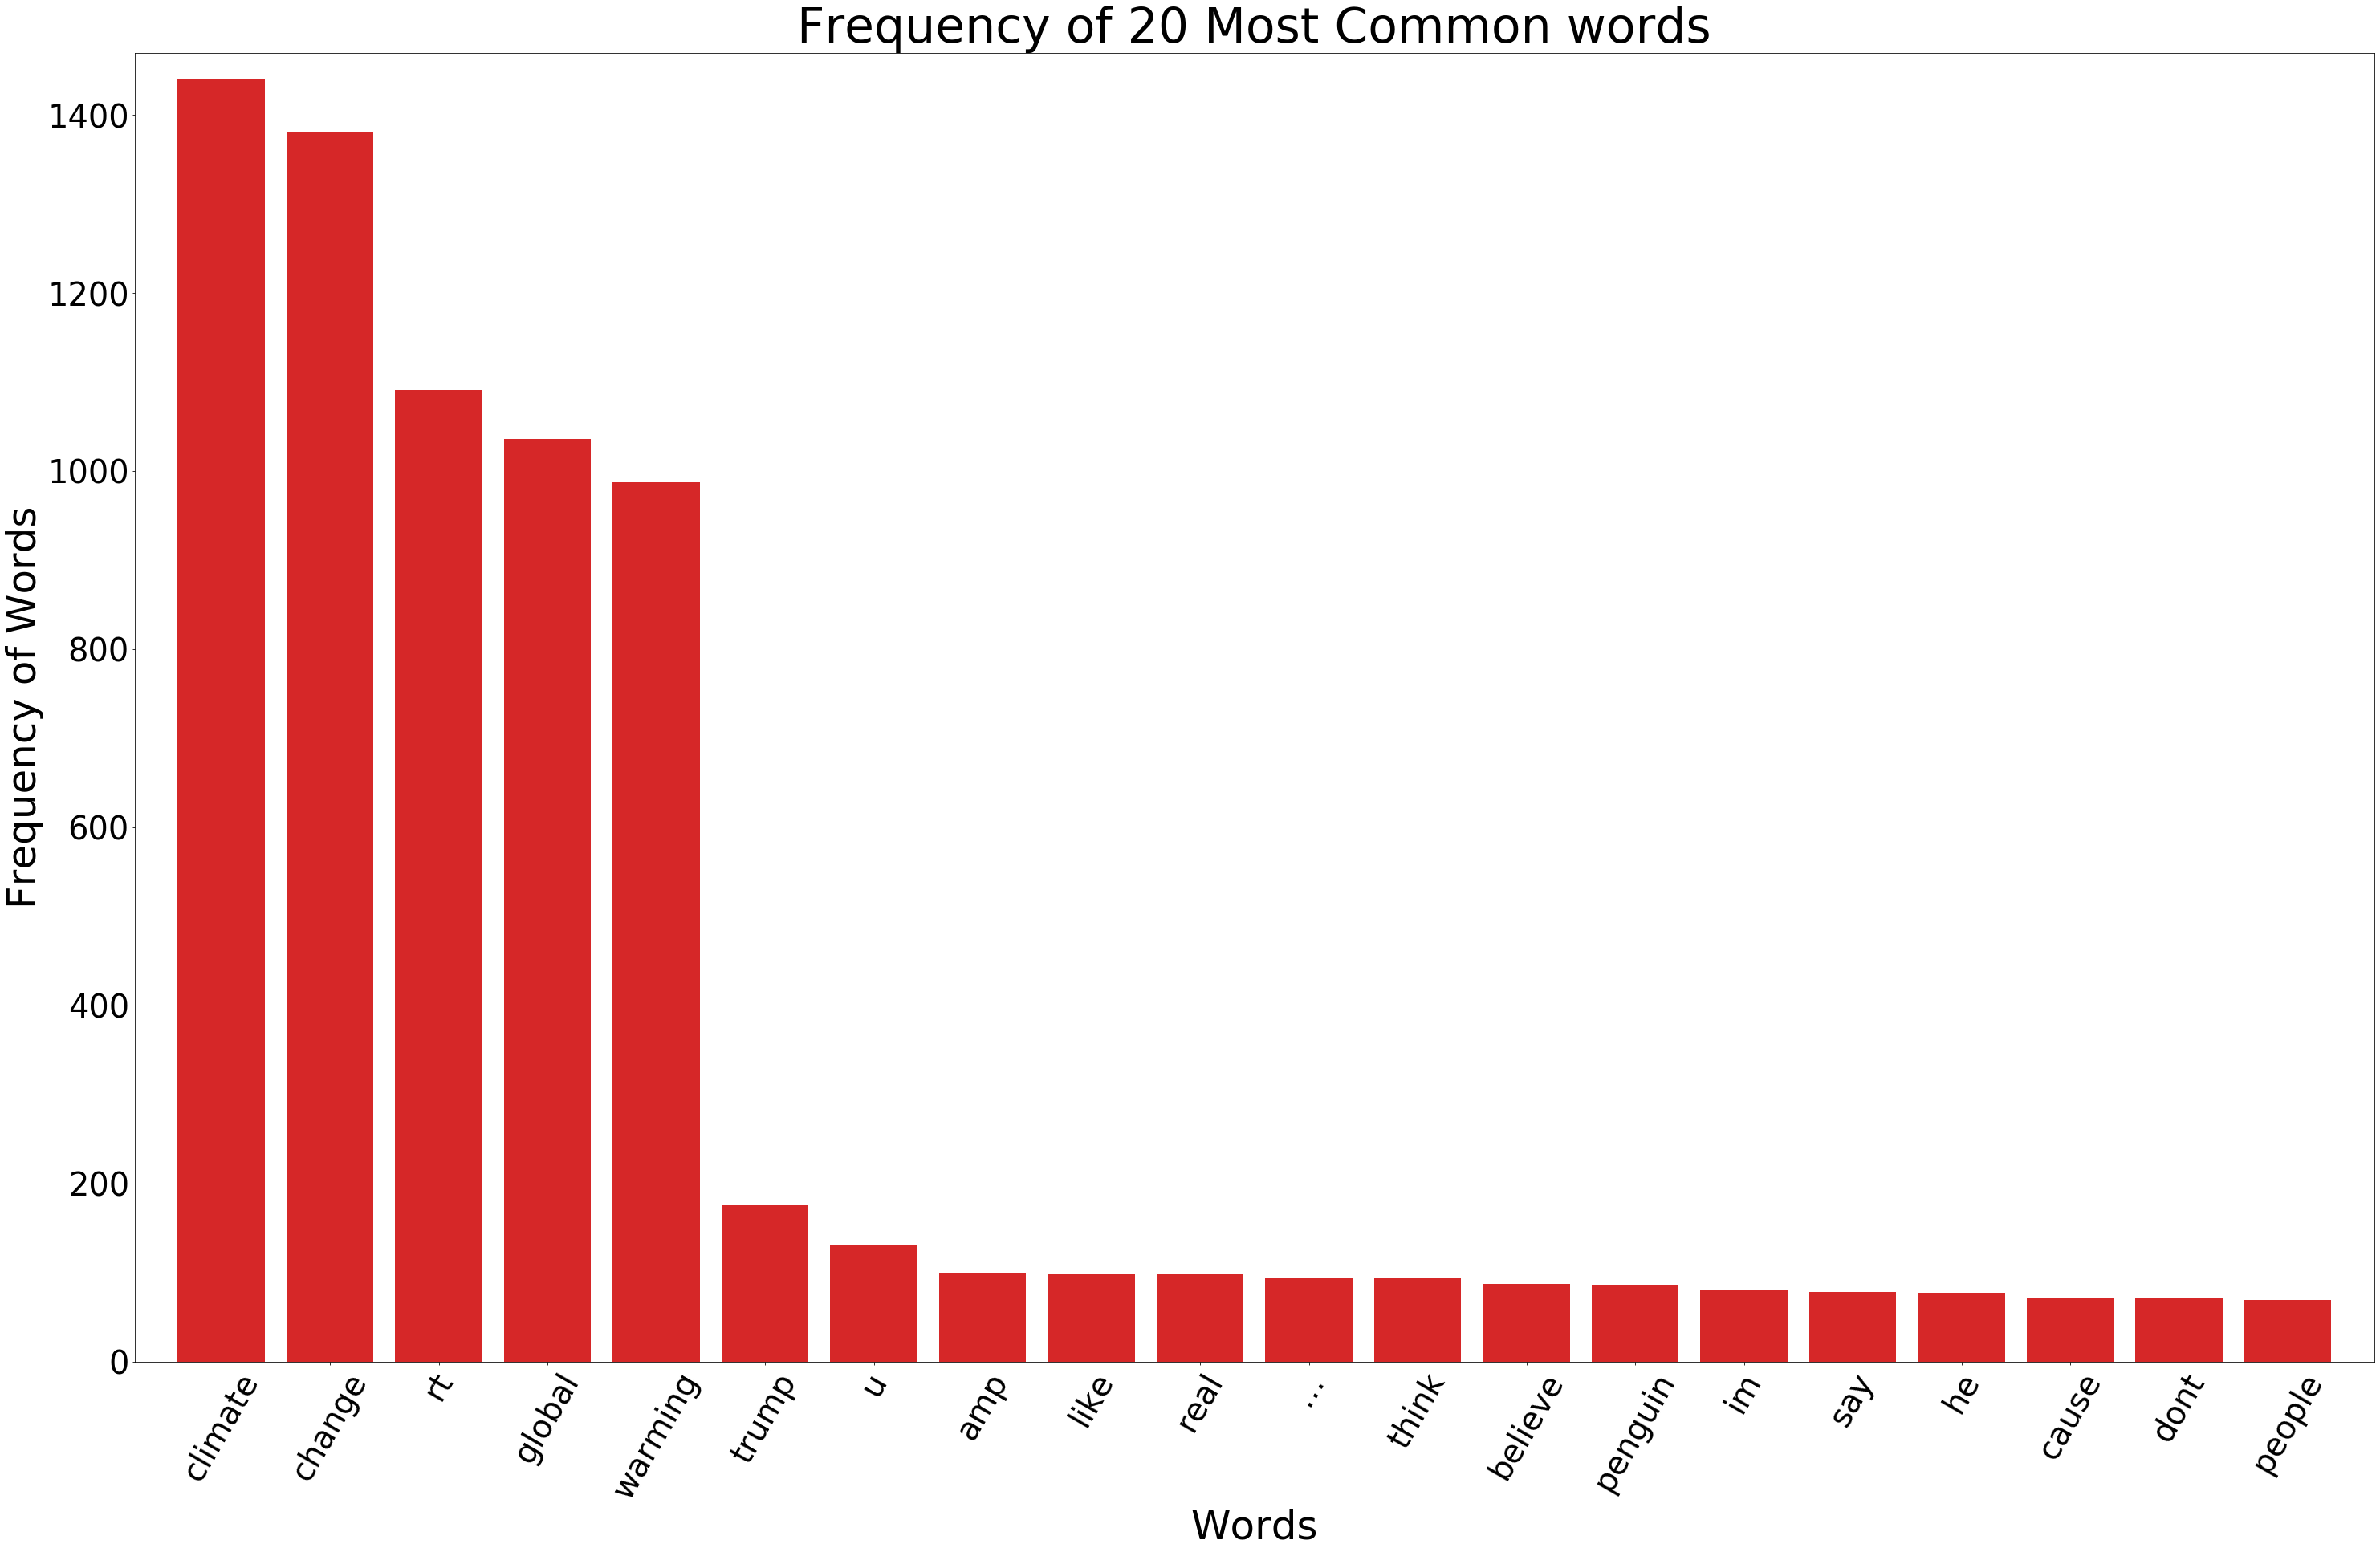

In [241]:
allwords = []
for wordlist in train[train['sentiment'] == 0]['clean_tokens']:
    allwords += wordlist
    train[train['sentiment'] == -1]['clean_tokens']

plot_most_frequent(allwords, 'Frequency of 20 Most Common words')


### Most common nouns

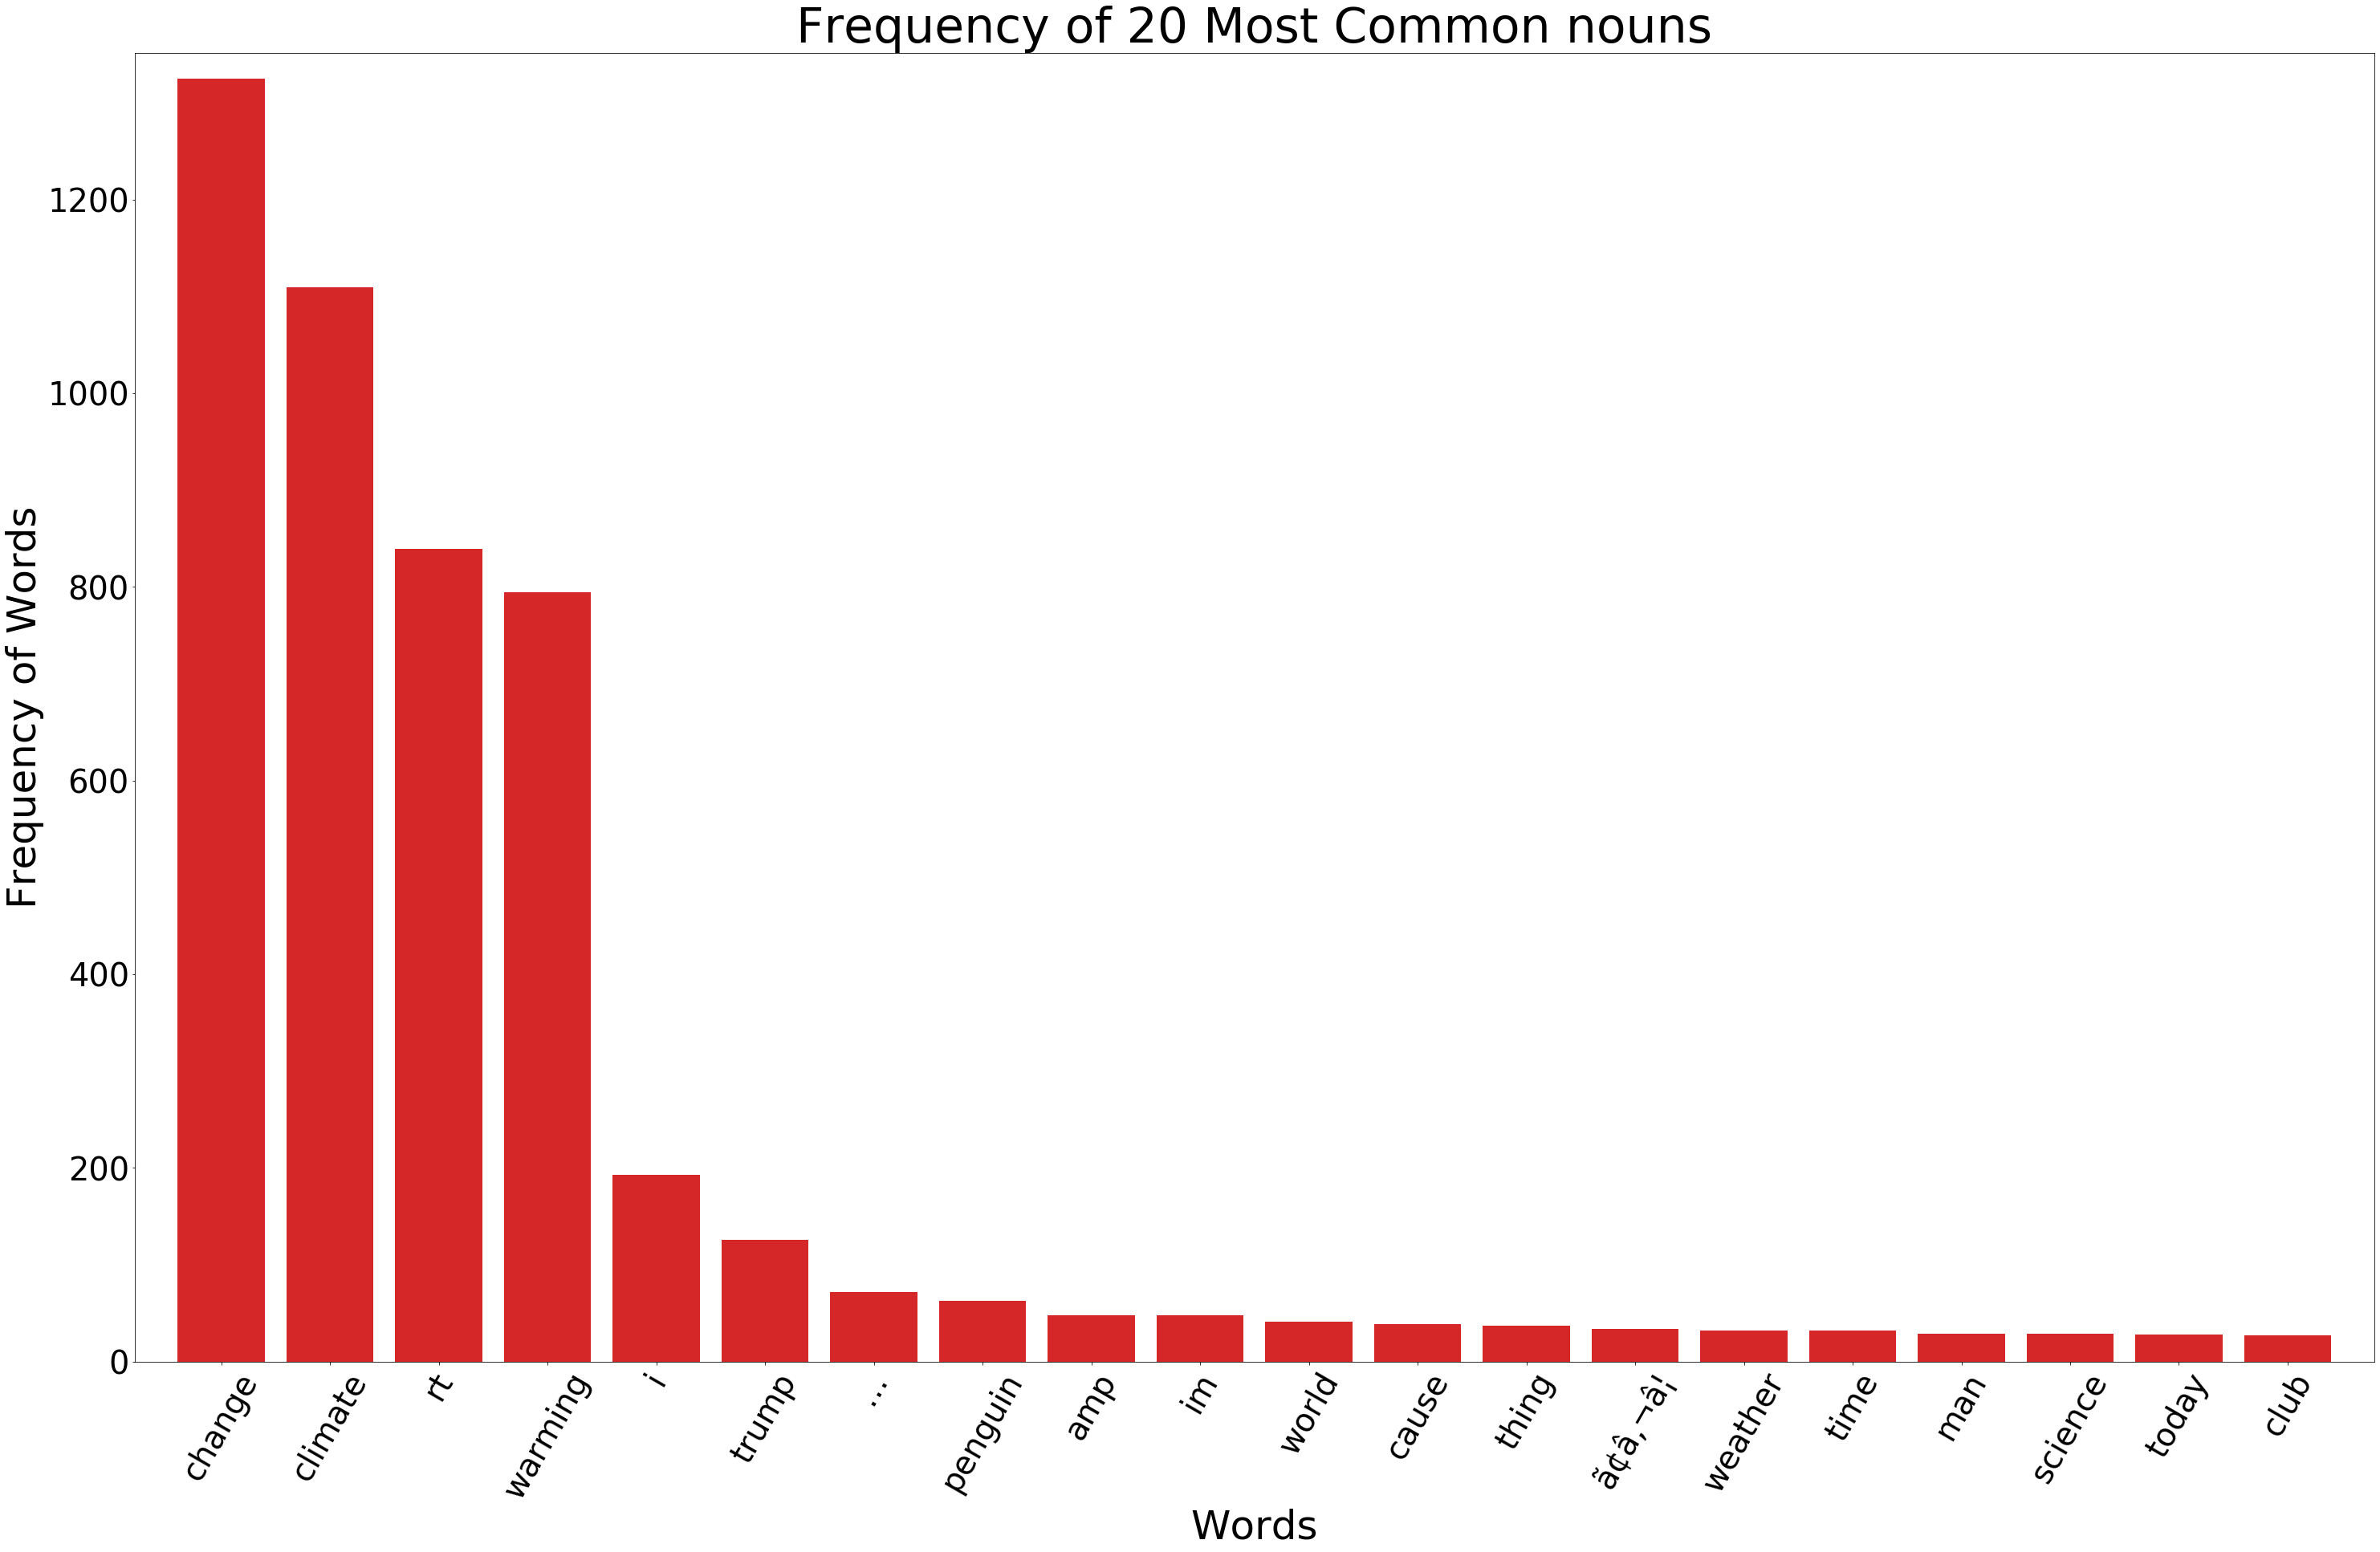

In [242]:
allnouns = []
for wordlist in train[train['sentiment'] == 0]['POS_nouns']:
    allnouns += wordlist

plot_most_frequent(allnouns,'Frequency of 20 Most Common nouns')


### Most common verbs

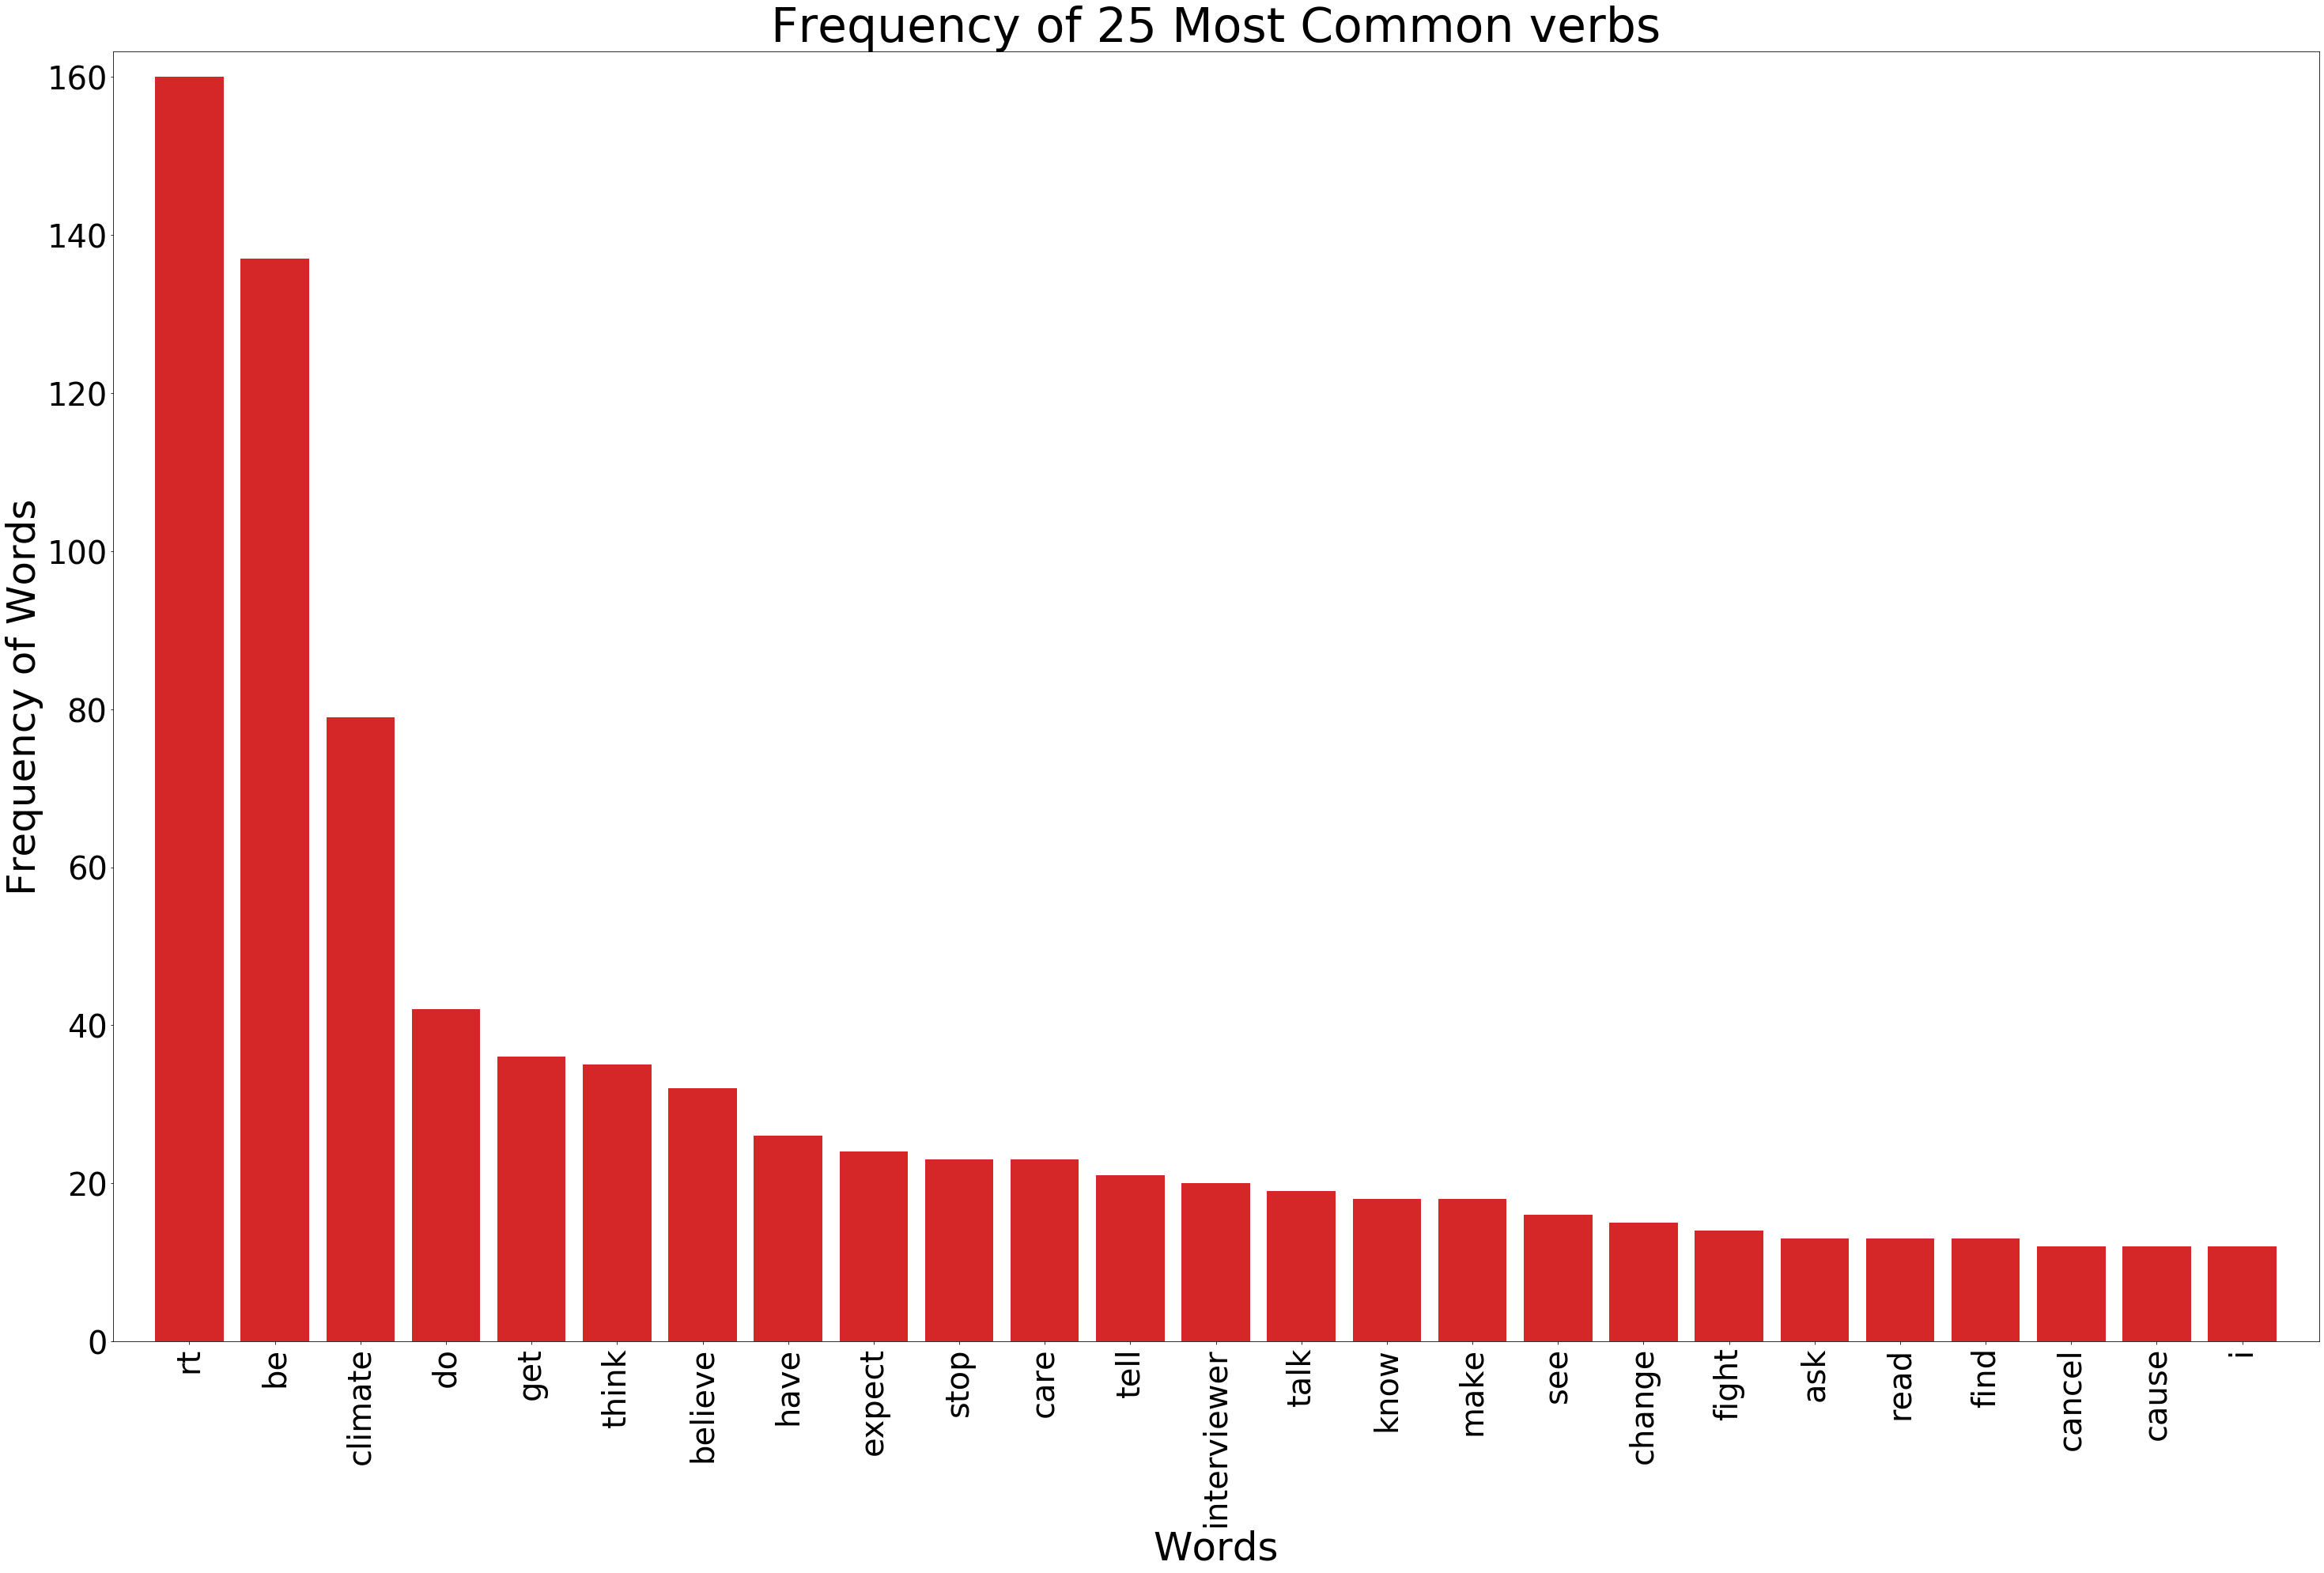

In [518]:
allverbs = []
for wordlist in train[train['sentiment'] == 0]['POS_verbs']:
    allverbs += wordlist

plot_most_frequent(allverbs, 'Frequency of 25 Most Common verbs')


### Visualising bi-grams

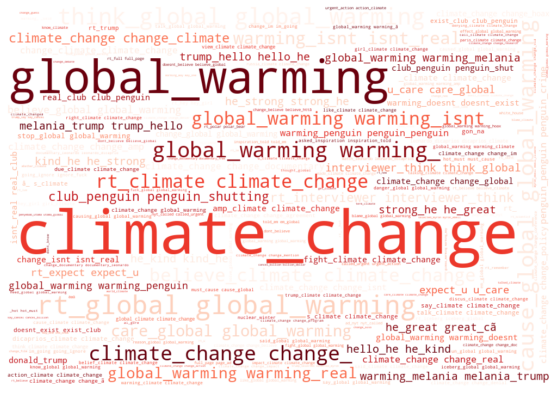

In [521]:
all_words = ' '.join([text for text in train[train['sentiment']==0]['bigrams_text']])
plotwordclouds(all_words)

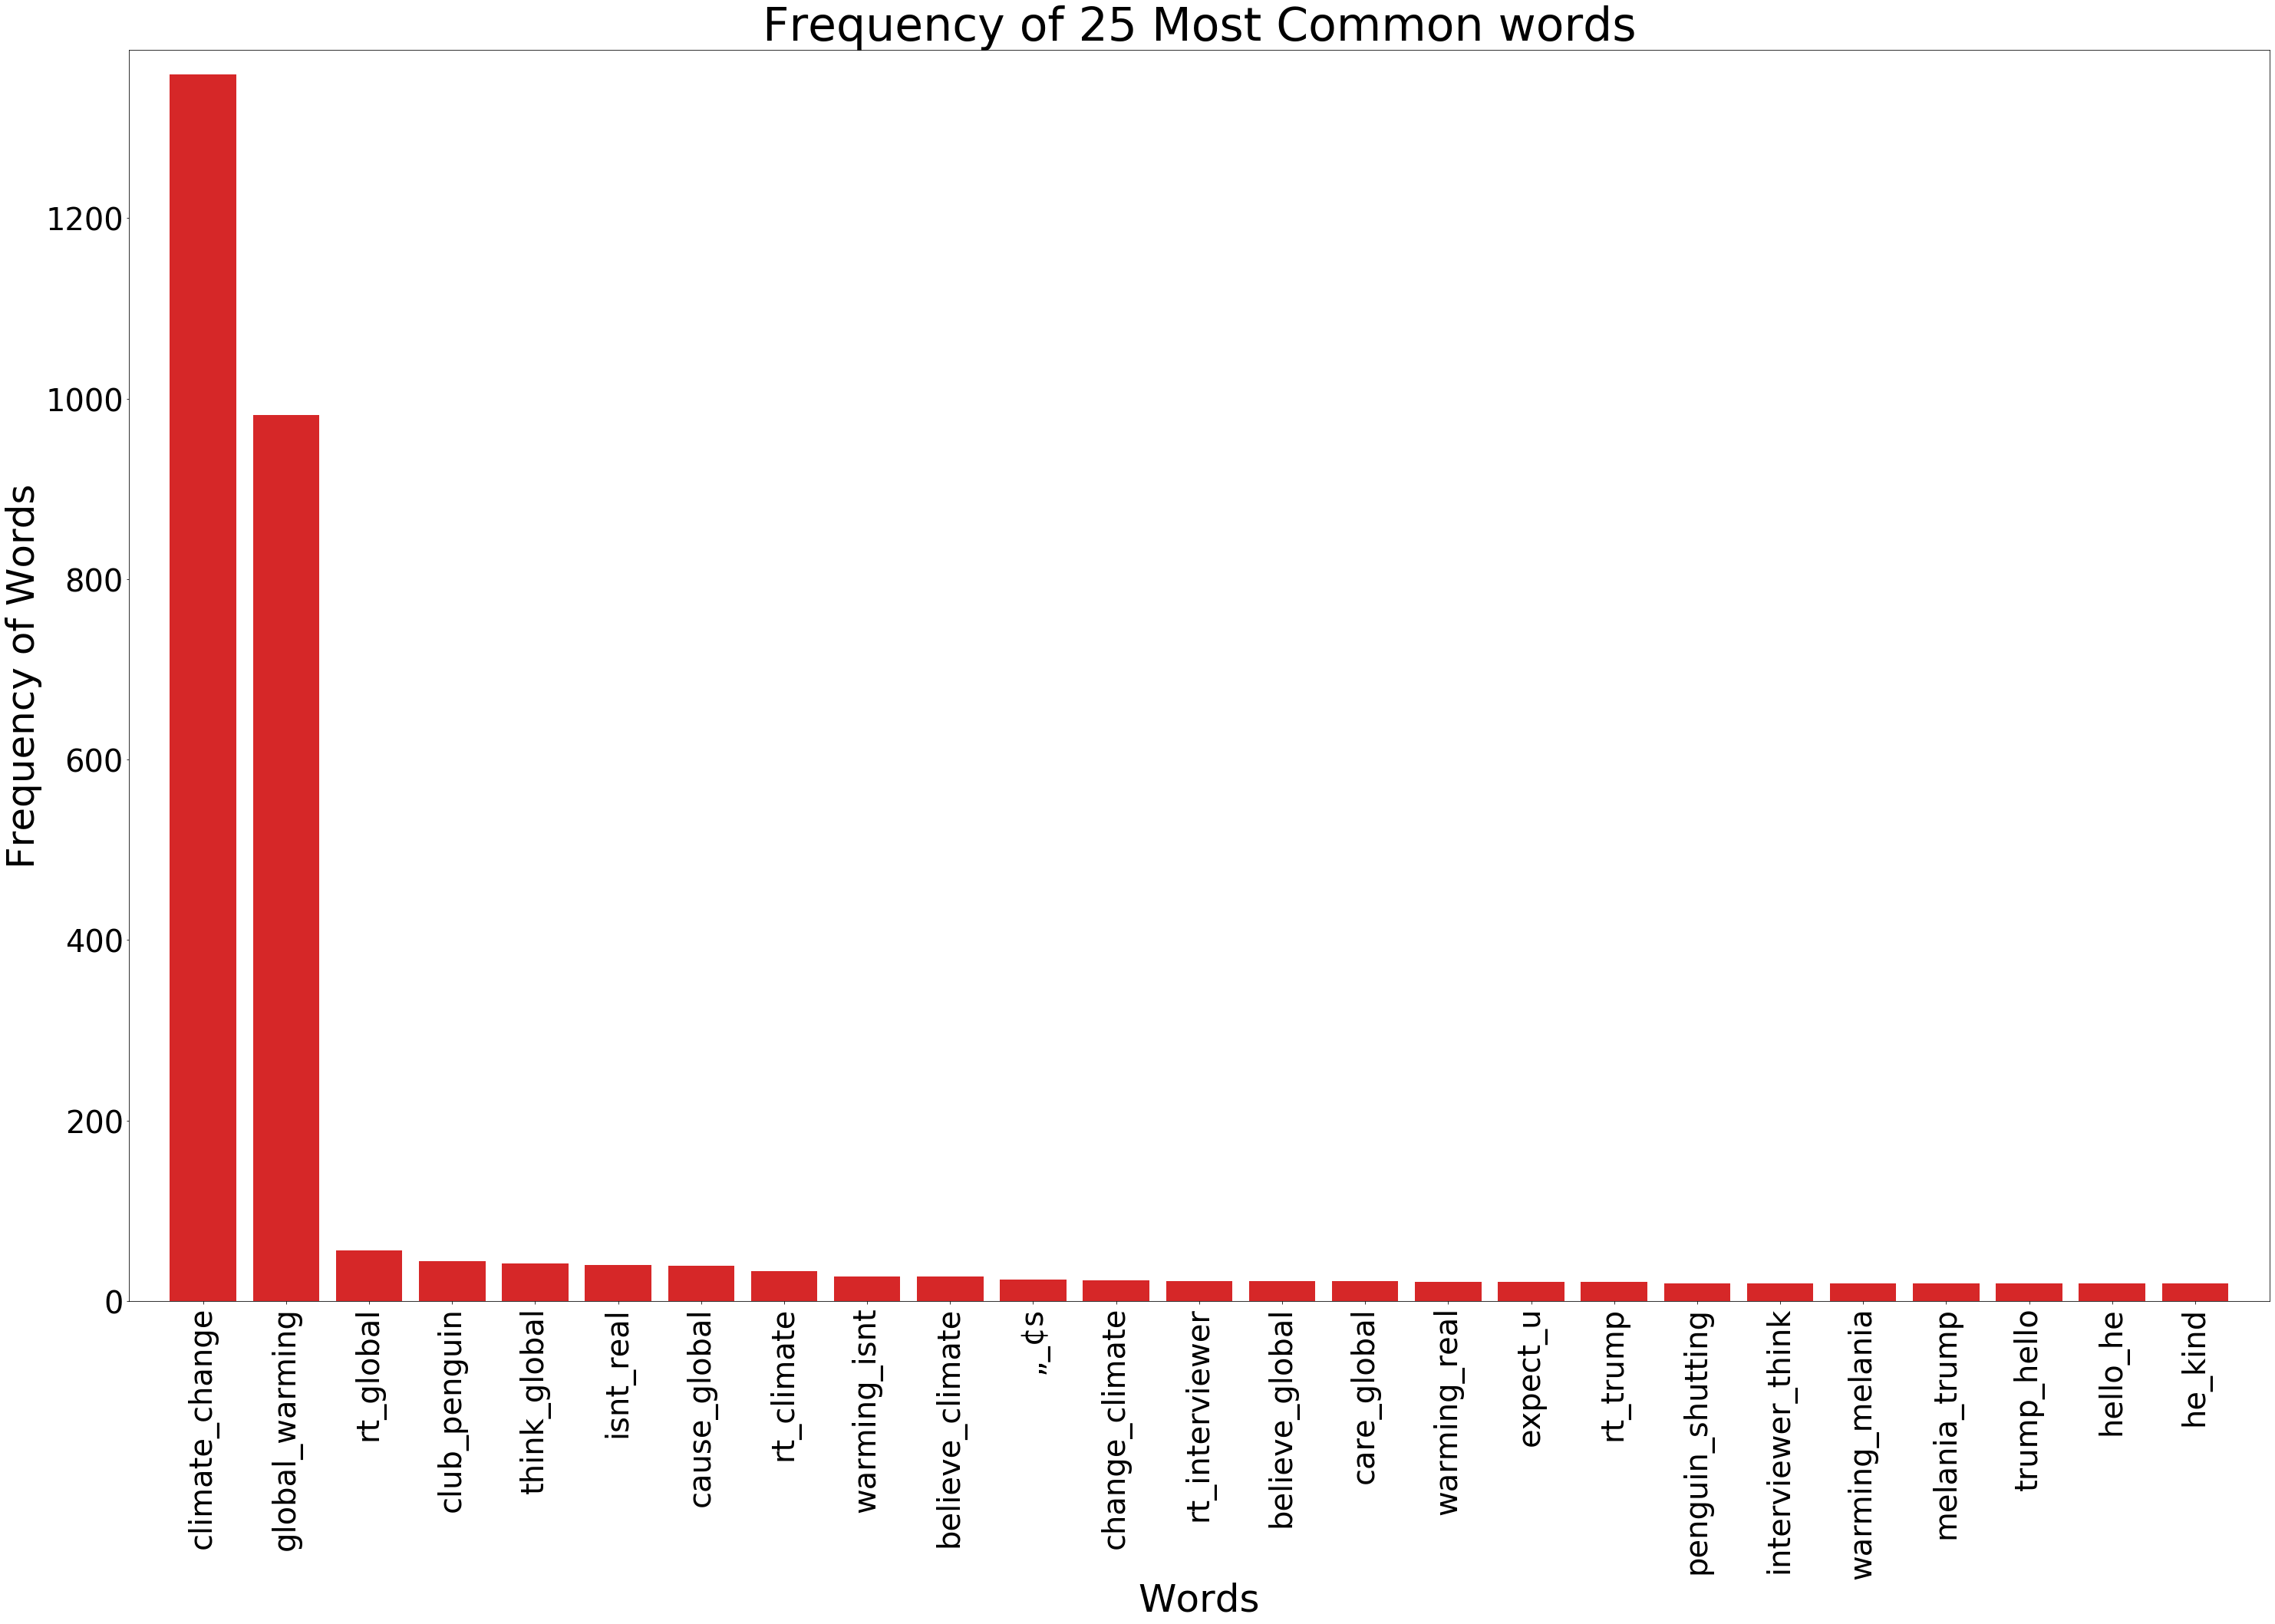

In [522]:
allverbs = []
for wordlist in train[train['sentiment'] == 0]['POS_verbs']:
    allverbs += wordlist

plot_most_frequent(allverbs, 'Frequency of 25 Most Common verbs')


### Visualising tri-grams

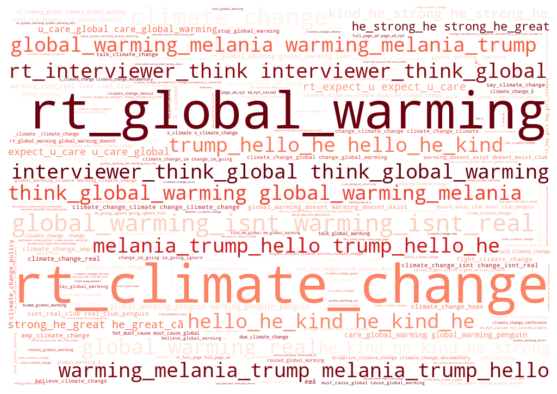

In [523]:
all_words = ' '.join([text for text in train[train['sentiment'] == 0]['trigrams_text']])
plotwordclouds(all_words)


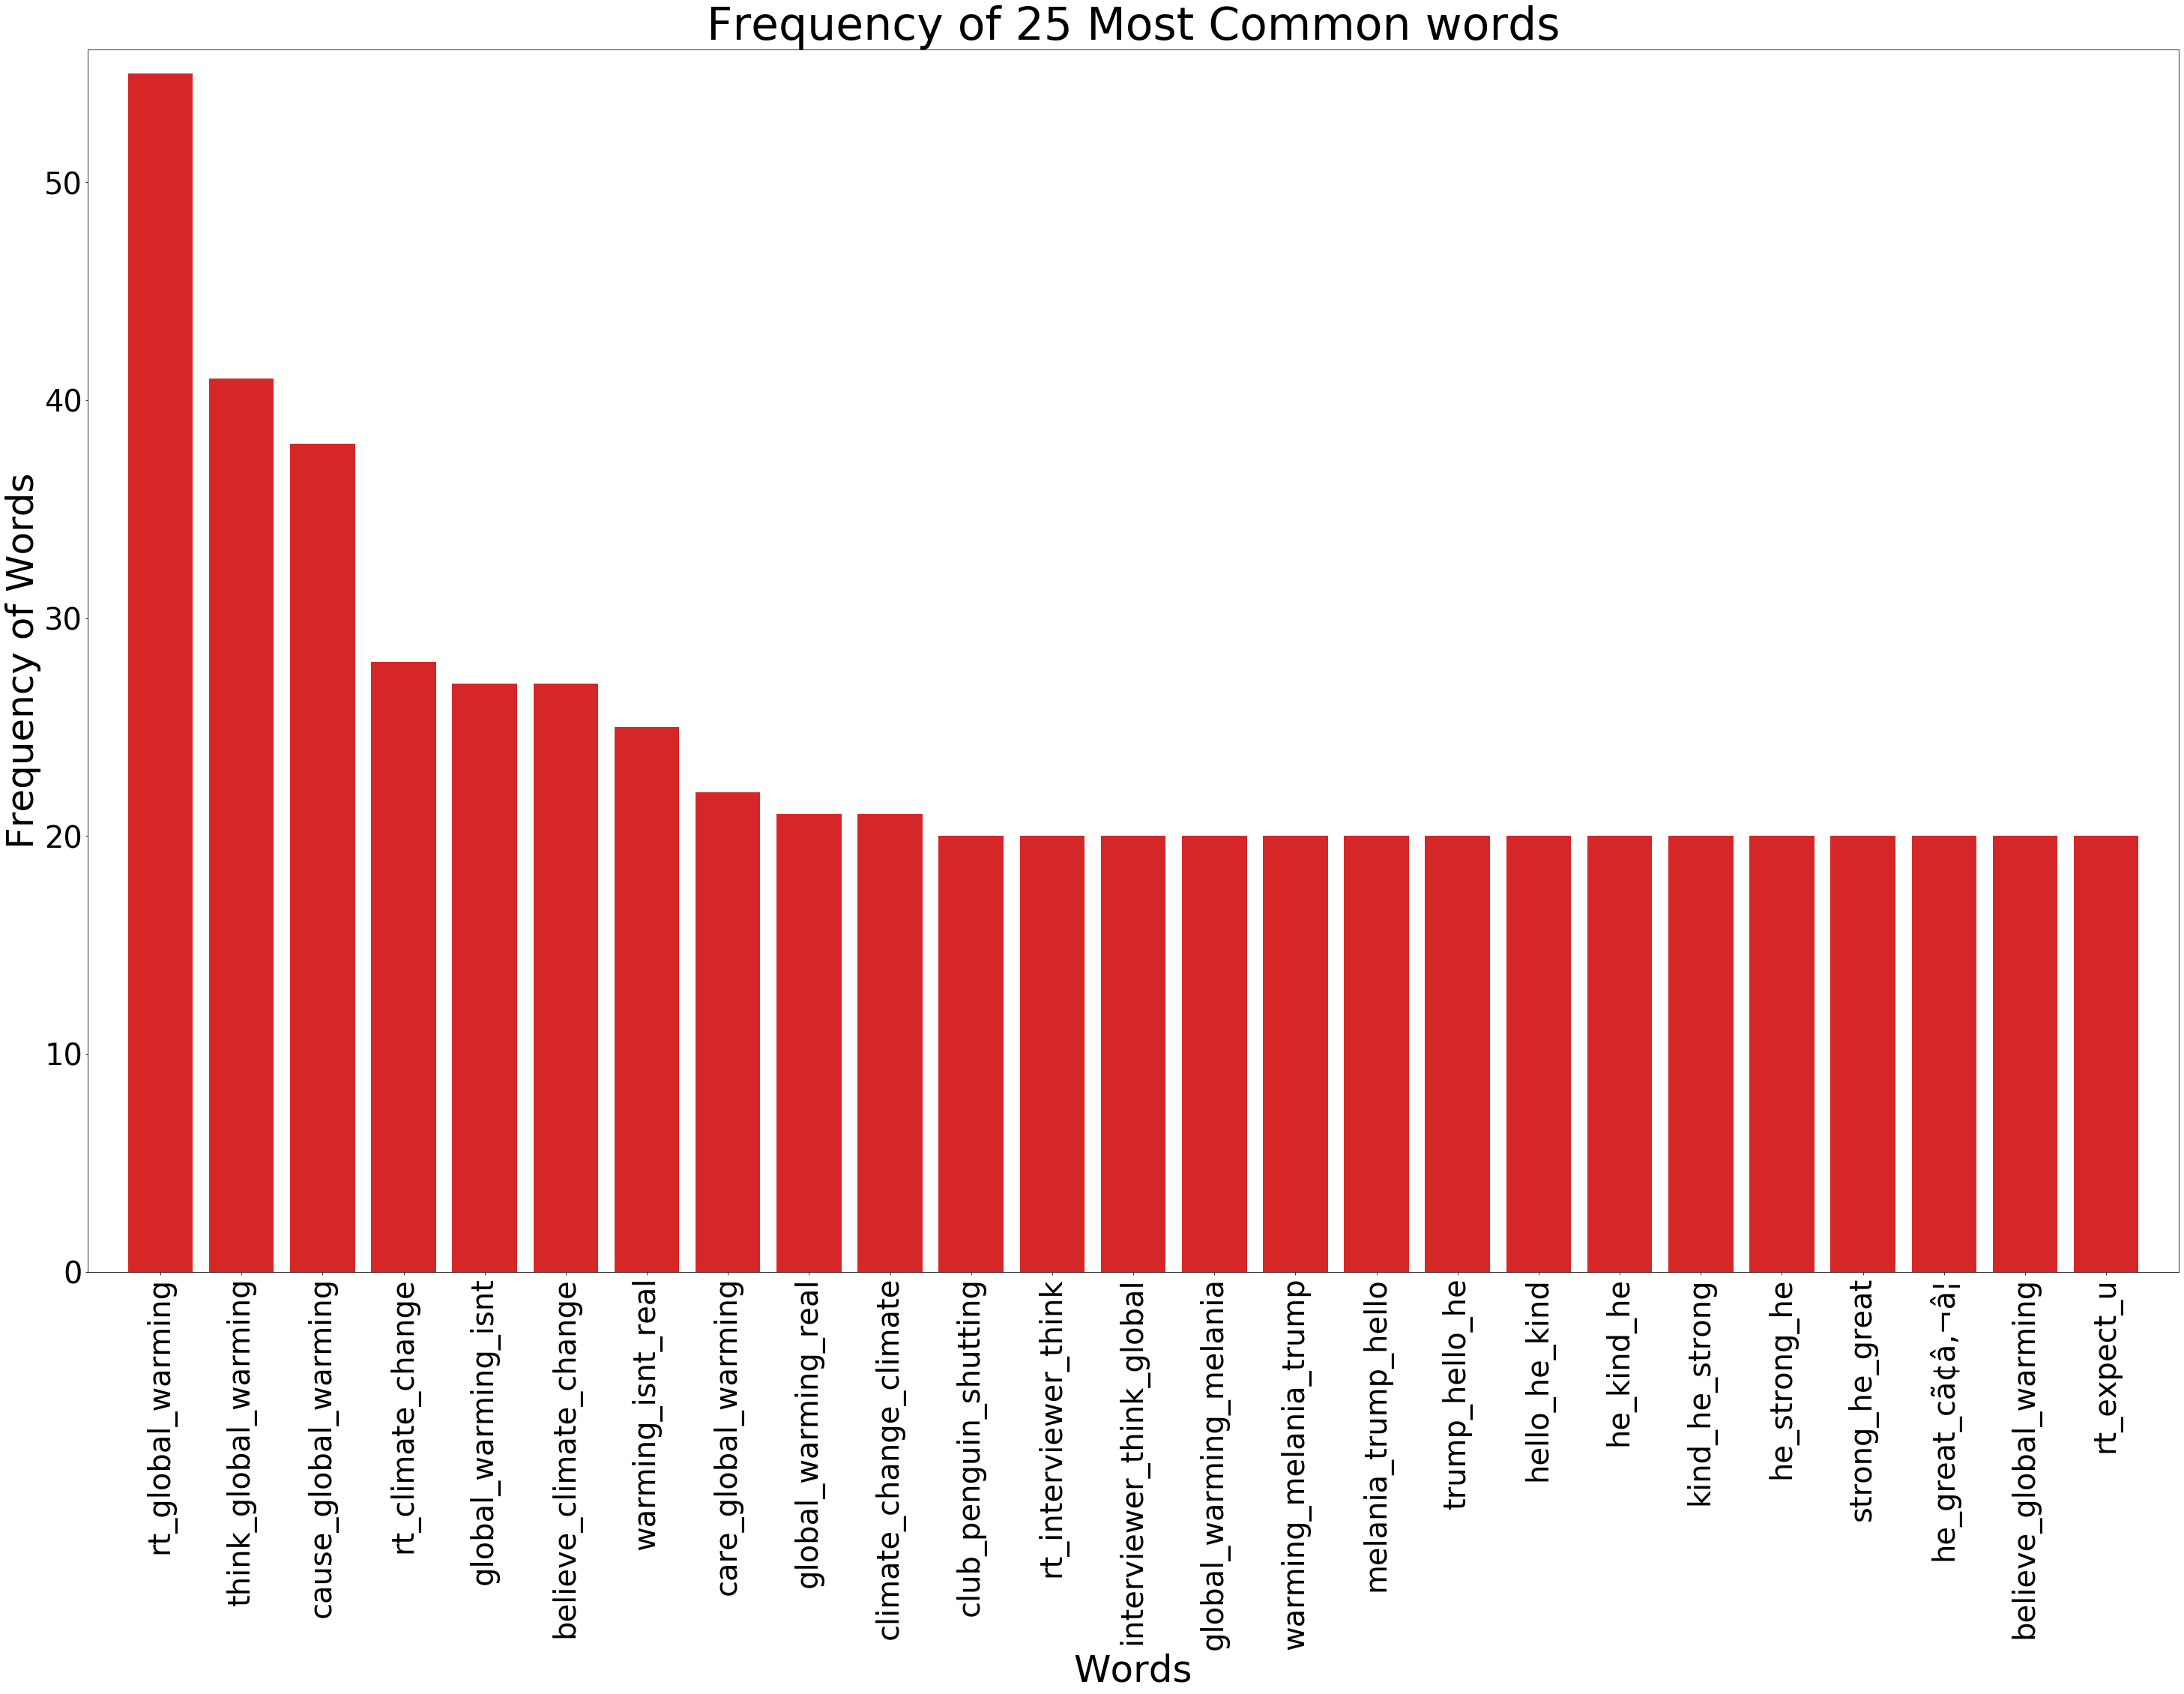

In [524]:
allwords = []
for wordlist in train[train['sentiment']==0]['trigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords,'Frequency of 25 Most Common words')

## For tweets in the class "1" 

In [526]:
for i in range(5):
    print(train[train['sentiment']==1]['message'].iloc[i] + '\n')
    

polyscimajor epa chief doesnt think carbon dioxide main cause global warming wait via

like lack evidence anthropogenic global warming

todayinmaker wired pivotal year war climate change

rt racist sexist climate change denying bigot leading poll electionnight

worth read whether dont believe climate change



### Most common words

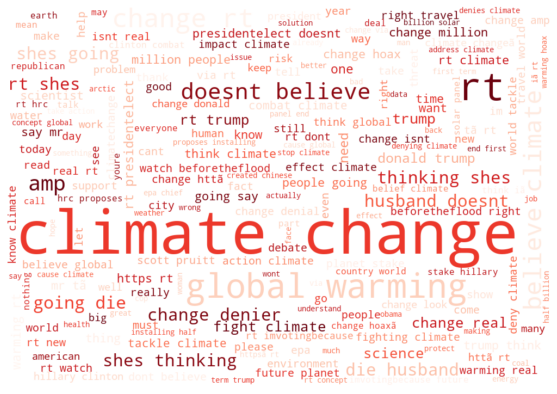

In [527]:
all_words = ' '.join([text for text in train[train['sentiment'] == 1]['message']])
plotwordclouds(all_words)


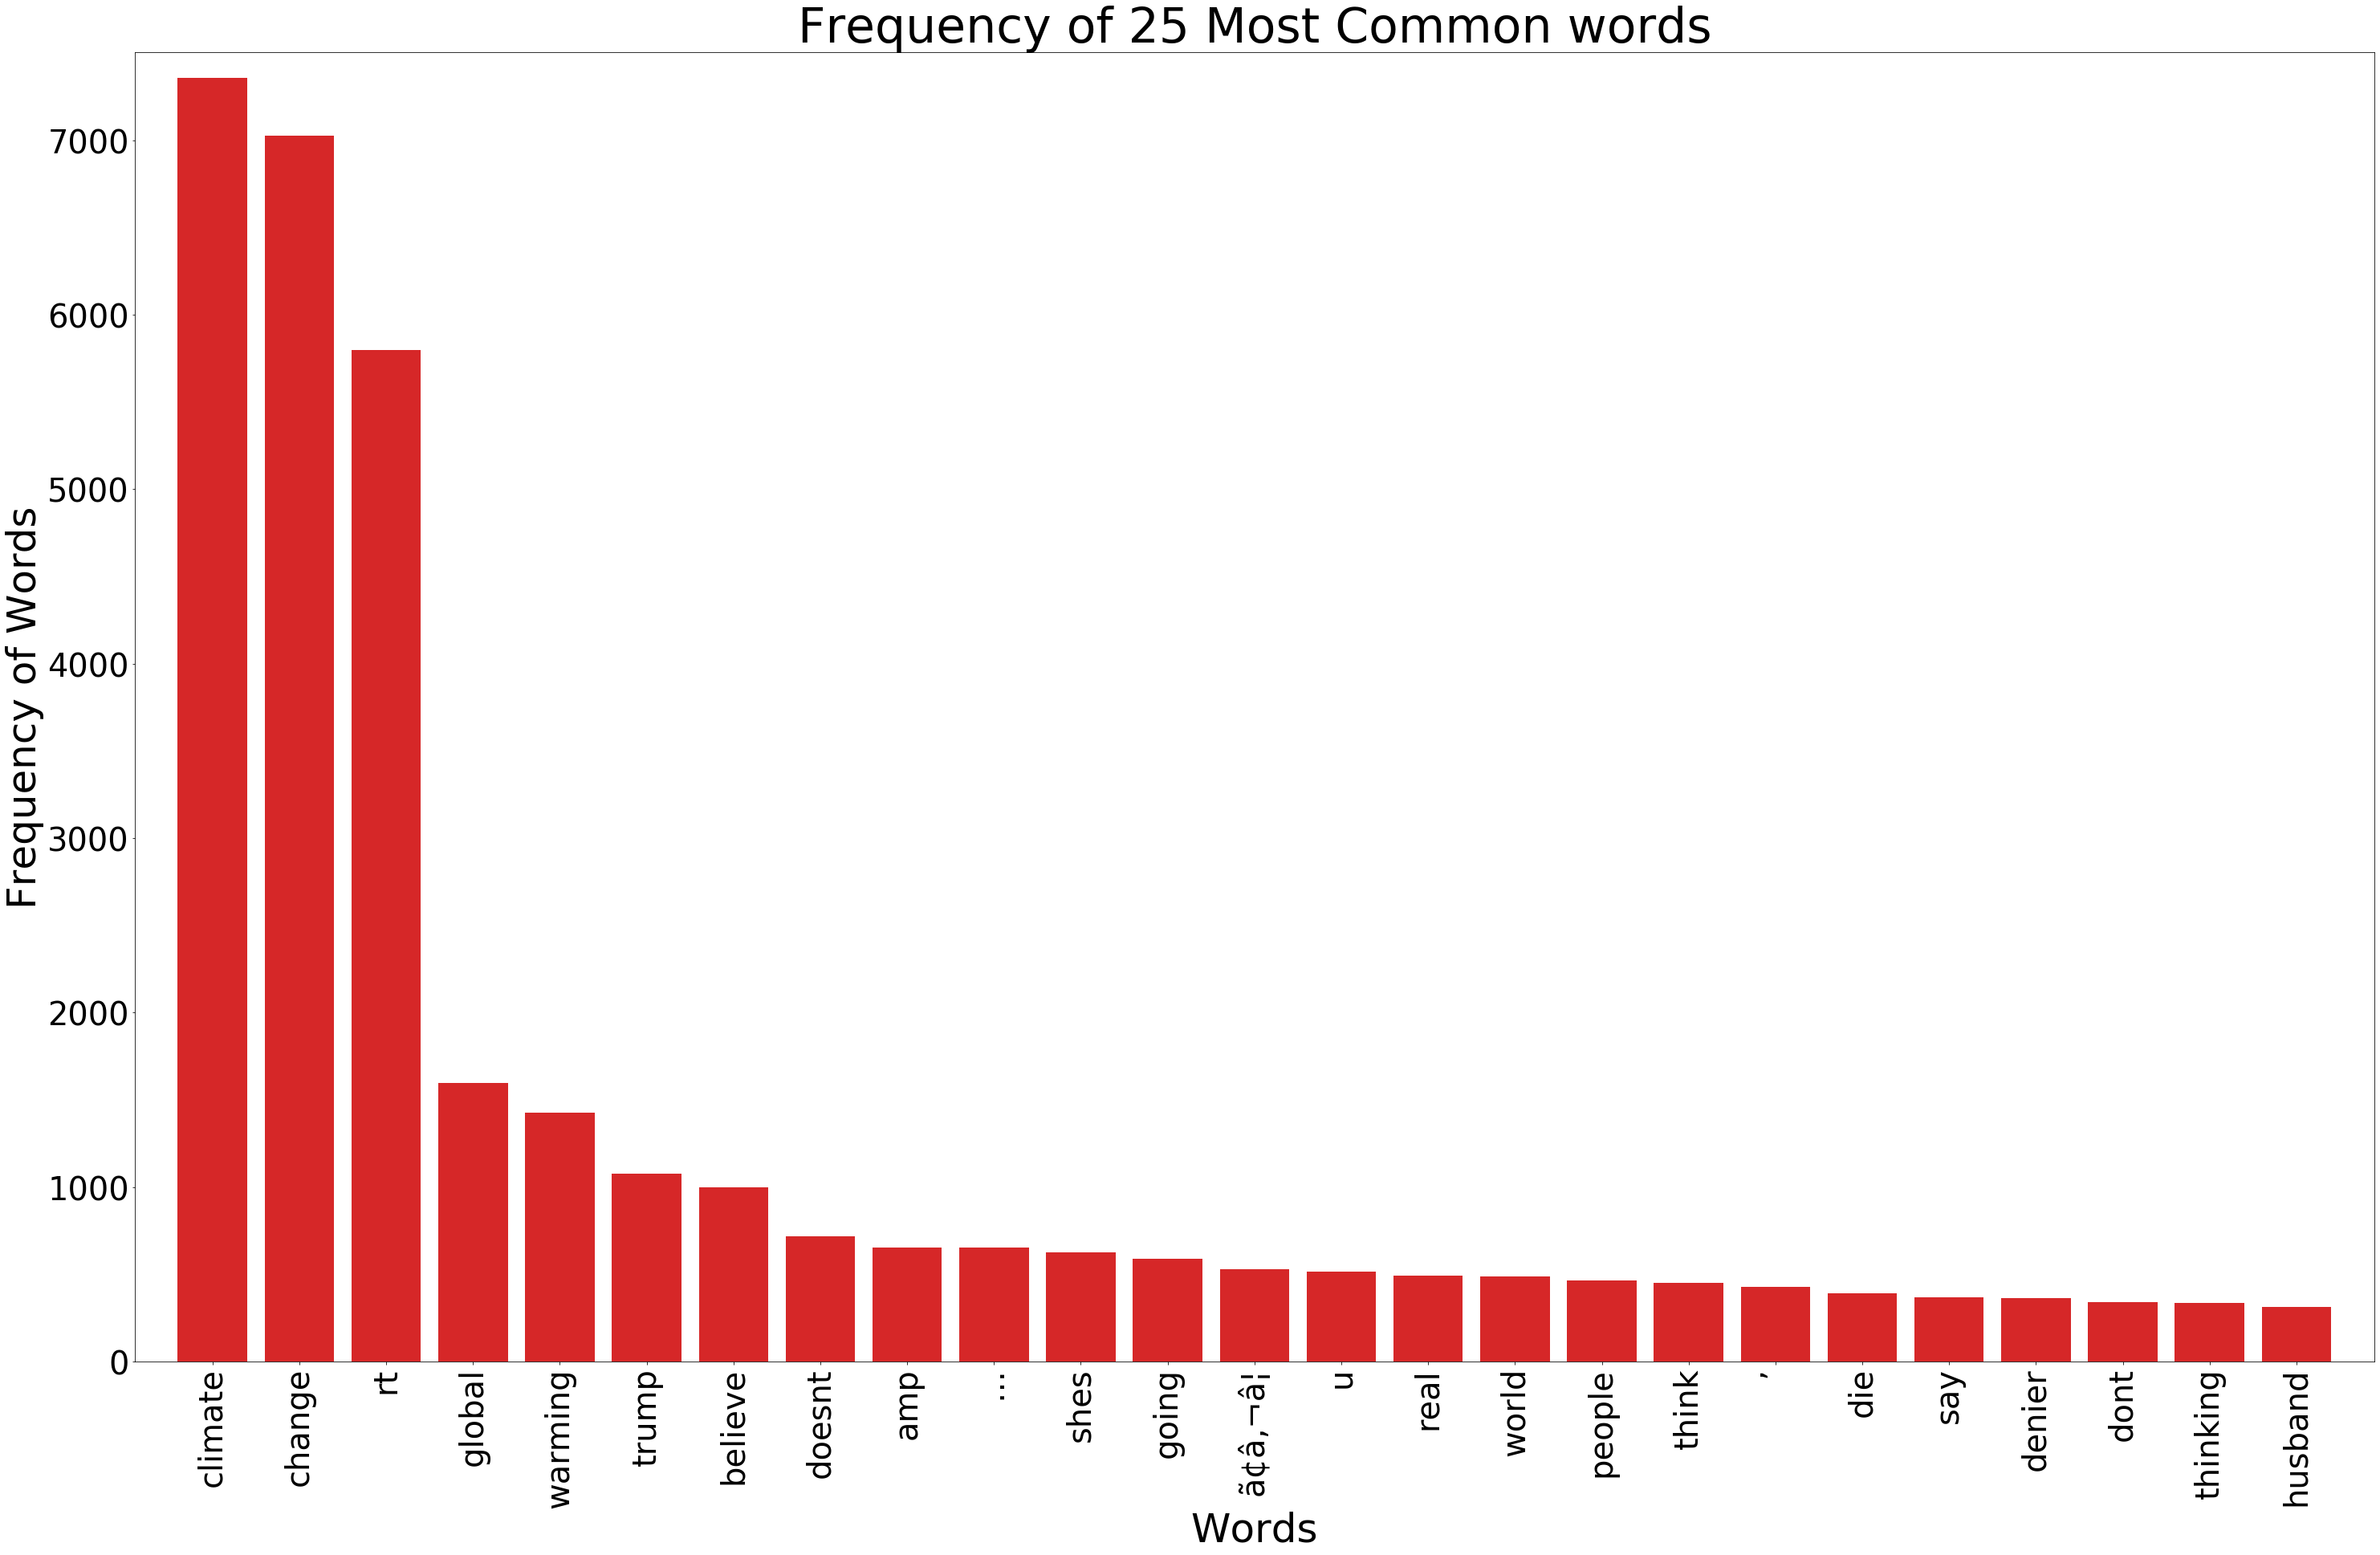

In [528]:
allwords = []
for wordlist in train[train['sentiment'] == 1]['clean_tokens']:
    allwords += wordlist
    train[train['sentiment'] == 1]['clean_tokens']

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Most common nouns

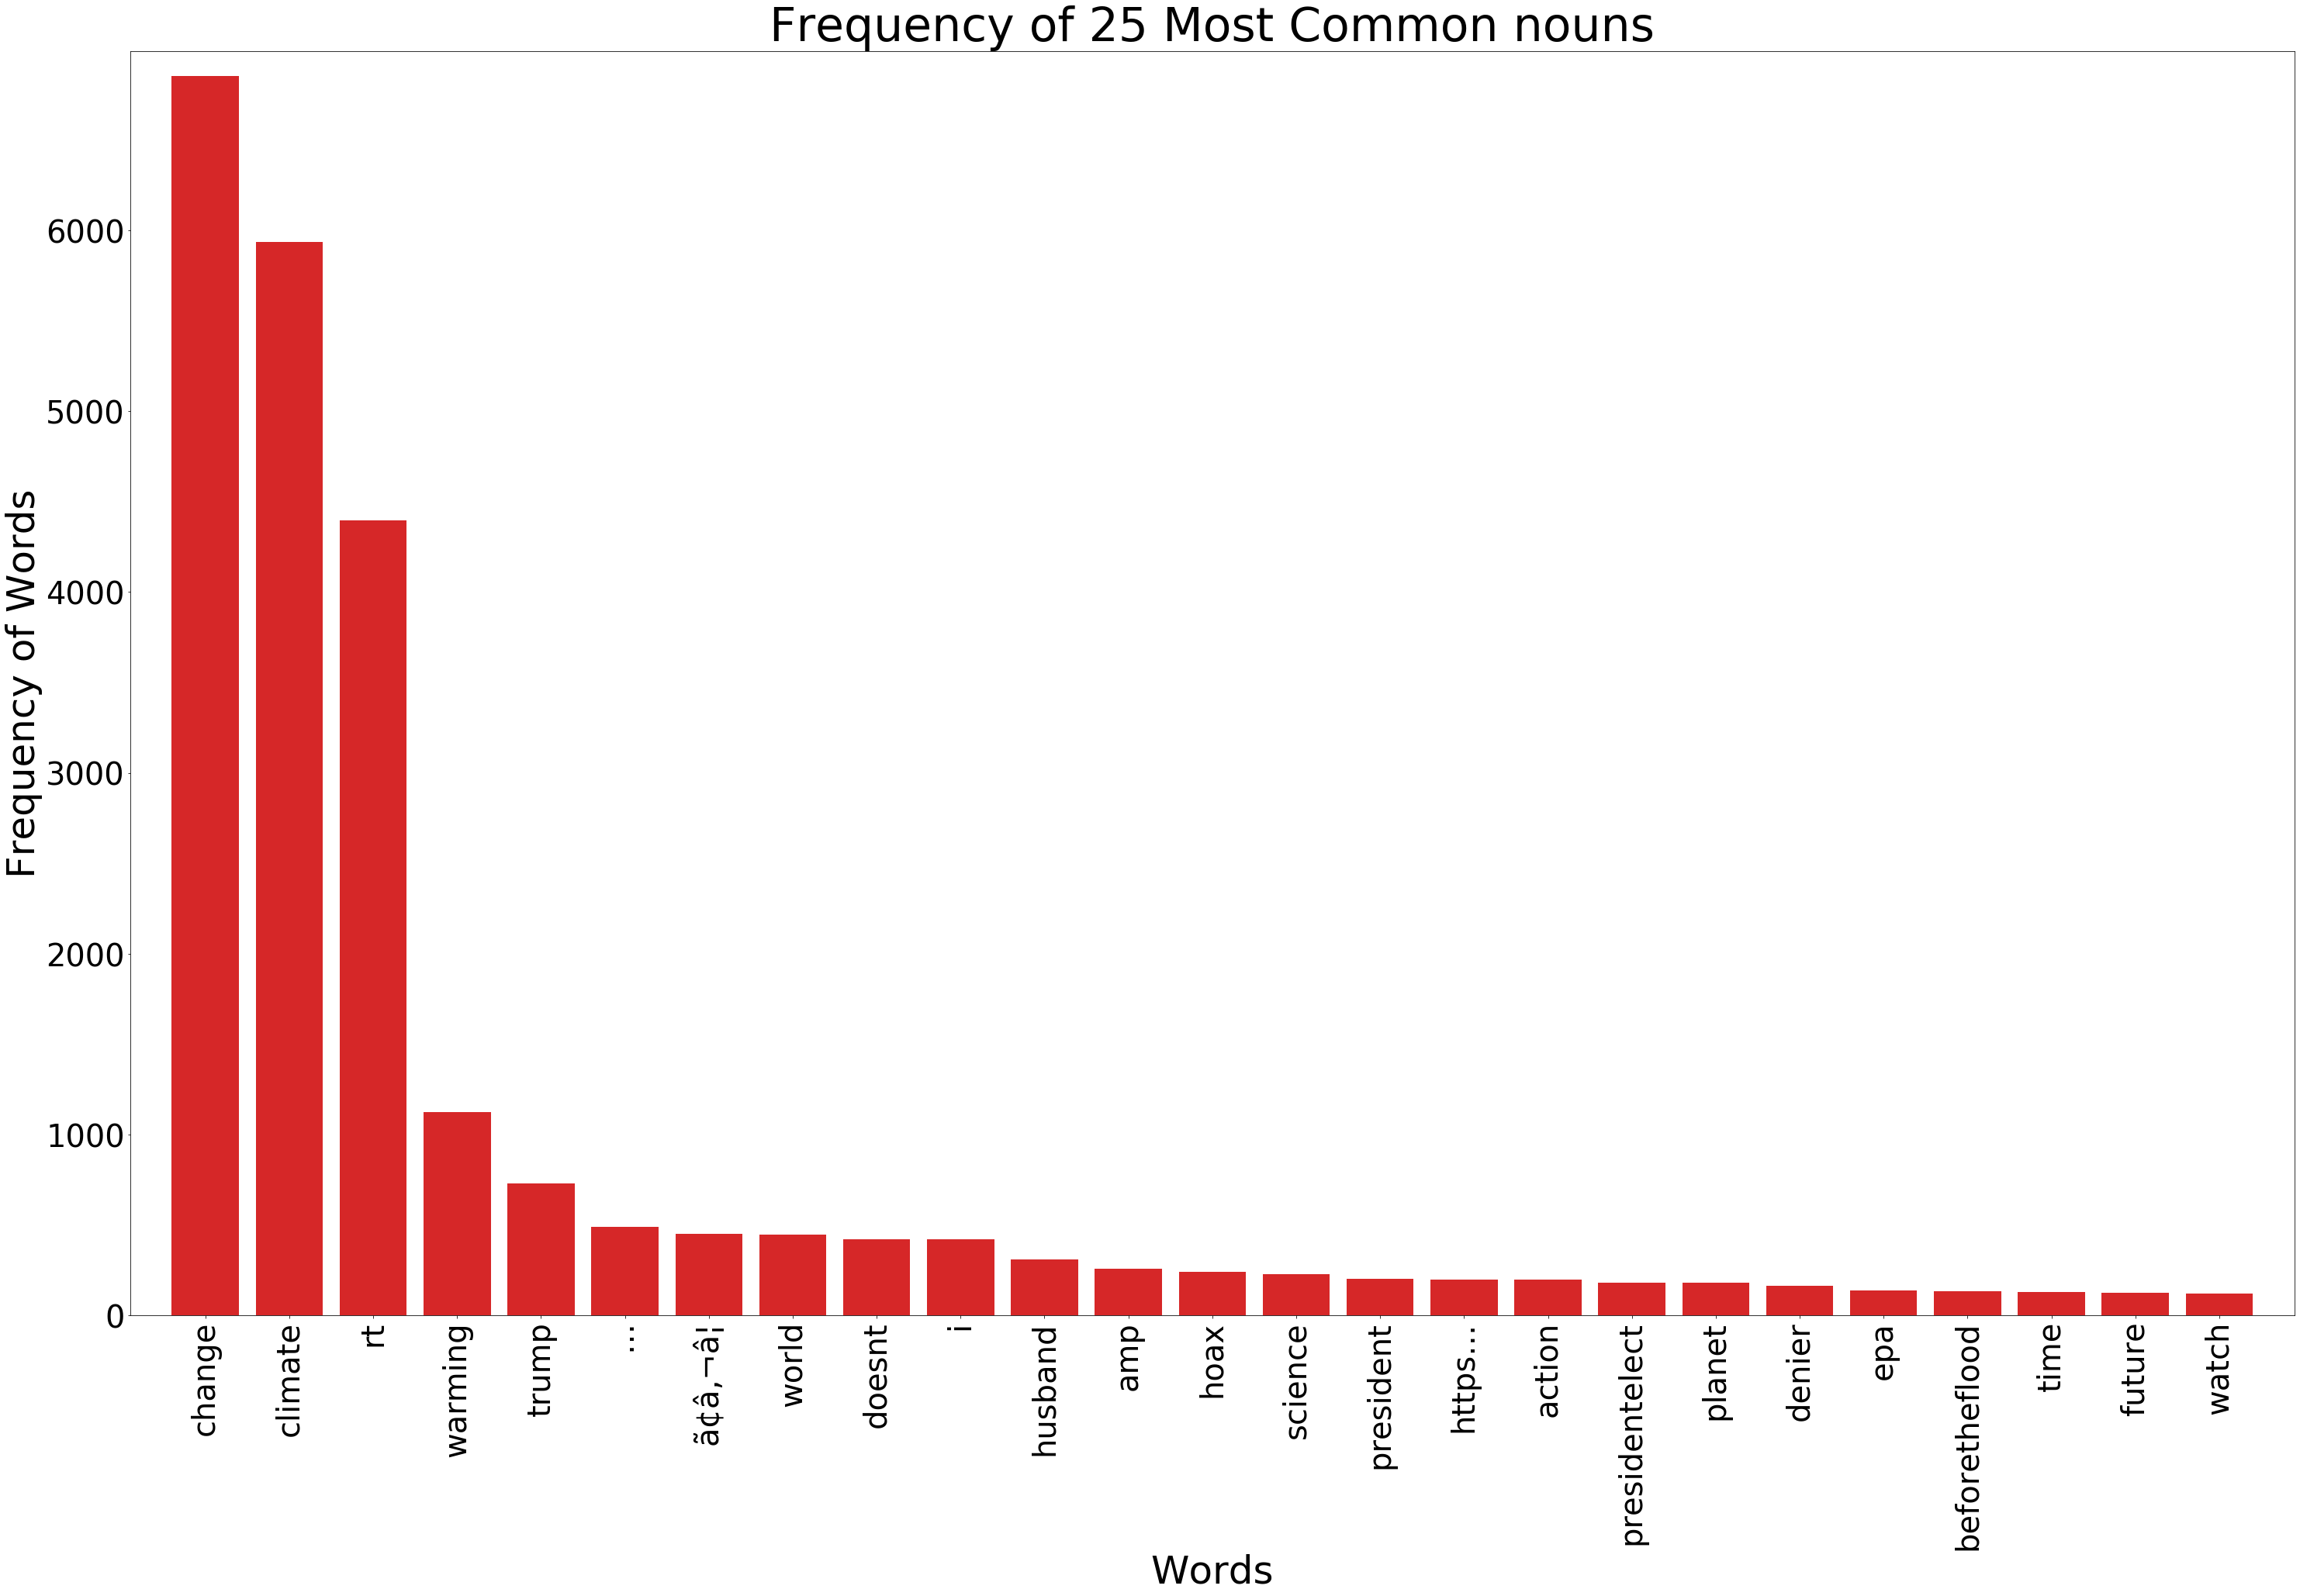

In [536]:
allnouns = []
for wordlist in train[train['sentiment'] == 1]['POS_nouns']:
    allnouns += wordlist

plot_most_frequent(allnouns, 'Frequency of 25 Most Common nouns')


### Most common verbs

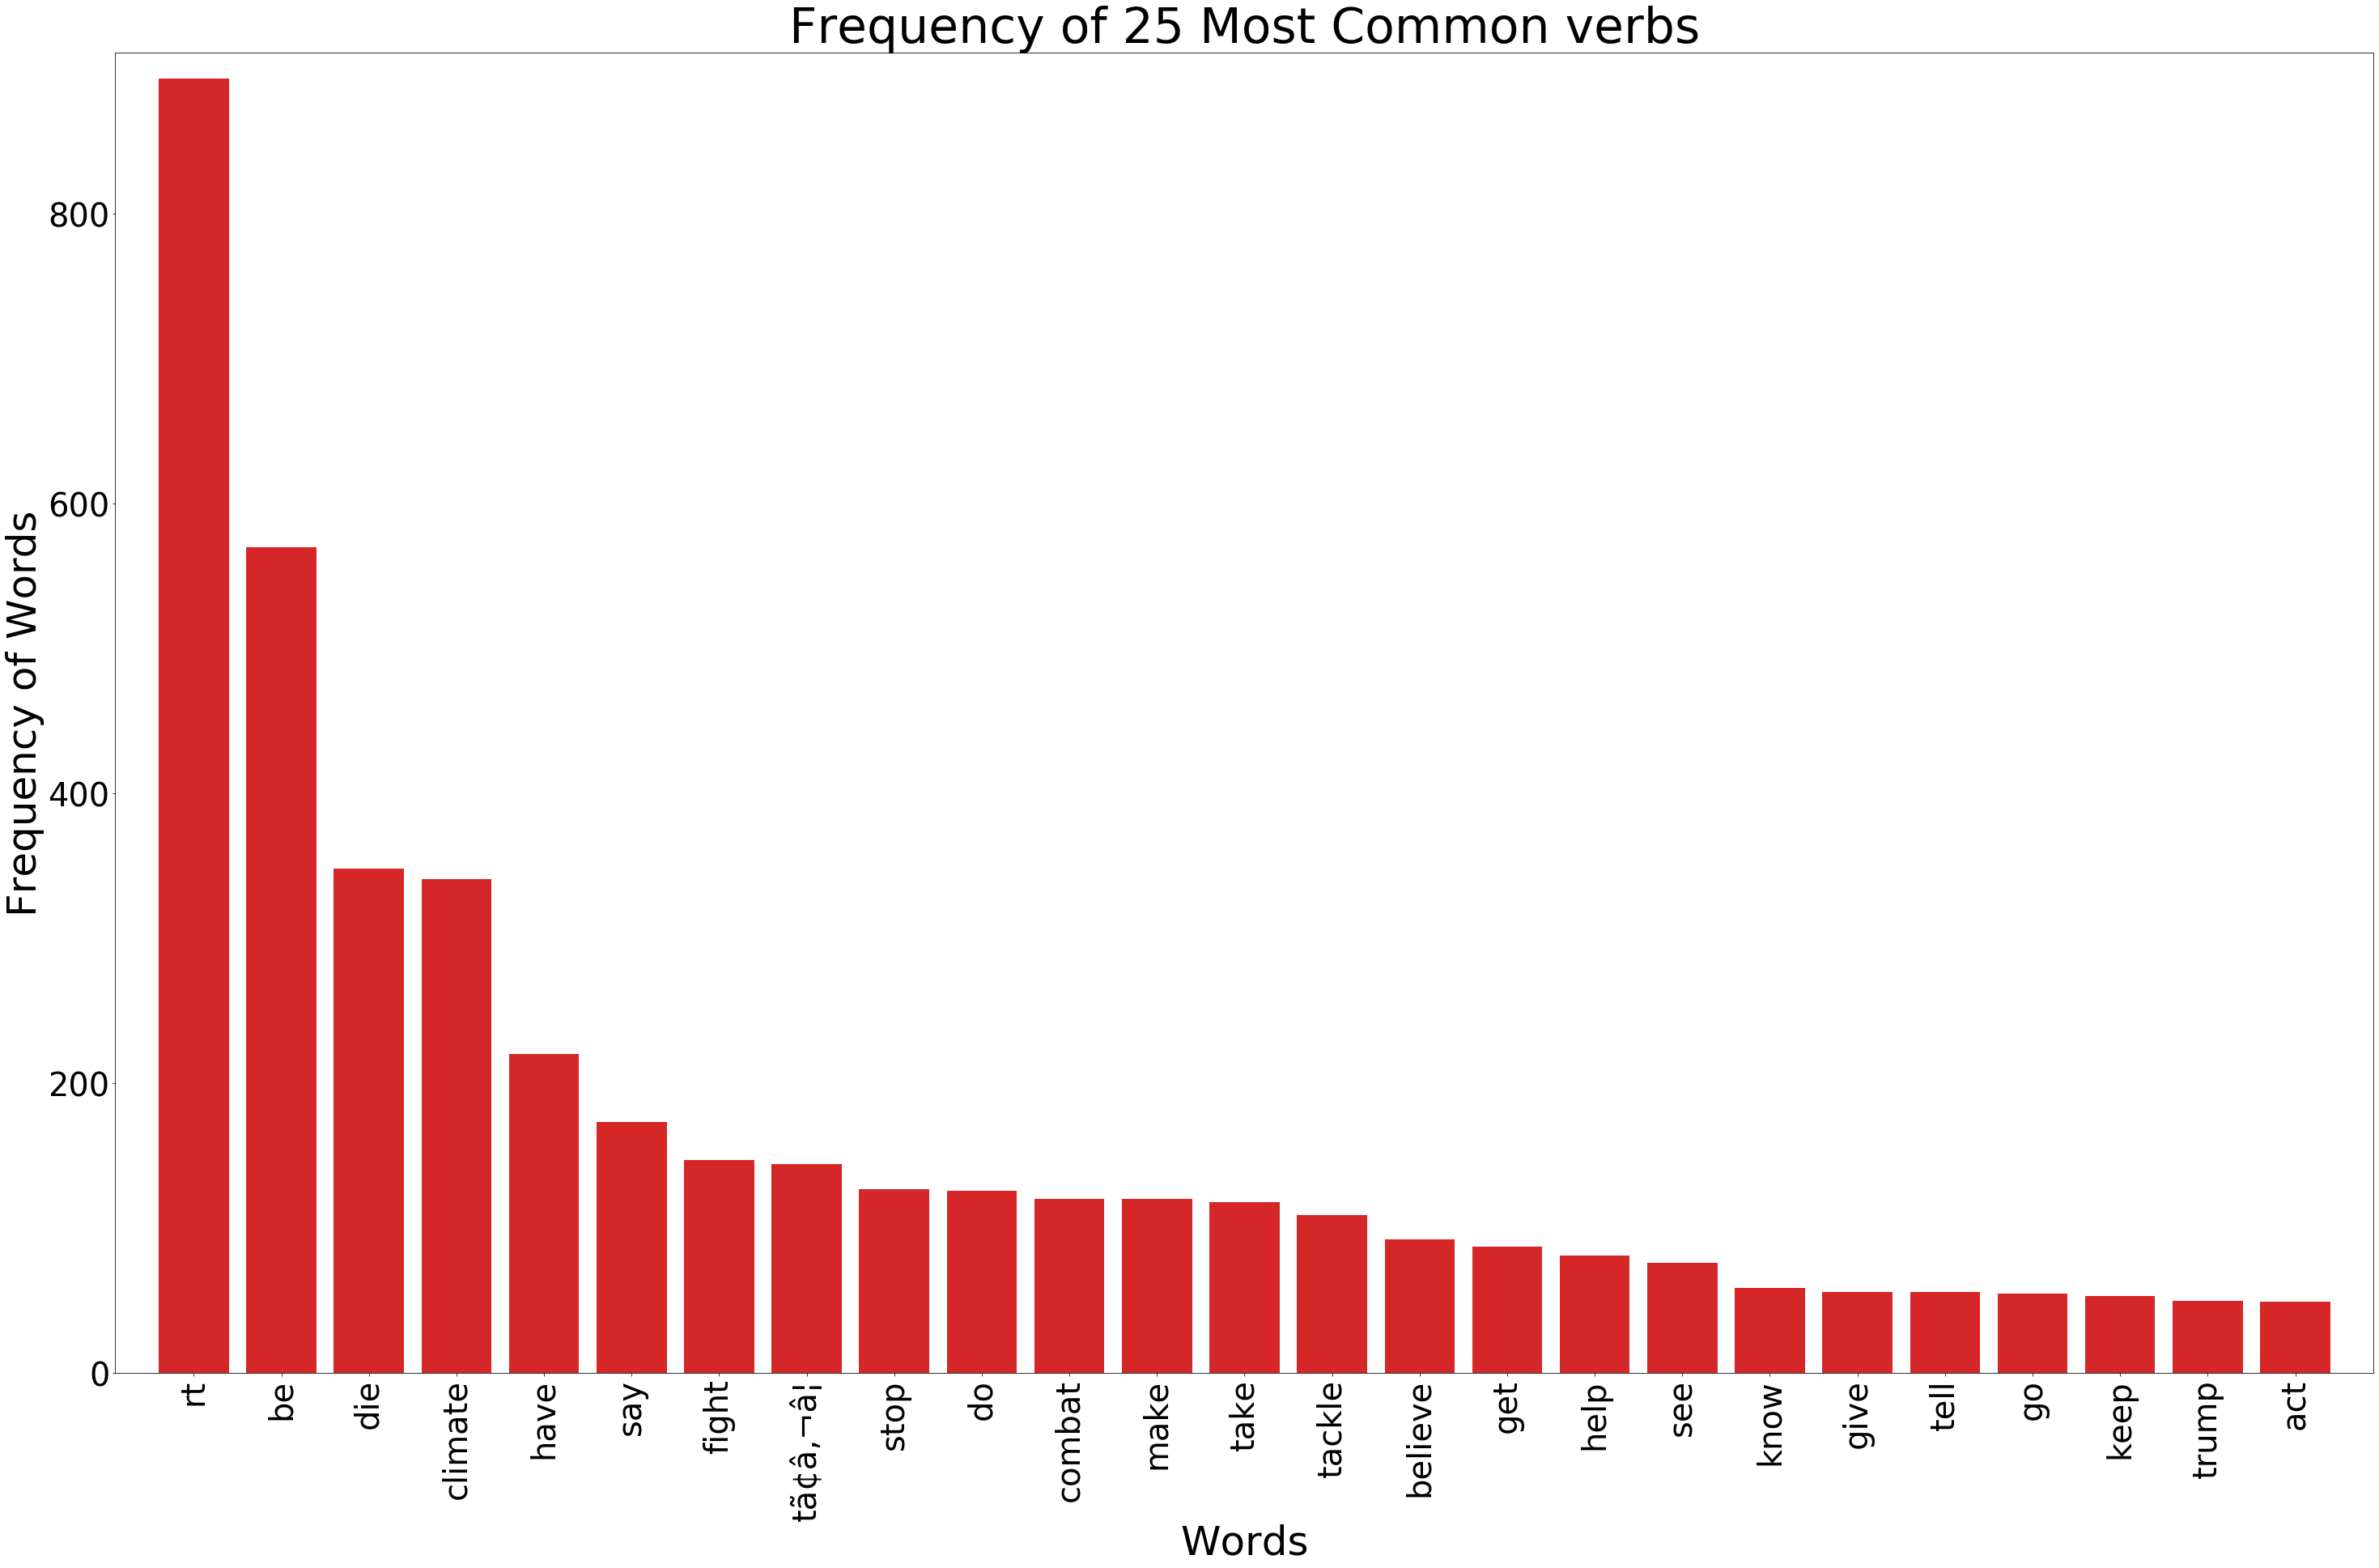

In [537]:
allverbs = []
for wordlist in train[train['sentiment'] == 1]['POS_verbs']:
    allverbs += wordlist

plot_most_frequent(allverbs, 'Frequency of 25 Most Common verbs')


### Visualising bi-grams

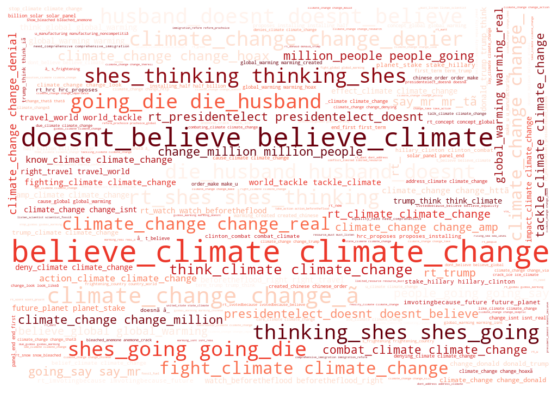

In [538]:
all_words = ' '.join([text for text in train[train['sentiment'] == 1]['bigrams_text']])
plotwordclouds(all_words)


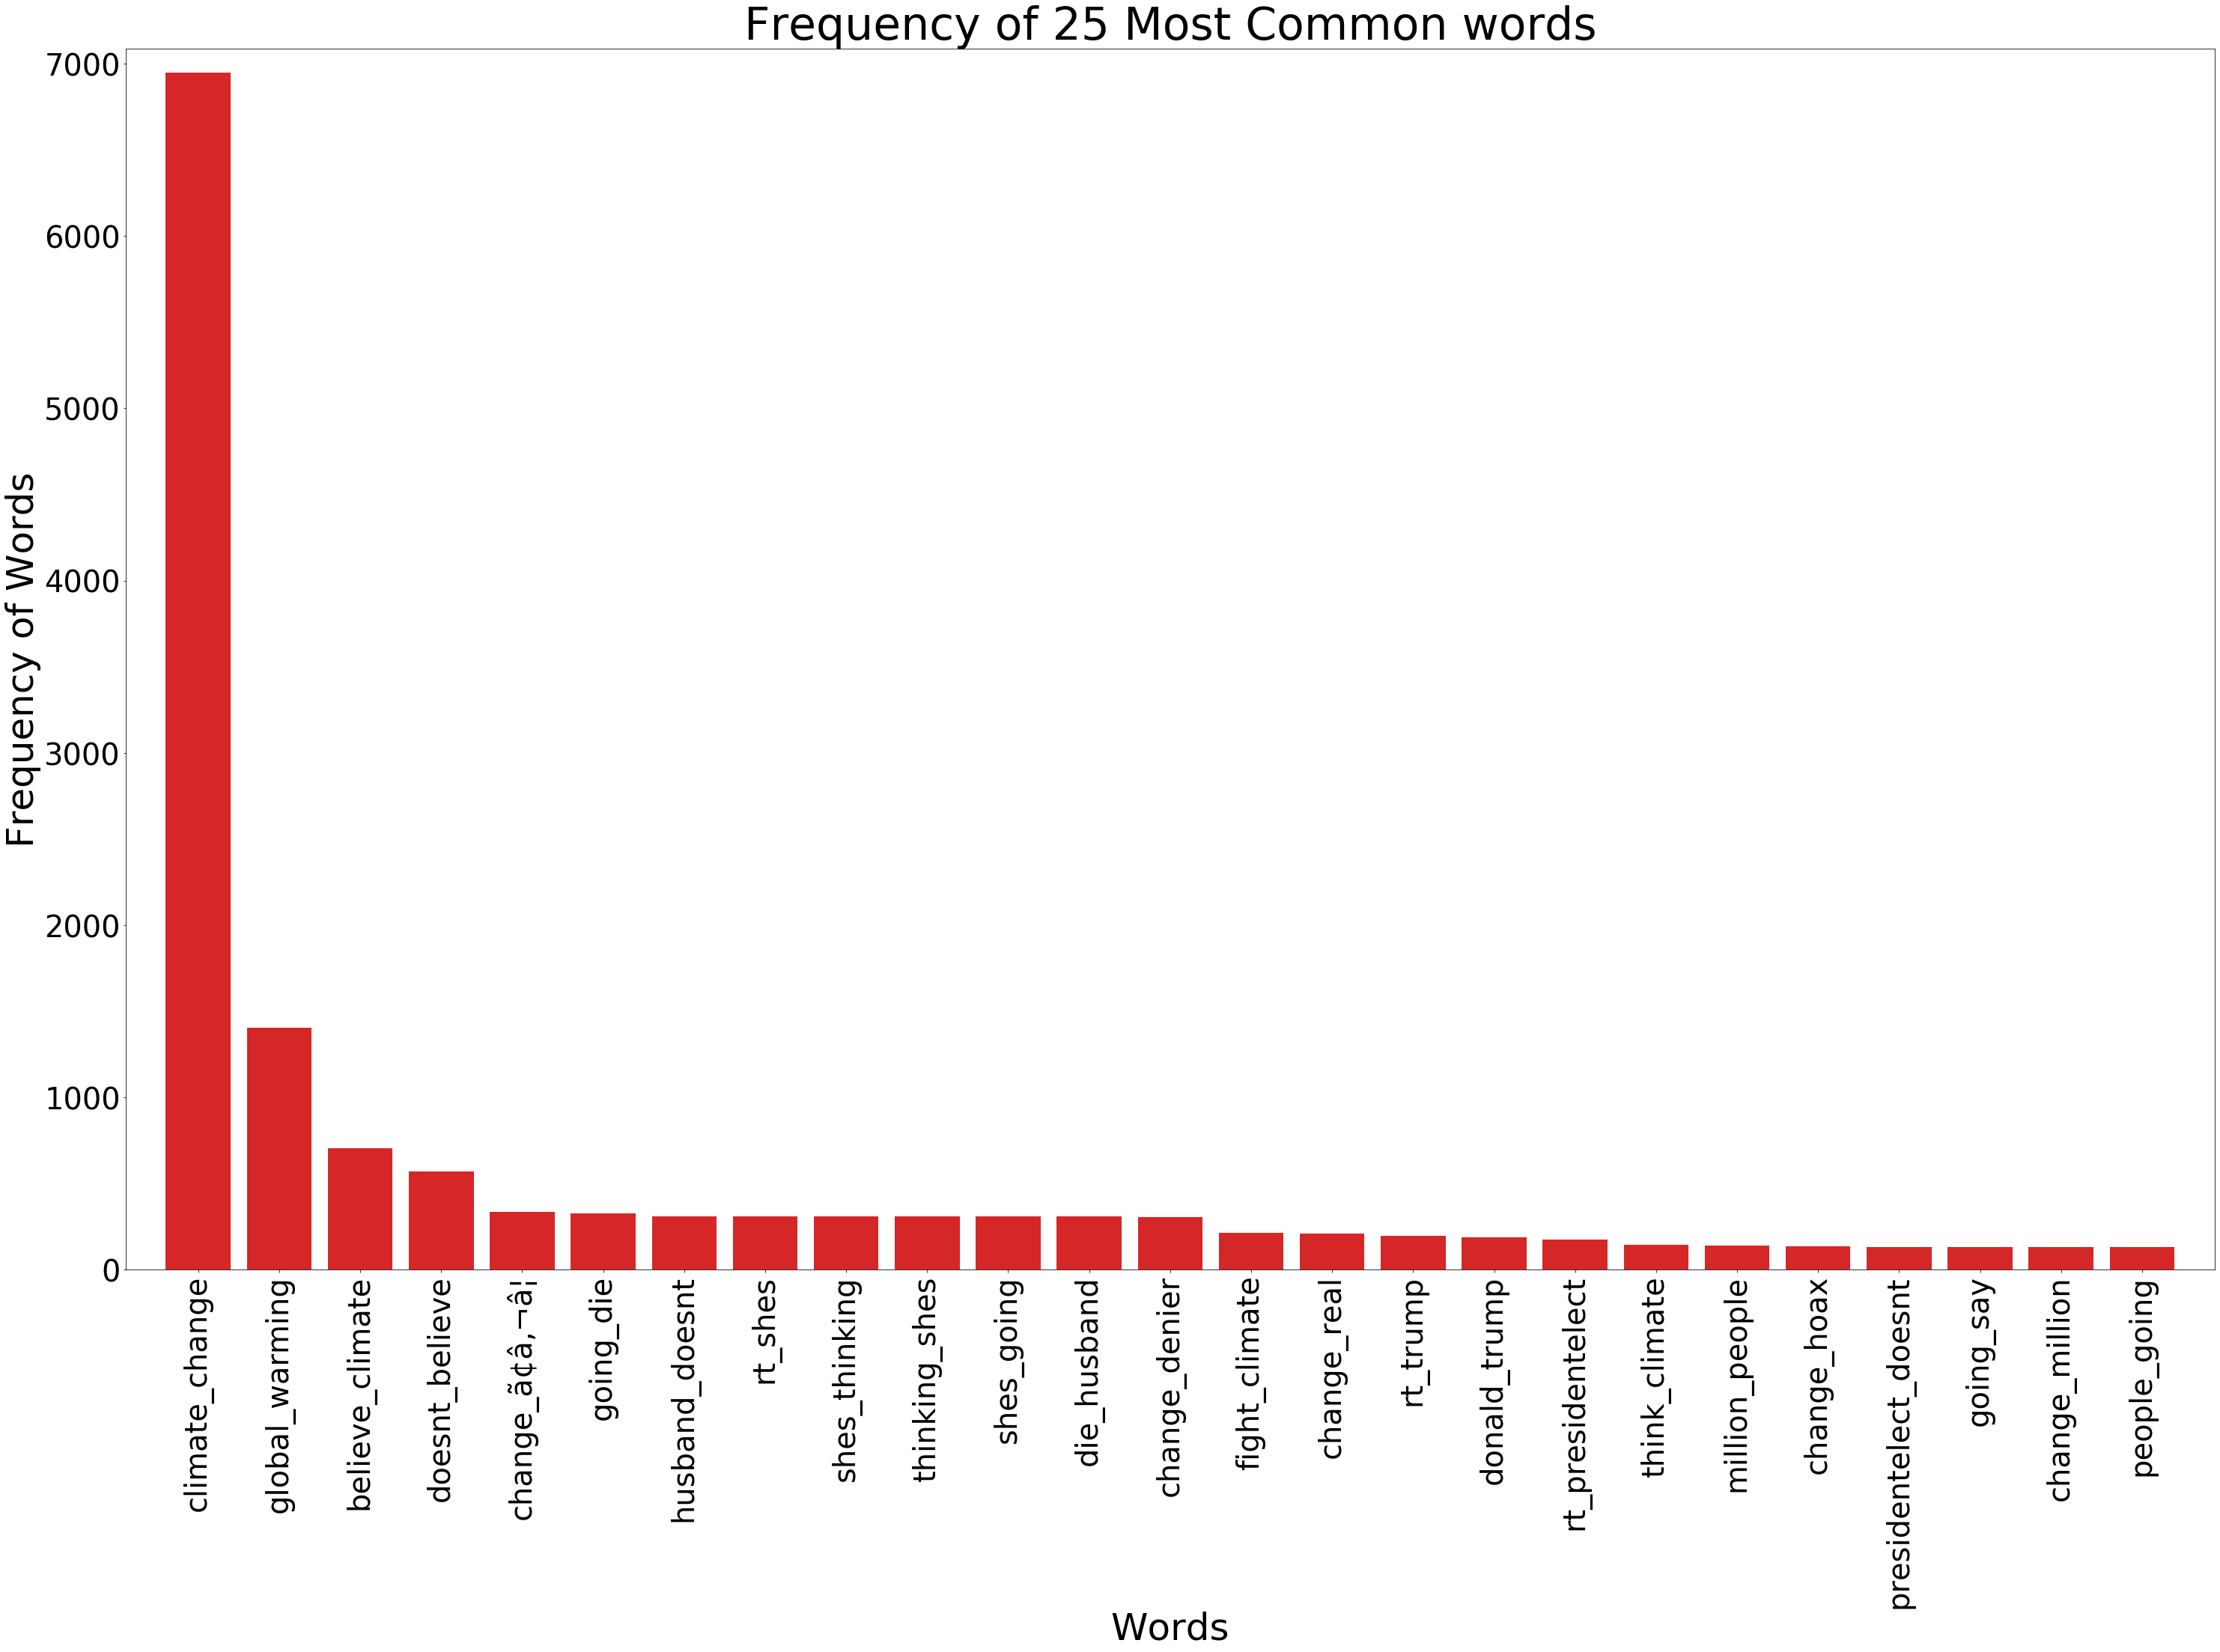

In [539]:
allwords = []
for wordlist in train[train['sentiment'] == 1]['bigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Visualising tri-grams

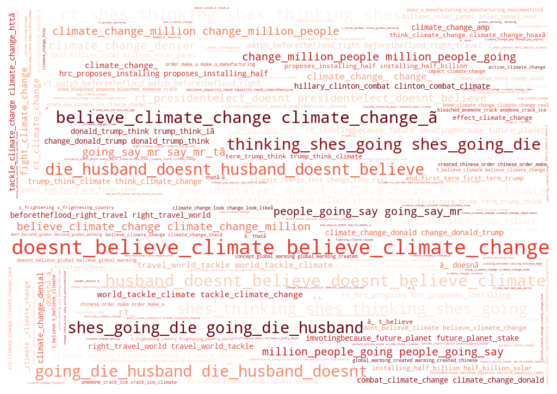

In [540]:
all_words = ' '.join([text for text in train[train['sentiment'] == 1]['trigrams_text']])
plotwordclouds(all_words)


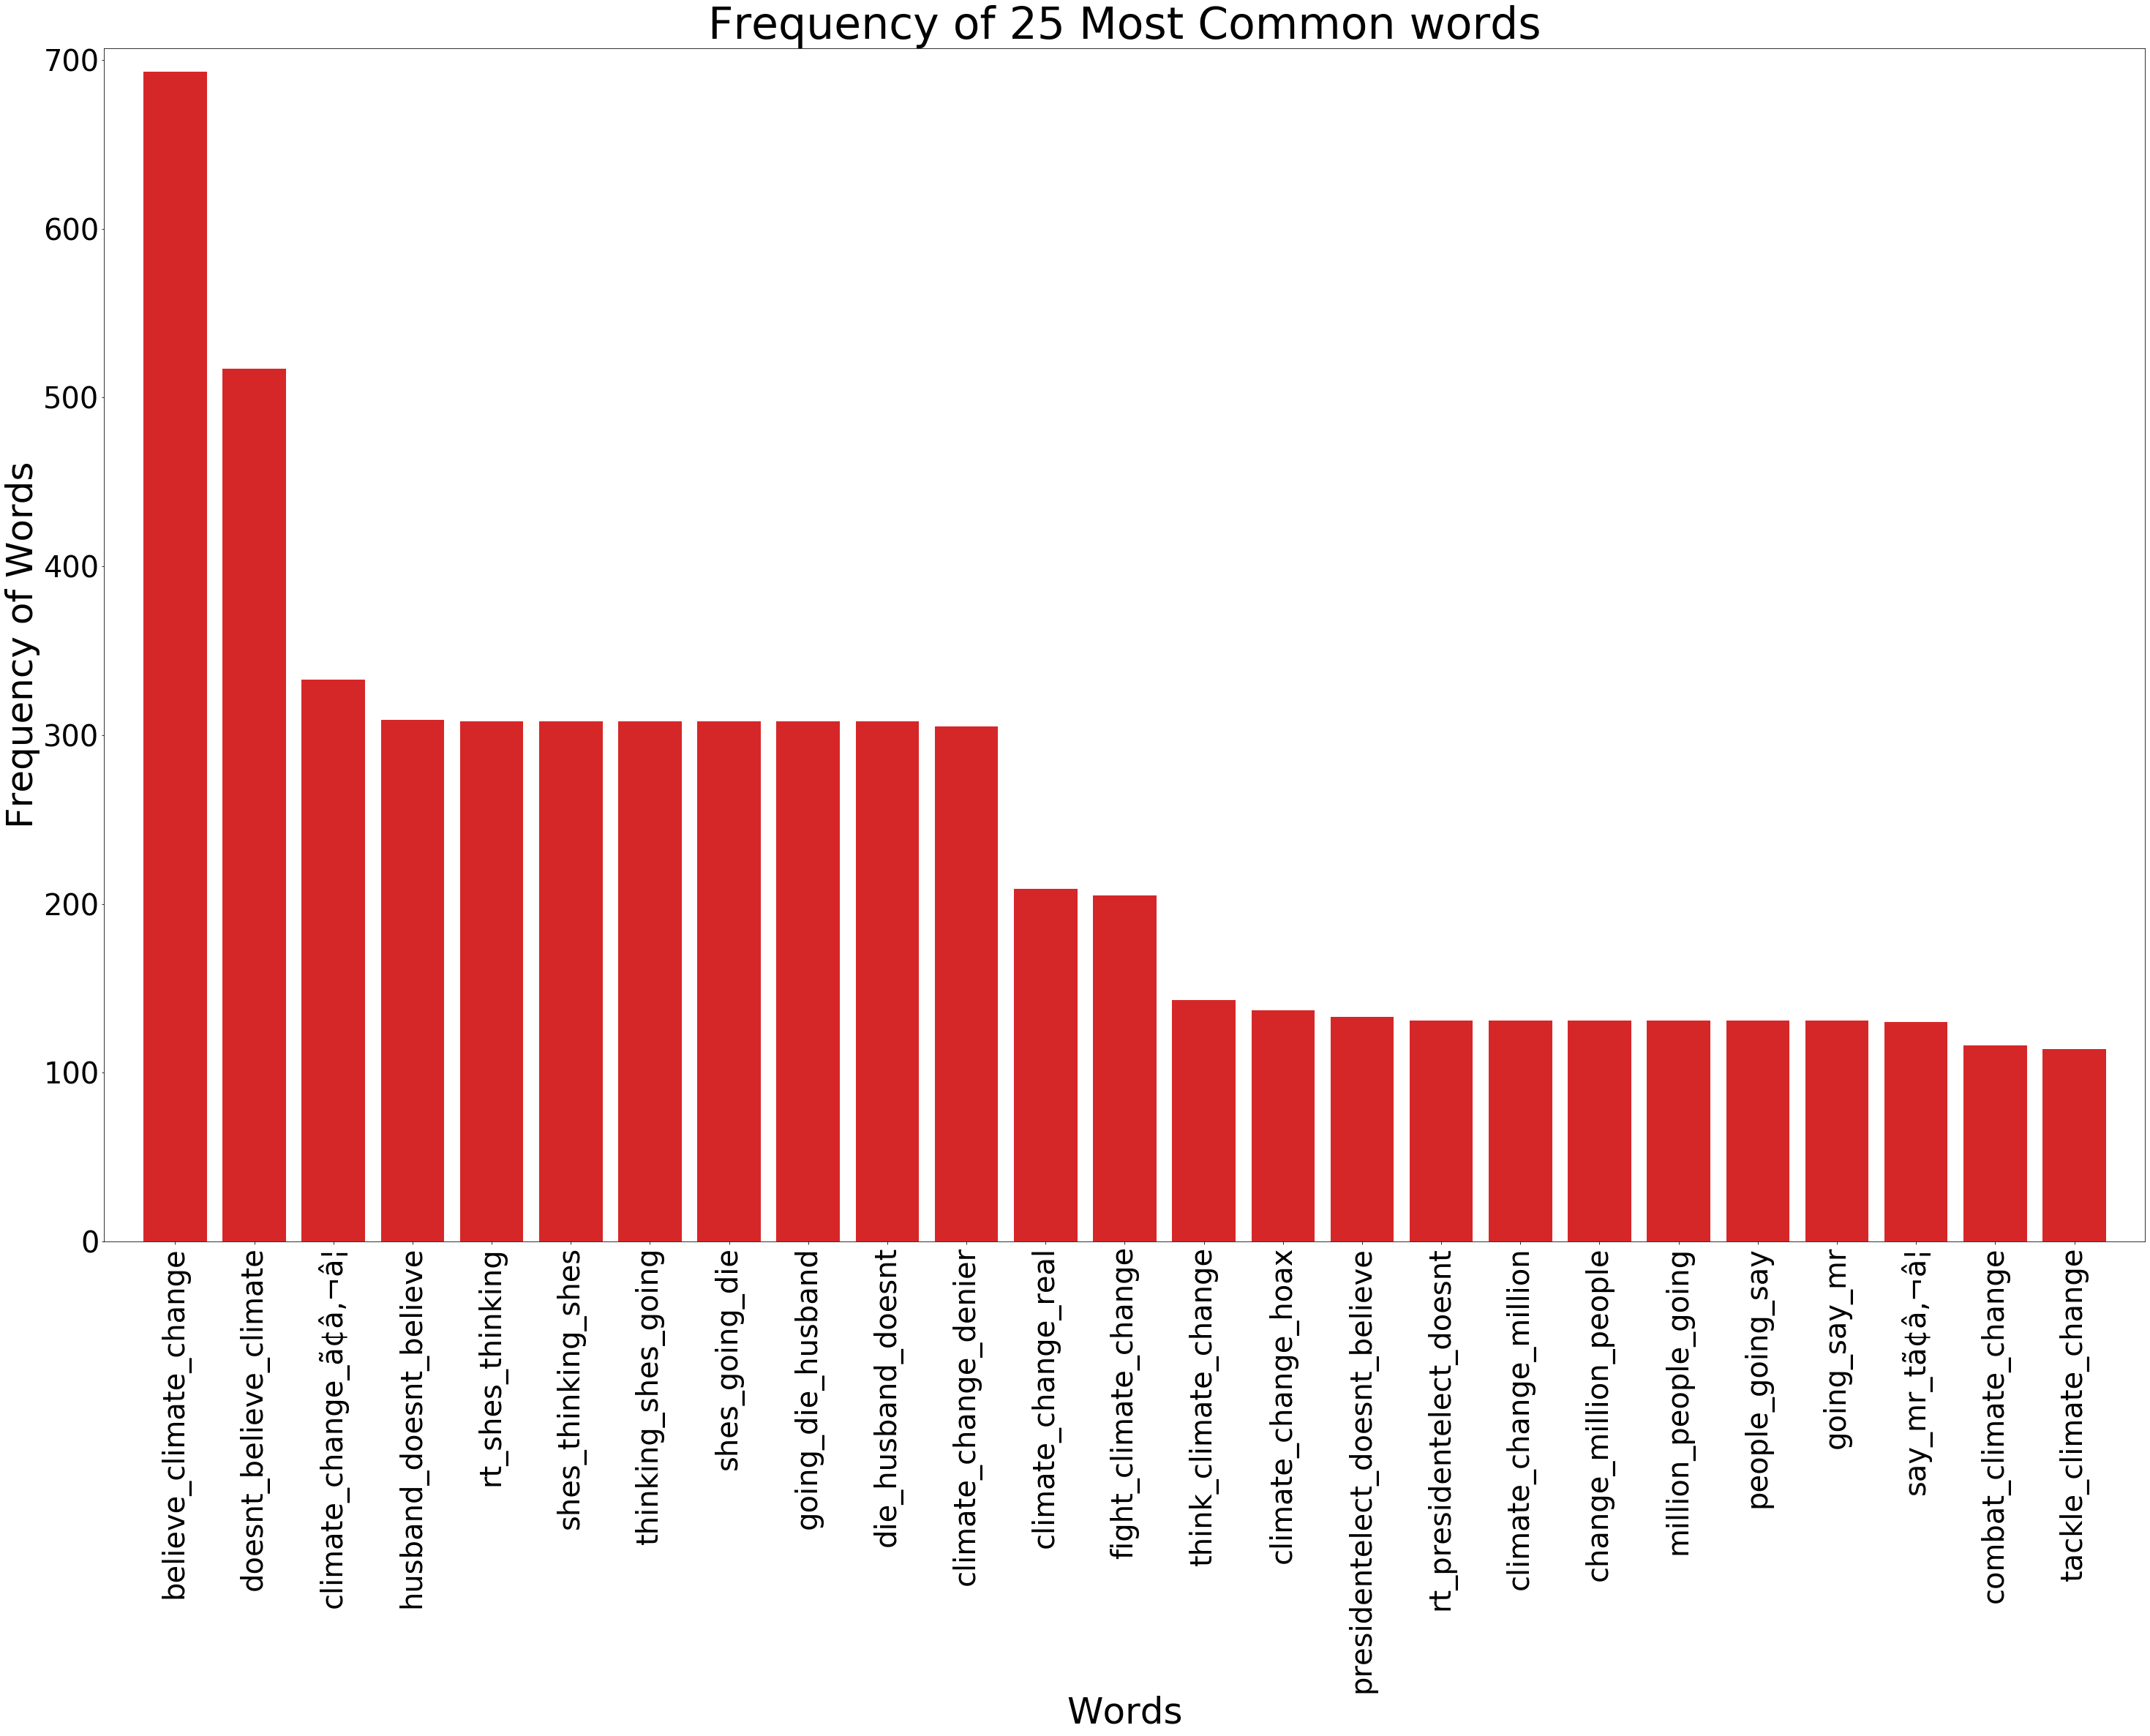

In [541]:
allwords = []
for wordlist in train[train['sentiment'] == 1]['trigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


## For tweets in the class "2" 

In [542]:
for i in range(5):
    print(train[train['sentiment'] == 2]['message'].iloc[i] + '\n')


rt researcher say three year act climate change ’ late …

rt percent chance avoiding ‘ dangerous ’ global warming study find …

fossil fuel giant exxonmobil ‘ misled ’ public climate change harvard academic conclude

bangladesh confronting climate change head

rt atmospheric river fueled climate change could decimate wild oyster san francisco bay …



### Most common words

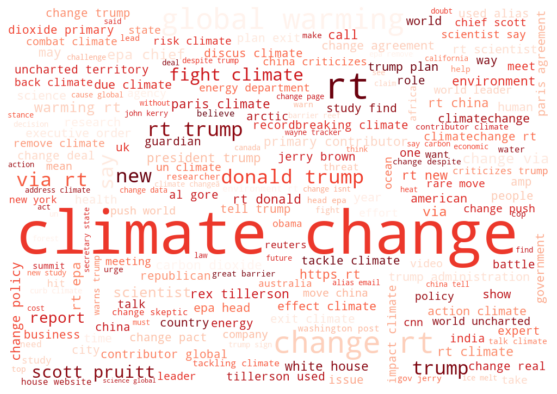

In [543]:
all_words = ' '.join([text for text in train[train['sentiment'] == 2]['message']])
plotwordclouds(all_words)


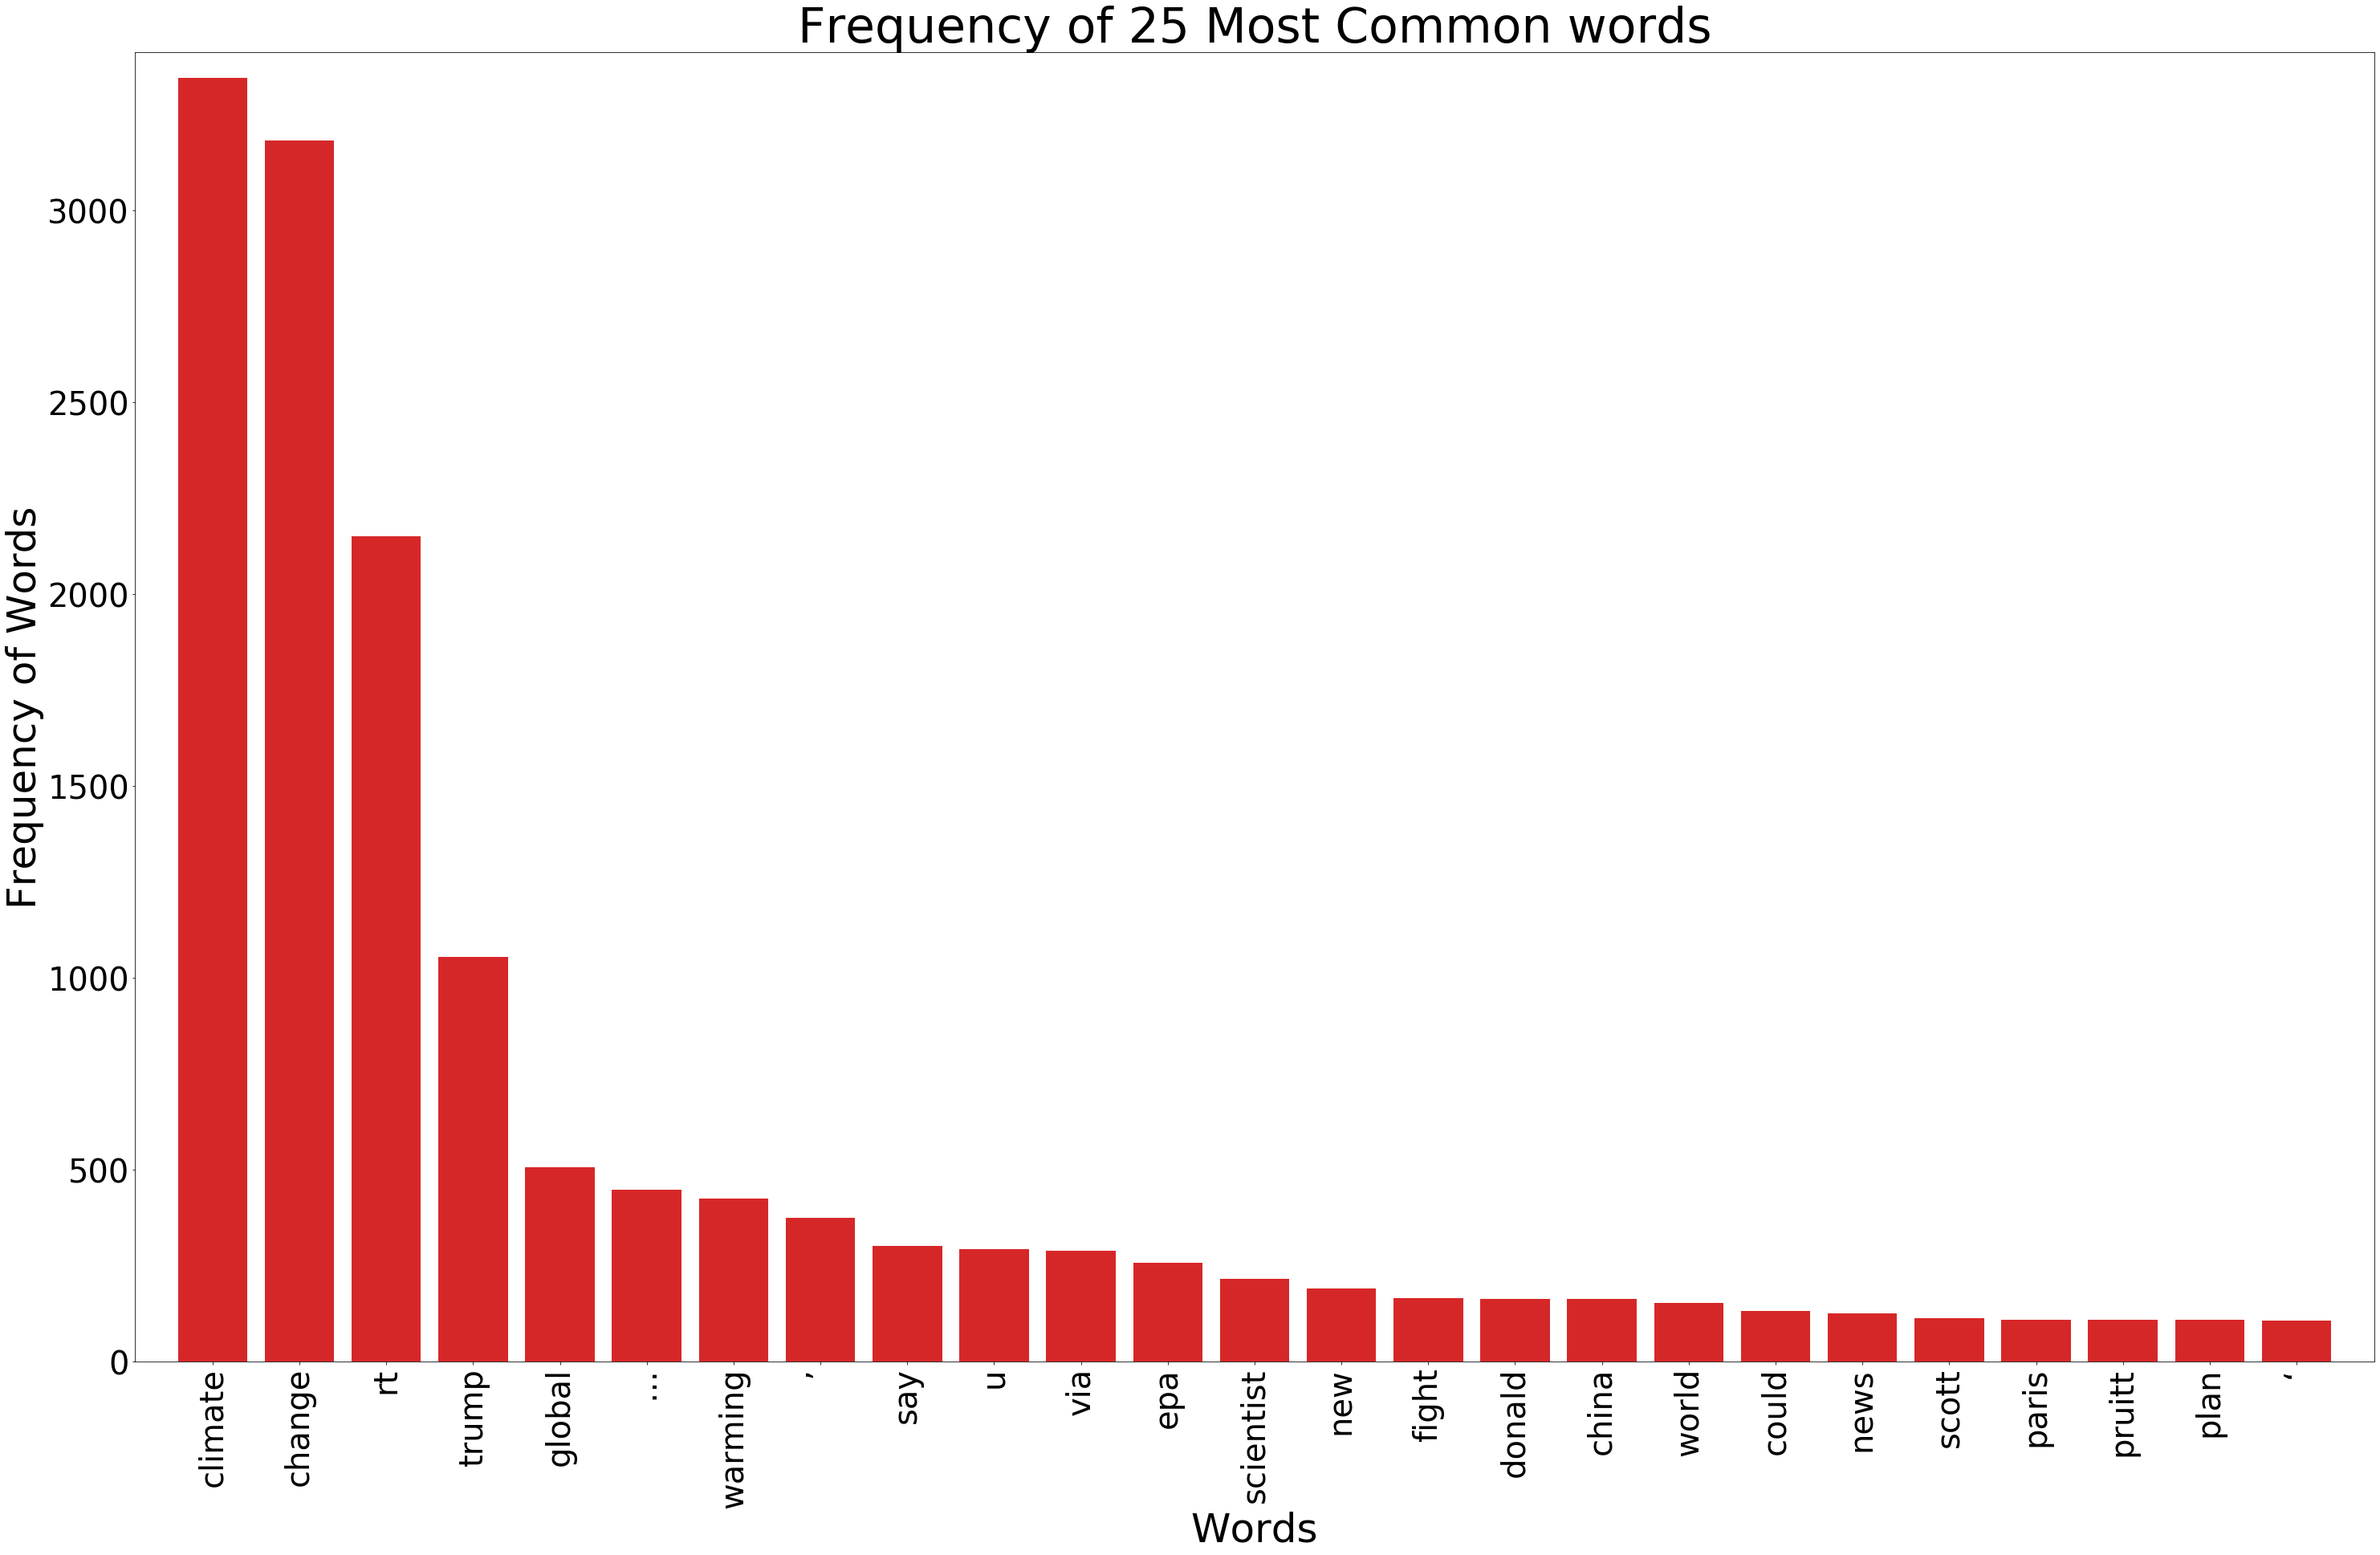

In [544]:
allwords = []
for wordlist in train[train['sentiment'] == 2]['clean_tokens']:
    allwords += wordlist


plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Most common nouns

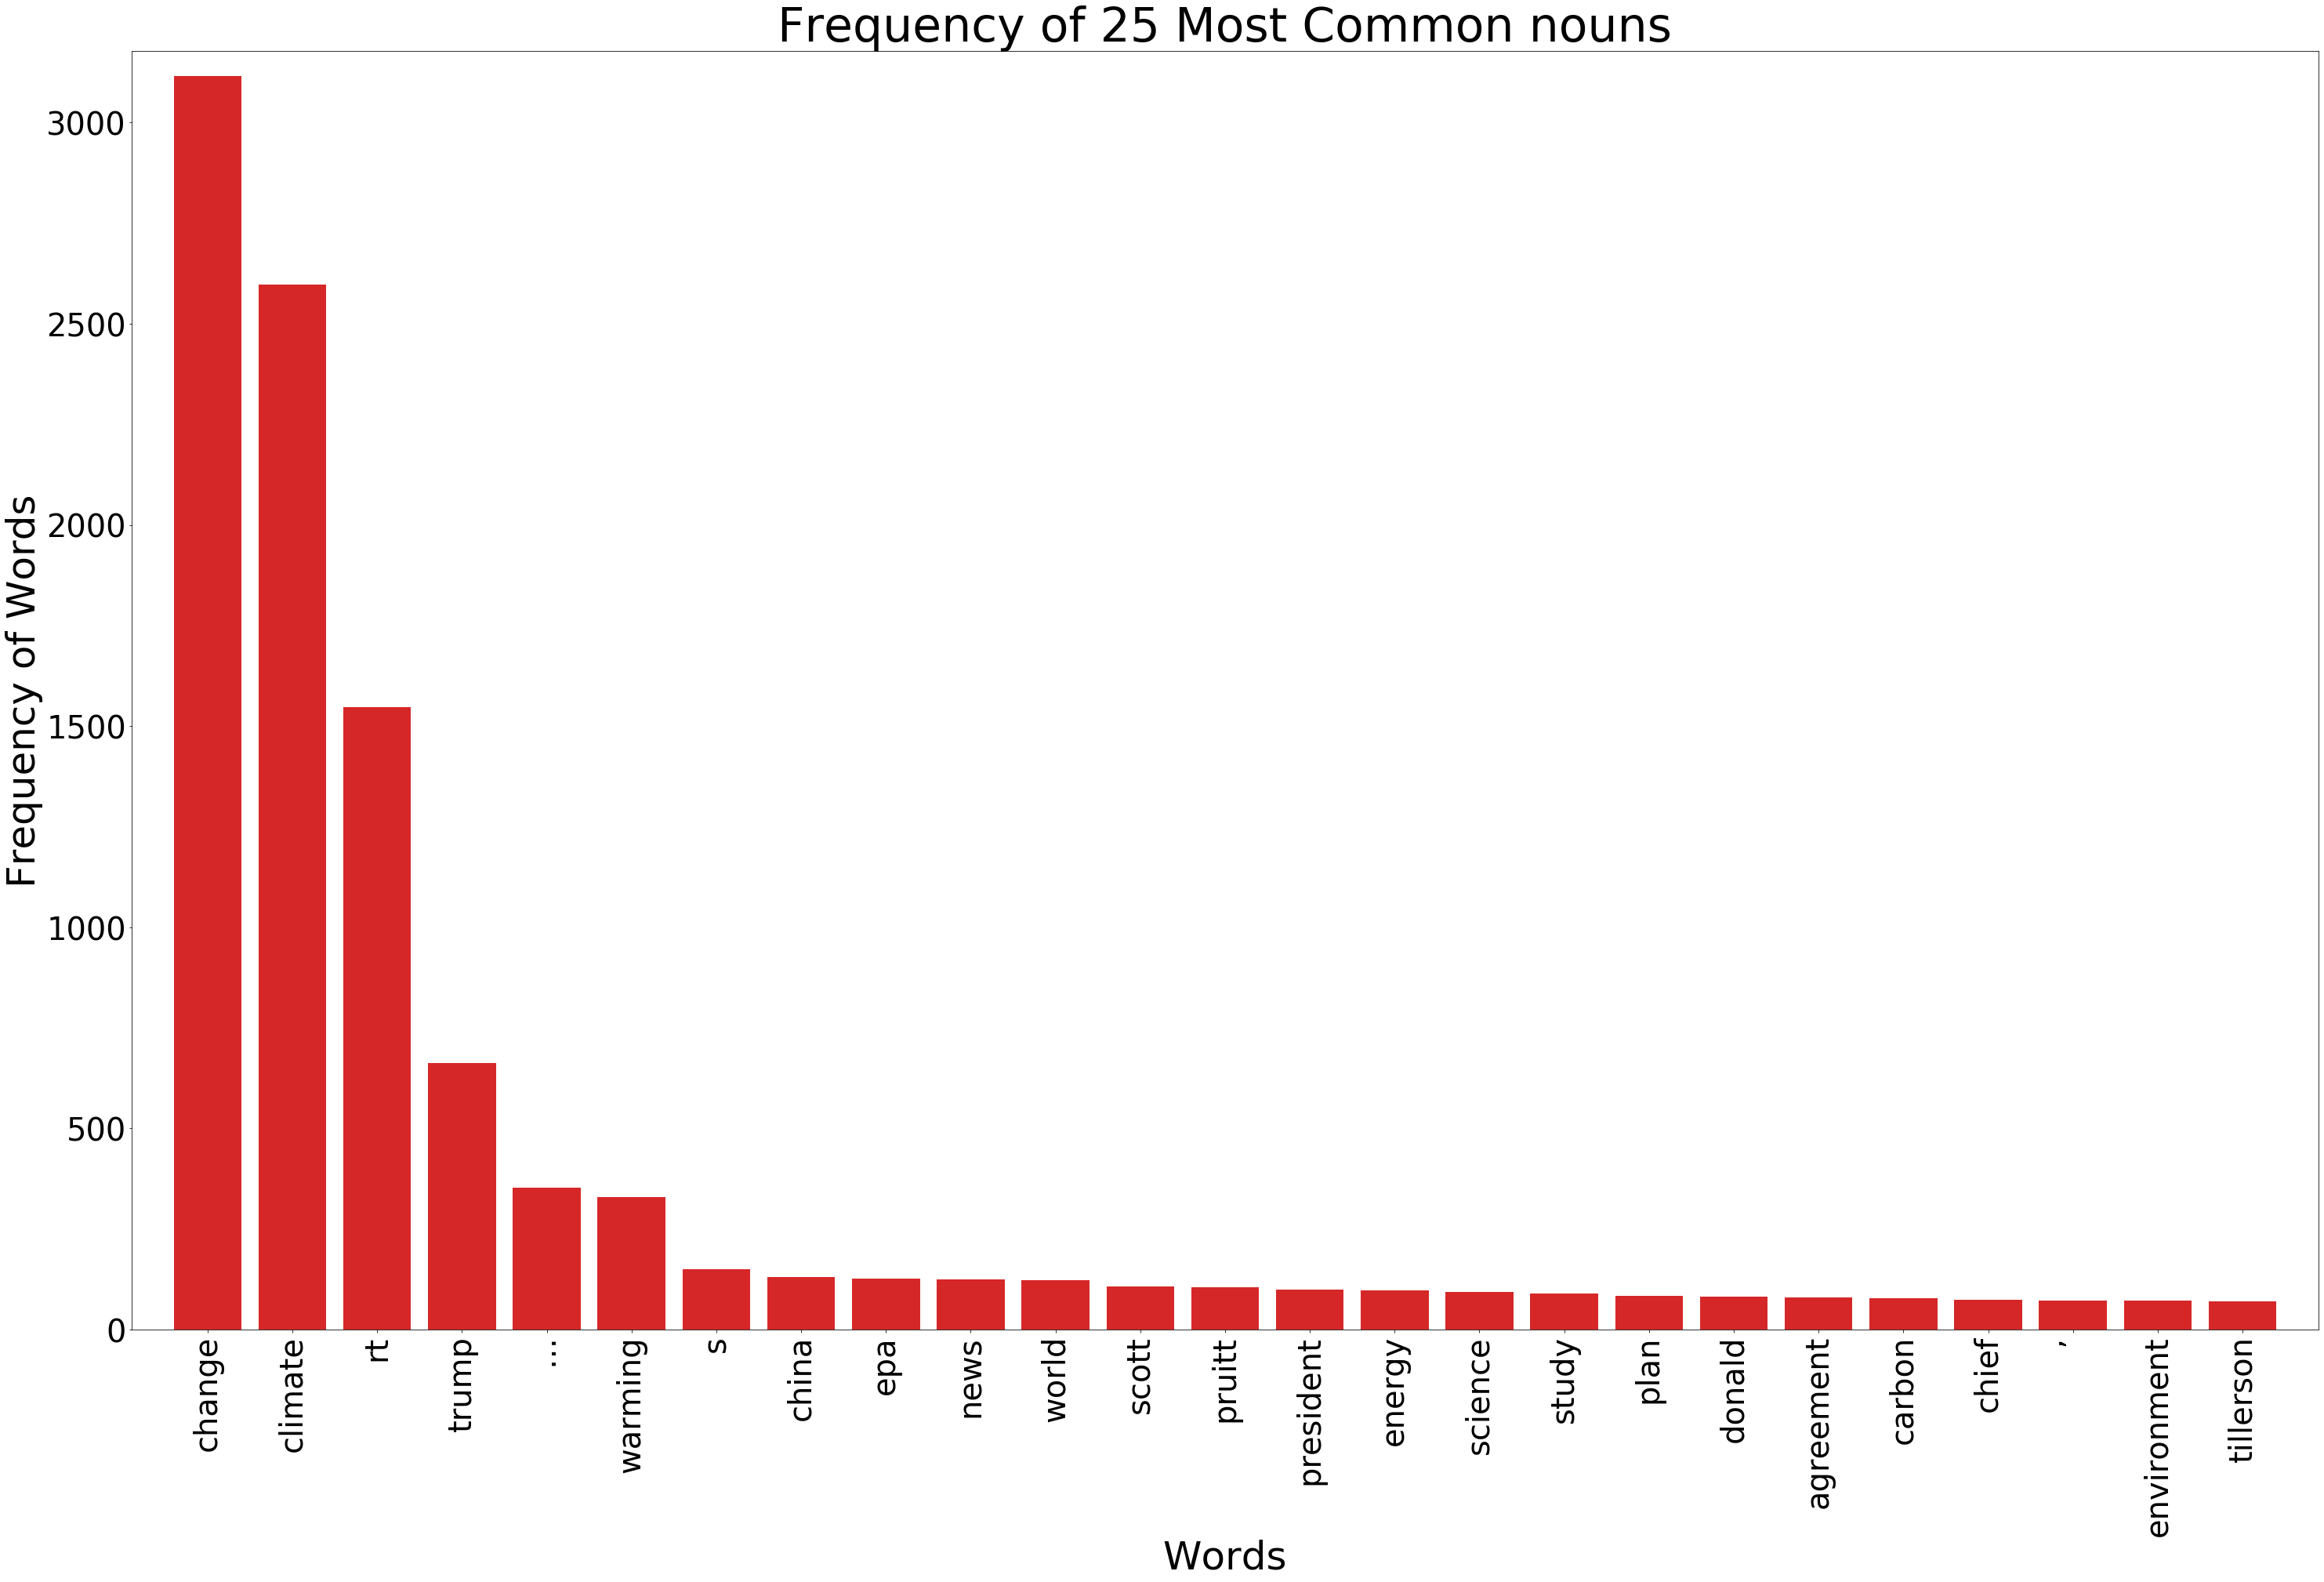

In [545]:
allnouns = []
for wordlist in train[train['sentiment'] == 2]['POS_nouns']:
    allnouns += wordlist

plot_most_frequent(allnouns, 'Frequency of 25 Most Common nouns')


### Most common verbs

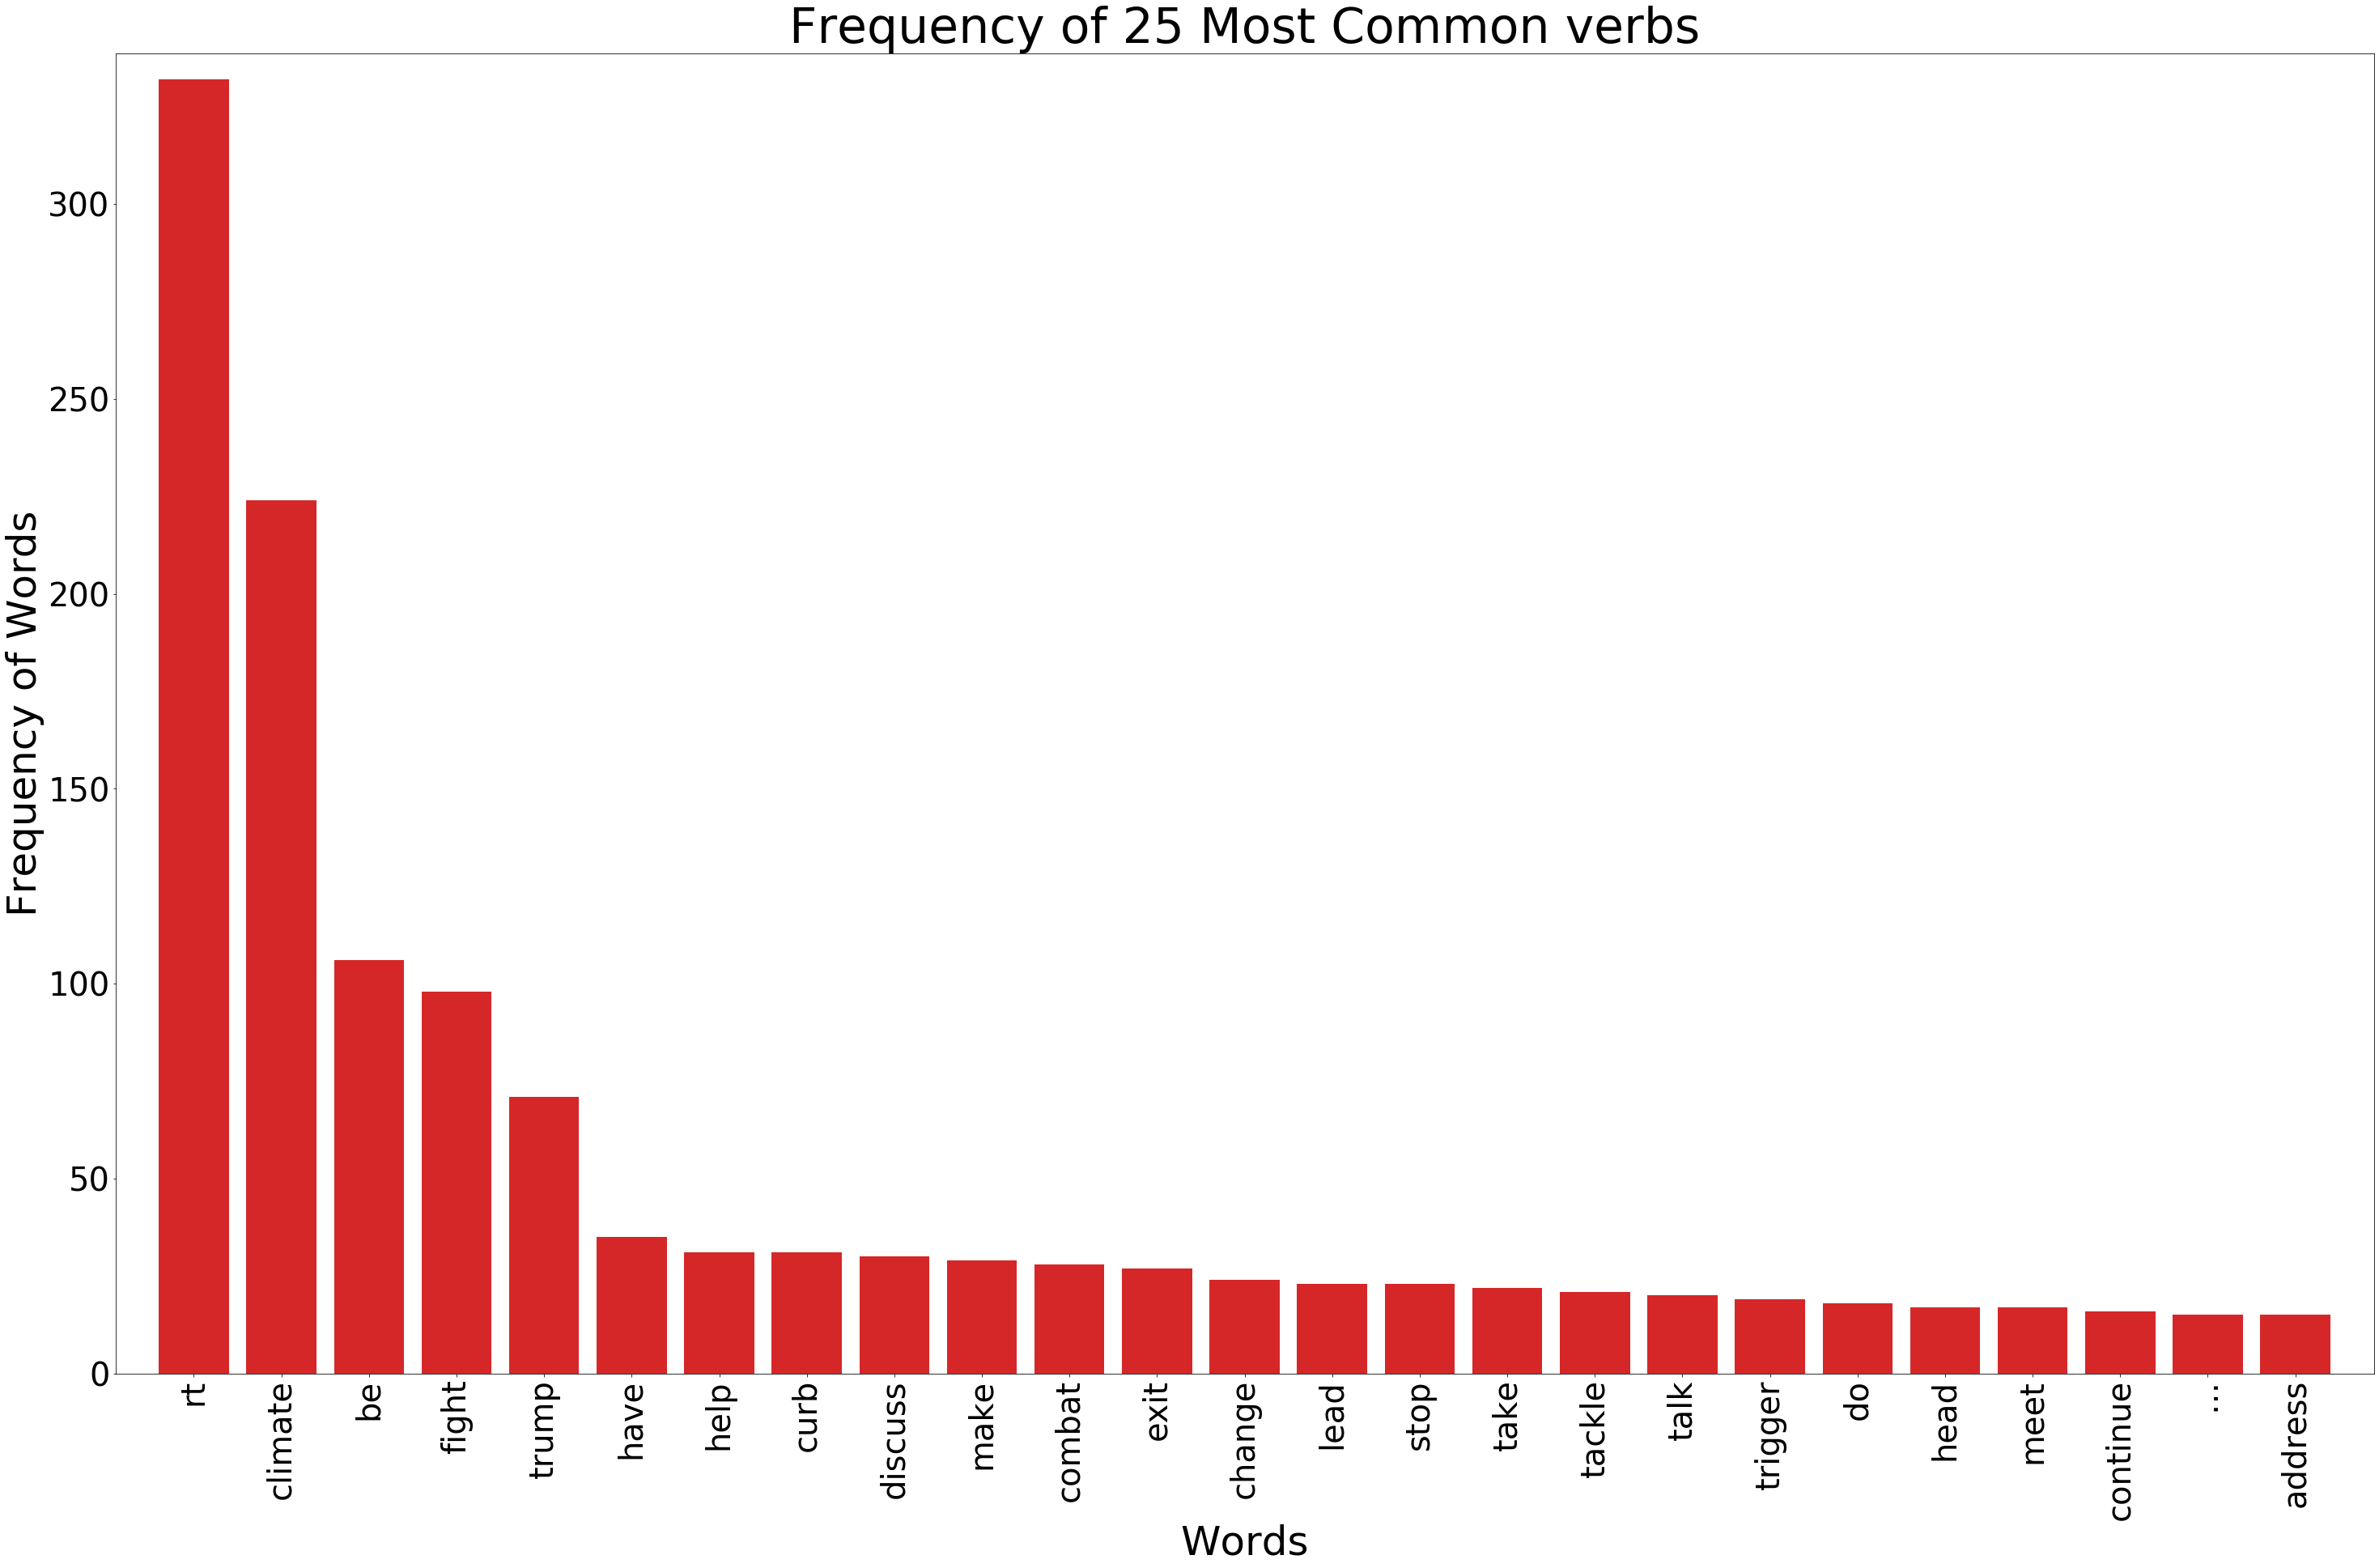

In [546]:
allverbs = []
for wordlist in train[train['sentiment'] == 2]['POS_verbs']:
    allverbs += wordlist

plot_most_frequent(allverbs, 'Frequency of 25 Most Common verbs')


### Visualise bi-grams

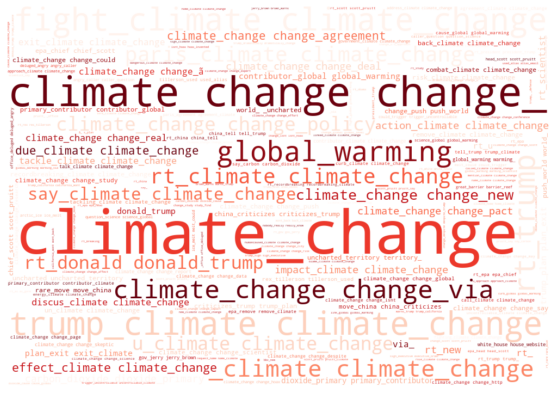

In [547]:
all_words = ' '.join([text for text in train[train['sentiment'] == 2]['bigrams_text']])
plotwordclouds(all_words)


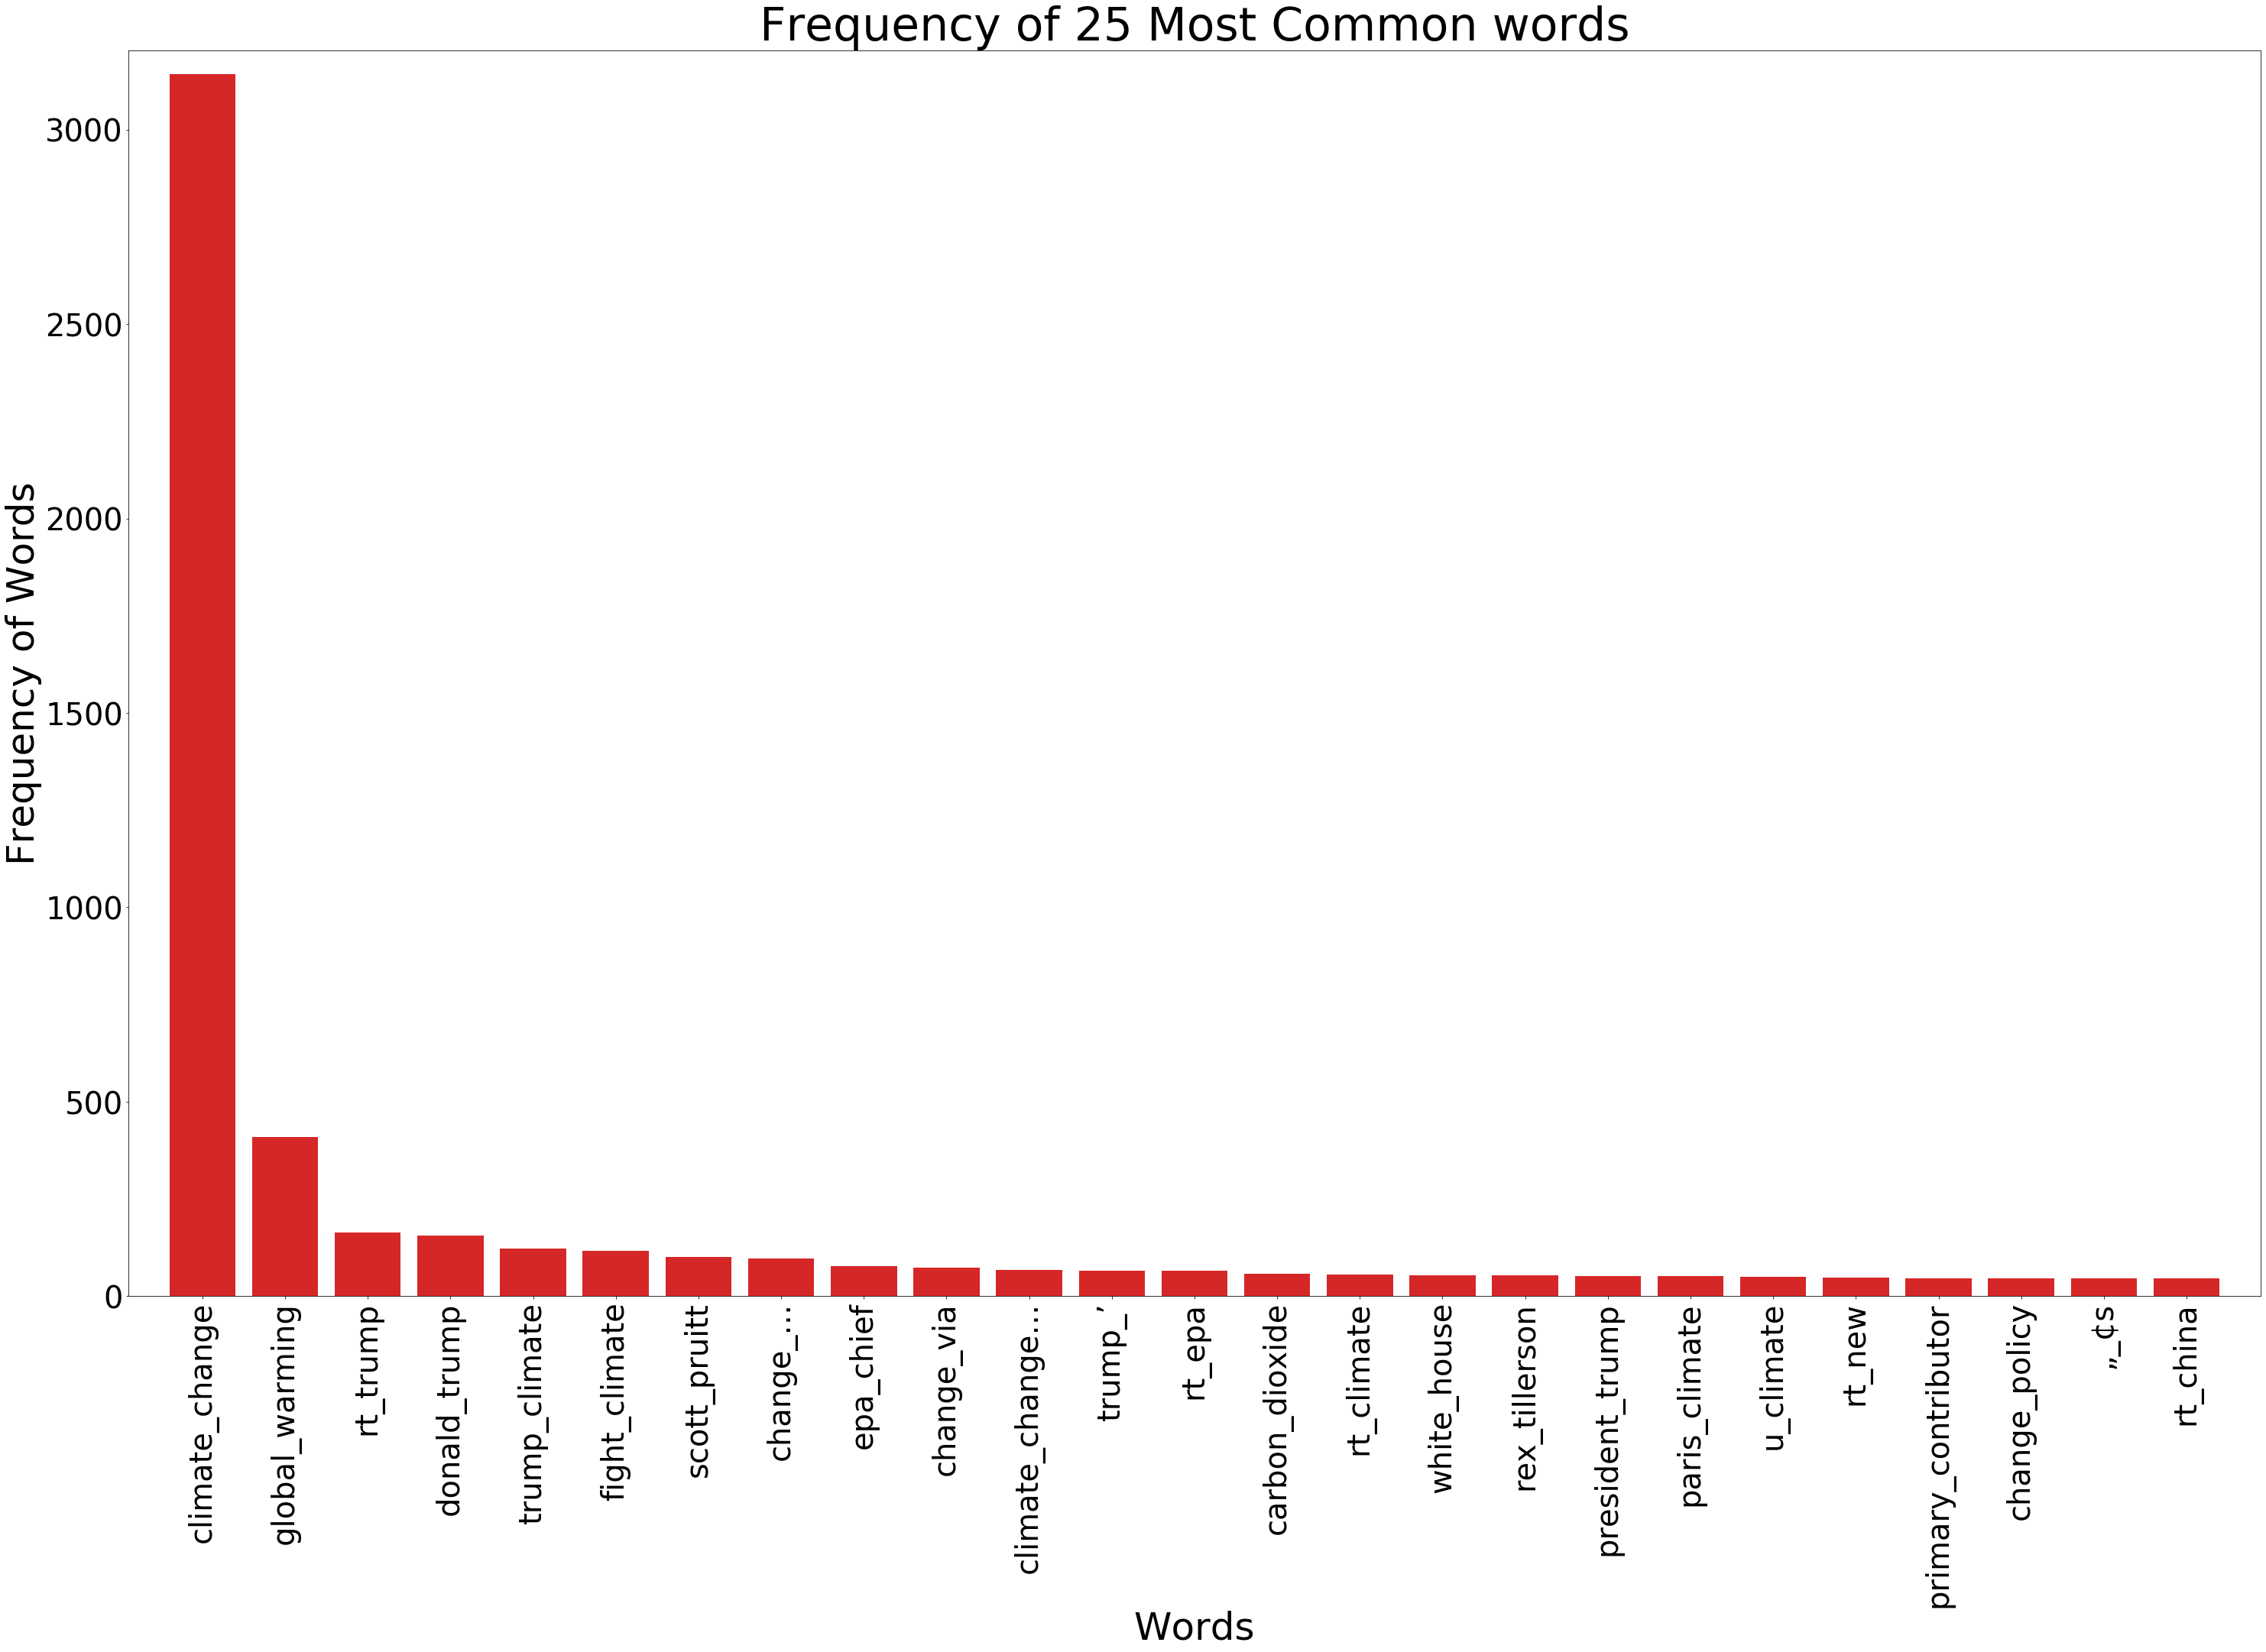

In [548]:
allwords = []
for wordlist in train[train['sentiment'] == 2]['bigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


### Visualise tri-grams

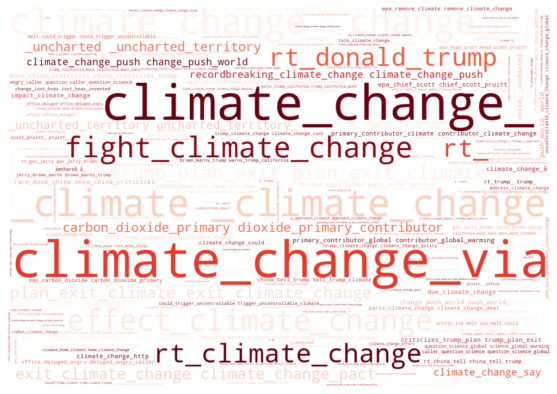

In [549]:
all_words = ' '.join([text for text in train[train['sentiment'] == 2]['trigrams_text']])
plotwordclouds(all_words)


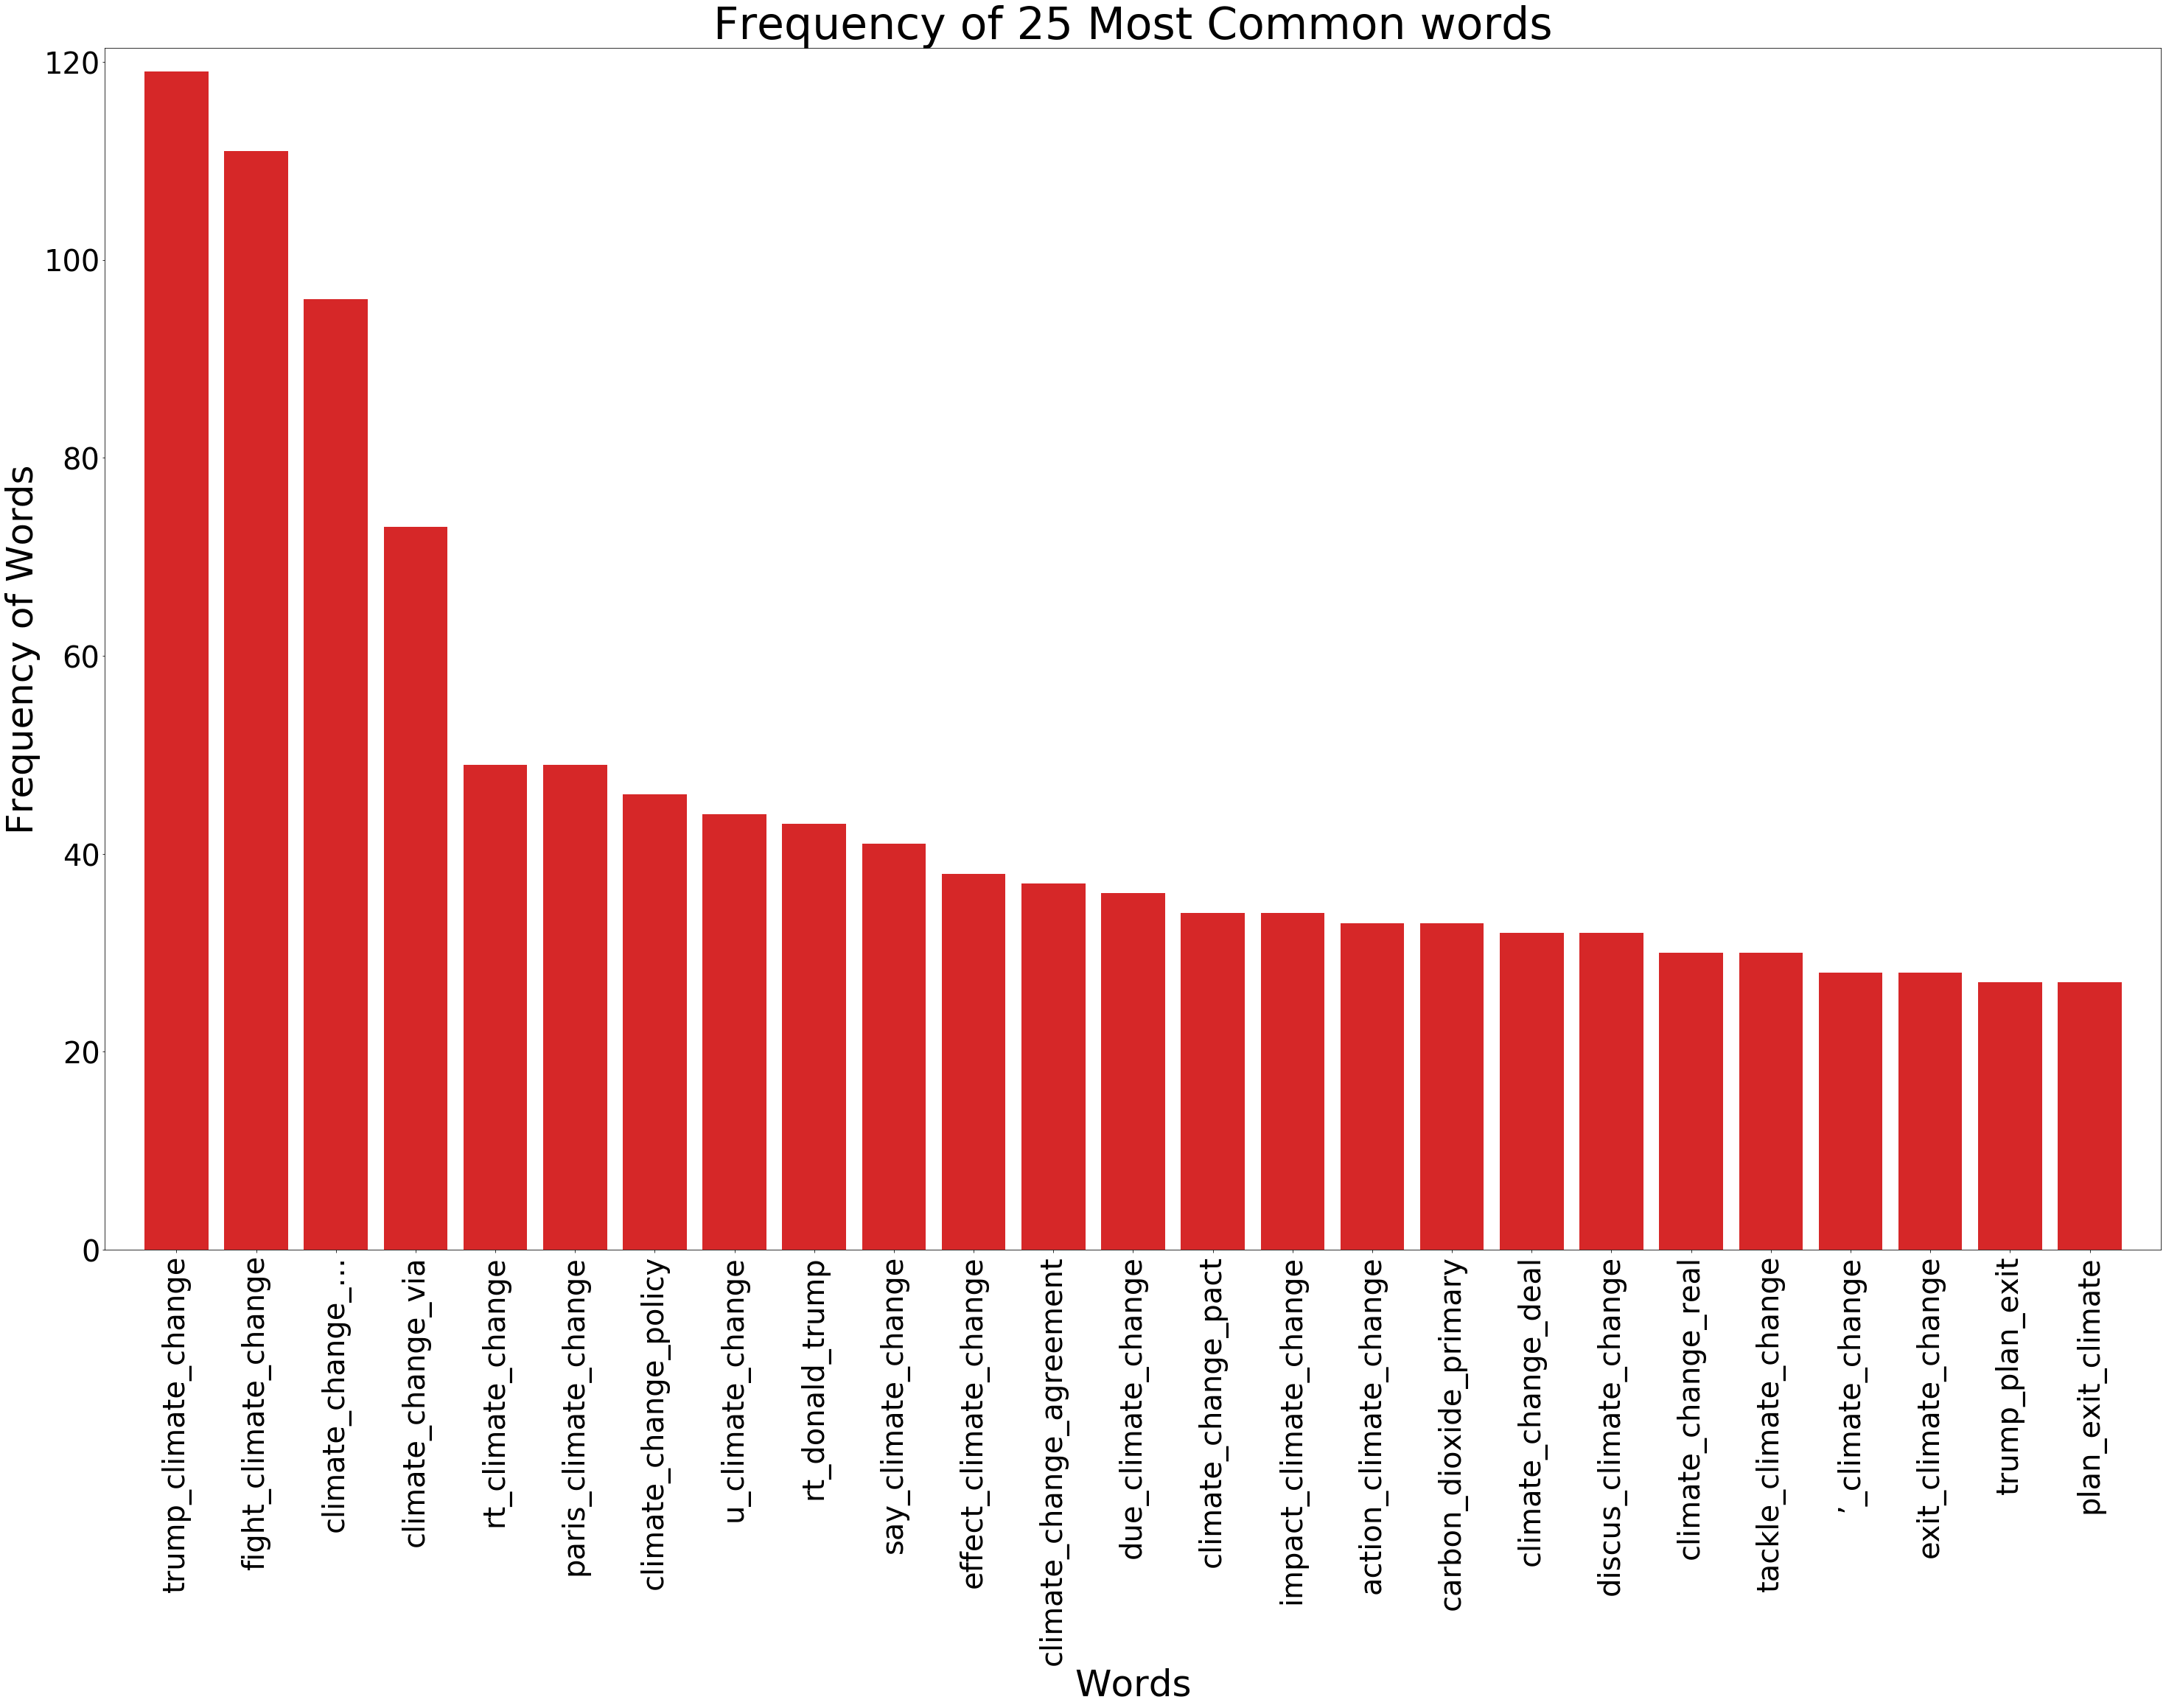

In [550]:
allwords = []
for wordlist in train[train['sentiment'] == 2]['trigrams_text_list']:
    allwords += wordlist

plot_most_frequent(allwords, 'Frequency of 25 Most Common words')


# MODEL DEVELOPMENT

### Train and test data (tokenized, lemmatized,and cleaned)

In [24]:
X = train['message']
y = train['sentiment']
test_x = test['message']


In [25]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)


### Train and test data (minimal preprocessing)


In [26]:
X_up = train['unclean']
y_up = train['unclean']
test_up_x = test['unclean']


In [27]:
X_train_up, X_test_up, y_train_up,
y_test_up = train_test_split(X_up, y_up, test_size=0.2, random_state=42)


### Tfidf transformation for pre-processed data

In [28]:
vectorizer = TfidfVectorizer()
tfidf_vect = vectorizer.fit(X_train)
xtrain_tfidf = tfidf_vect.transform(X_train)


In [29]:
xtest_tfidf =  tfidf_vect.transform(test_x)


### Tfidf transformation for minimally pre-processed data

In [30]:
vectorizer_up = TfidfVectorizer()
tfidf_vect_up = vectorizer_up.fit(X_train_up)
xtrain_tfidf_up = tfidf_vect_up.transform(X_train_up)


In [31]:
xtest_tfidf_up =  tfidf_vect_up.transform(test_up_x)


## Develop a linear support vector machine (Pre-processed)

### Cross validation is used to get the average F1 score

In [32]:
clf = LinearSVC()
clf.fit(xtrain_tfidf, y_train)
scores = cross_val_score(clf, xtrain_tfidf, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.72 (+/- 0.01)


In [33]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])
text_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [34]:
predictions_p = text_clf.predict(X_test)


In [35]:
metric_evaluation(y_test,predictions_p)


[[ 126   36  105   11]
 [  22  183  183   37]
 [  35  100 1453  167]
 [   7   24  167  508]]
              precision    recall  f1-score   support

          -1       0.66      0.45      0.54       278
           0       0.53      0.43      0.48       425
           1       0.76      0.83      0.79      1755
           2       0.70      0.72      0.71       706

    accuracy                           0.72      3164
   macro avg       0.67      0.61      0.63      3164
weighted avg       0.71      0.72      0.71      3164

0.7174462705436156


In [42]:
accuracy,precision,recall,f1 = scored(y_test,predictions_p)


In [43]:
params = {"model_type": "clf",
          "stratify": True}

metrics = {'accuracy': scores.mean(),
           'precision': precision,
           'recall': recall,
           'f1': f1}


In [44]:
experiment.log_parameters(params)
experiment.log_metrics(metrics)


In [45]:
experiment.end()


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/lee-roy/general/da359d69bb8f42328bd11e05913862c3
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.7180564349449575
COMET INFO:     f1        : 0.6298373839472838
COMET INFO:     precision : 0.6652109822487895
COMET INFO:     recall    : 0.60782315387398
COMET INFO:   Parameters:
COMET INFO:     clf_C                 : 1.0
COMET INFO:     clf_class_weight      : 1
COMET INFO:     clf_dual              : True
COMET INFO:     clf_fit_intercept     : True
COMET INFO:     clf_intercept_scaling : 1
COMET INFO:     clf_loss              : squared_hinge
COMET INFO:     clf_max_iter          : 1000
COMET INFO:     clf_multi_class       : ovr
COMET INFO:     clf_penalty           : l2
COMET INFO:     clf_random_state      : 1
COMET INFO:     clf_tol    

In [46]:
experiment.display()


### Obtain and save predictions

In [563]:
predictions = clf.predict(xtest_tfidf)


In [564]:
predictions_df = pd.DataFrame(data=predictions, index=test['tweetid'],
                              columns=['sentiment'])


In [565]:
predictions_df


sentiment
tweetid           
169760           1
35326            1
224985           1
476263           1
872928           1
...            ...
895714           1
875167           1
78329            1
867455           0
470892           2

[10546 rows x 1 columns]

In [566]:
predictions_df.to_csv('predictions_df.csv')


## Develop a linear Support Vector Vachine(SVM) (Minimal pre-processing)

In [ ]:
clf_up = LinearSVC()
clf_up.fit(xtrain_tfidf_up, y_train_up)
scores = cross_val_score(clf, xtrain_tfidf_up, y_train_up, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\_base.py", line 969, in _fit_liblinear
    epsilon, sample_weight)
  Fil

Doing some Hyperparameter tuning

In [ ]:
dua = [True,False]
c = [0.001,0.01,0.1,1,10]
param_grid = {'dual':dua,
             'C':c}

In [ ]:
grid_SVM = GridSearchCV(LinearSVC(),param_grid,cv=10)
grid_SVM.fit(xtrain_tfidf,y_train)

In [ ]:
grid_SVM.best_params_

In [569]:
predictions_1 = clf_up.predict(xtest_tfidf_up)
predictions_df_1 = pd.DataFrame(data=predictions_1, index=test['tweetid'],
                                columns=['sentiment'])
predictions_df_1


sentiment
tweetid           
169760           1
35326            1
224985           1
476263           1
872928           0
...            ...
895714           1
875167           1
78329            2
867455           0
470892           1

[10546 rows x 1 columns]

In [570]:
predictions_df_1.to_csv('predictions_df_1.csv')


### The data that has minimal pre-processing provides the best accuracy score, therefore going forward, that data is used.

## Develop a logistic regression model

In [571]:
clf_lr = LogisticRegression(max_iter=4000)
clf_lr.fit(xtrain_tfidf_up, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [572]:
scores = cross_val_score(clf_lr, xtrain_tfidf_up, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.74 (+/- 0.01)


Doing some Hyperparameter tuning

In [ ]:
dua = [True,False]
c = [0.001,0.01,0.1,1,10]
solve = ['newton-cg','lbfgs','liblinear','sag','saga']
param_grid = {'dual':dua,
             'C':c,
             'solver':solve}

In [ ]:
grid_LR = GridSearchCV(LogisticRegression(max_iter=4000),param_grid,cv=10)
grid_LR.fit(xtrain_tfidf,y_train)

In [ ]:
grid_LR.best_params_

In [573]:
predictions_2 = clf_lr.predict(xtest_tfidf_up)
predictions_df_2 = pd.DataFrame(data=predictions_2, index=test['tweetid'],
                                columns=['sentiment'])
predictions_df_2


sentiment
tweetid           
169760           1
35326            1
224985           1
476263           1
872928           0
...            ...
895714           1
875167           1
78329            2
867455           0
470892           1

[10546 rows x 1 columns]

In [574]:
predictions_df_2.to_csv('predictions_df_2.csv')


The linear SVM model performs better than the logistic regression model

## Develop a Random Forest Model

In [576]:
clf_RF = RandomForestClassifier(criterion='entropy', random_state=0)
clf_RF.fit(xtrain_tfidf_up, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [577]:
scores = cross_val_score(clf_RF, xtrain_tfidf_up, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.72 (+/- 0.02)


Doing some hyperparameter tuning

In [ ]:
features = ['auto','sqrt','log2']
c = [0.001,0.01,0.1,1,10]
estimators = [10,20,50,75,100]
param_grid = {'dual':dua,
             'C':c,
             'n_estimators':estimators}

In [ ]:
grid_RF = GridSearchCV(RandomForestClassifier(criterion = 'entropy',random_state=0),param_grid,cv=10)
grid_RF.fit(xtrain_tfidf,y_train)

In [ ]:
grid_RF.best_params_

In [578]:
predictions_3 = clf_RF.predict(xtest_tfidf_up)
predictions_df_3 = pd.DataFrame(data=predictions_3, index=test['tweetid'],
                                columns=['sentiment'])
predictions_df_3


sentiment
tweetid           
169760           1
35326            1
224985           1
476263           1
872928           0
...            ...
895714           1
875167           1
78329            1
867455           0
470892           1

[10546 rows x 1 columns]

The Random Forest model does not produce more accuerate predictions
The linear SVM model produced tthe best predictions

## Over Sampling using Synthetic Minority Oversampling Technique (SMOTE) 


In [579]:
sm = SMOTE(random_state=1234)
X_res, y_res = sm.fit_resample(xtrain_tfidf_up, y_train)


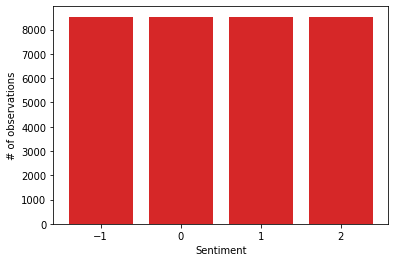

In [592]:
counts = list(y_res.value_counts())
labels = y_res.unique()
heights = counts
plt.bar(labels, heights, color='tab:red')
plt.xticks(labels)
plt.ylabel("# of observations")
plt.xlabel("Sentiment")
plt.show()


### Fit a linear SVM mmodel

In [580]:
clf1 = LinearSVC()
clf1.fit(X_res, y_res)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [581]:
scores = cross_val_score(clf1, X_res, y_res)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.93 (+/- 0.02)


In [582]:
predictions_4 = clf1.predict(xtest_tfidf_up)


Even though the accuracy is high, when formal submission was made it perfomed worse than the unbalance linear SVM. This may be because the synthetic observations are causing overfitting

In [583]:
predictions_df4 = pd.DataFrame(data=predictions_4, index=test['tweetid'],
                               columns=['sentiment'])


In [584]:
predictions_df4.to_csv(r'predictions_df4.csv')


## Random Undersampling

In [589]:
rus = RandomUnderSampler(random_state=123)
X_res_u, y_res_u = rus.fit_resample(xtrain_tfidf_up, y_train)


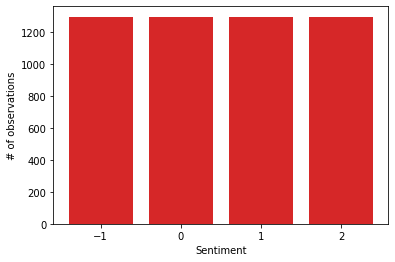

In [593]:
counts = list(y_res_u.value_counts())
labels = y_res_u.unique()
heights = counts
plt.bar(labels, heights, color='tab:red')
plt.xticks(labels)
plt.ylabel("# of observations")
plt.xlabel("Sentiment")
plt.show()


In [590]:
clf2 = LinearSVC()
clf2.fit(X_res_u, y_res_u)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [591]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf2, X_res_u, y_res_u, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.68 (+/- 0.04)


In [594]:
predictions_5 = clf2.predict(xtest_tfidf_up)
predictions_df5 = pd.DataFrame(data=predictions_5, index=test['tweetid'],
                               columns=['sentiment'])
predictions_df5


sentiment
tweetid           
169760           1
35326            1
224985           1
476263           0
872928           0
...            ...
895714          -1
875167           1
78329            2
867455           0
470892           1

[10546 rows x 1 columns]

In [595]:
predictions_df5.to_csv(r'predictions_df5.csv')


The Linear SVM model without sampling produced the highest accuracy, however a SMOTE model may be the best option as it will more accurately predict the minority clases